# 0: Setup Environment

### Check that tensorflow & keras are installed before loading modules

In [1]:
import importlib.metadata

print("Has tensorflow:", importlib.metadata.version("tensorflow"))
print("Has keras:     ", importlib.metadata.version("keras"))

Has tensorflow: 2.18.0
Has keras:      3.6.0


## Load modules and custom functions

In [2]:
# --- Environment Setup ---
import sys, os
# insert the parent folder of `notebooks/` as the first place to look for modules
sys.path.insert(0, os.path.abspath('..'))

# Enable SciPy’s Array API support for imblearn and scikit-learn
os.environ["SCIPY_ARRAY_API"] = "1"

import sys
from pathlib import Path

import time
import numpy as np
import pandas as pd
import polars as pl, pyarrow # required for polars file reading


# load custom functions
from pys import *
from pys.utils import *

# import plotting & display libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pprint import pprint



# import sklearn libraries
from sklearn import set_config
set_config(display='diagram')  # for better visualization of sklearn pipelines
import lightgbm as lgb # import lgb.LGBMRegressor
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_validate
# for feature selection use SelectKBest with f_regression
from sklearn.feature_selection import SelectKBest, f_regression
import scipy
from scipy.stats      import loguniform, randint

from sklearn.base import clone
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# import feature selection methods
from sklearn.inspection import permutation_importance
from sklearn.base import clone


# import model explainability
import shap
shap.initjs # to display plots

# nueral network with tensorflow and keras  
import keras
from keras import Input, layers, Model
import graphviz

# import xgboost libraries
import optuna
import xgboost as xgb # for GPU XGBoost
from xgboost import XGBRegressor, XGBClassifier
# from xgboost import plot_importance, plot_tree, plot_xgboost

# import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectFromModel

# import joblib for saving models
import joblib # for saving models
from joblib import Parallel, delayed
import random

# bring in imbalanced-learn for oversampling
from imblearn.over_sampling import SMOTE

# import warnings to ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)  # ignore future warnings


warnings.filterwarnings("ignore", category=UserWarning)

# ignore just that pkg_resources deprecation warning
warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API",
    category=UserWarning
)

## Define Functions

### Check if NVIDIA GPU is used and set global to use it.

This notebook was developed on a Macbook M4 Pro and a linux server with NVIDIA GeForce RTX 3090 - 24GB.
Therefore, to take advantage of the GPU the code is setup to check if it is present and utilize it for high compute hyper-tuning of models.

In [3]:
# Function to check if an NVIDIA GPU is present
def check_nvidia_cupy_present():
    try:
        import cupy as cp  # Import cupy to check for GPU availability
        if cp.cuda.runtime.getDeviceCount() > 0:
            return True
    except ImportError:
        print("cupy is not installed. GPU support will not be available.")
    except Exception as e:
        print(f"An error occurred while checking for GPU: {e}")
    return False

def get_gpu_if_present():
    # Check for NVIDIA GPU presence
    print("Checking for NVIDIA GPU...")
    if check_nvidia_cupy_present():
        print("NVIDIA GPU detected. Using GPU for XGBoost training.")
        NVIDIA_GPU = True # Set to True if you have an NVIDIA GPU and want to use it for training
        # Set the XGBoost parameters to use GPU
        XGB_PARAMS_CPU_GPU = {
            'tree_method': 'gpu_hist',  # Use GPU for training
            'predictor': 'gpu_predictor',  # Use GPU for prediction
            'gpu_id':            0,
        }          
    else:
        print("No NVIDIA GPU detected or not available. Using CPU for XGBoost training.")
        NVIDIA_GPU = False
        # Set the XGBoost parameters to use CPU
        XGB_PARAMS_CPU_GPU = {
            'tree_method': 'hist',  # Use CPU for training
            'predictor': 'cpu_predictor',  # Use CPU for prediction
        }
    return NVIDIA_GPU, XGB_PARAMS_CPU_GPU


### Definitions for Capturing Model Metrics

In [4]:
## Save pipeline name in the model
class NamedPipeline(Pipeline):
    # Add model_name to the model (pipeline)
    def __init__(self, name, steps):
        super().__init__(steps)
        self.name = name


## Get model y_scores metric
def get_y_scores(model, X):
    """
        Get y_scores from model.predict_proba or decision_fuction.
        If neither exist for the model, y_scores = list of zeros

        Args:
            model: Trained model or pipeline with predict/predict_proba.
            model_name (str): Name of the model.
            X (pd.DataFrame): Features.
        Returns:
            y_scores (list)
      """
    # Check predict_proba exists for a model
    try:
        y_scores = model.predict_proba(X)[:, 1]
    except (AttributeError, NotImplementedError):
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X)
        else:
            y_scores = [0] * len(X)  # fallback for scoring

    return y_scores


def print_model_metrics(df_eval, df_info, split='both'):
    # add descriptions to model evaluation table
    if split == 'both':
        df_model_results = df_eval.copy()
    else:
        df_model_results = df_eval[df_eval.Split == split].copy()

    column_order = ['Model Info'] + df_model_results.columns.to_list()
    # Create the 'Model_Info' column by mapping model_name to model_description
    df_model_results['Model Info'] = df_model_results['Model'].map(
        lambda model_name: df_info.loc[df_info['model_name'] == model_name, 'model_description'].values[0]
        if not df_info.loc[df_info['model_name'] == model_name, 'model_description'].empty else None
    )
    df_model_results = df_model_results[column_order]

    print_df_markdown(df_model_results.drop(columns=['Model']))

def check_ypredict_exists_in_df(df, model_list):
    '''
    Check the dataframe to see if a column with '_y_pred' exists
    '''
    
    exist = []
    not_exist = []
    
    for model_name in model_list:
        columns = df.columns.tolist()
        y_pred_col = f"{model_name}_y_pred"
        if y_pred_col not in columns:
            not_exist.append(model_name)
        else:
            exist.append(model_name)

    return exist, not_exist


### Custom Plotting functions

In [5]:
# plot model results
def plot_clf_model_results_grid(model, model_name, data_type, df_models, X_test, y_test):
    '''
    Plot confusion matrix, precision-recall (PR) curve, ROC curves,
    and a table of performance metrics for a given classification model.

    Args:
        model (sklearn estimator): The trained classification model (e.g., pipeline with classifier).
        model_name (str): Name of the model as it appears in the `df_models` DataFrame.
        data_type (str): Label indicating whether the results are for 'Train', 'Validation', or 'Test' data.
        df_models (pd.DataFrame): DataFrame containing performance metrics (e.g., Accuracy, Precision, Recall, PR_AUC) for multiple models.
        X_test (pd.DataFrame or np.ndarray): Feature matrix for prediction.
        y_test (pd.Series or np.ndarray): True binary labels corresponding to `X_test`.

    Returns:
        None. Displays a multi-panel matplotlib figure with:
            - Normalized confusion matrix
            - Precision-recall curve and AUC
            - ROC curves for positive and negative classes
            - A performance summary table extracted from `df_models`
    '''
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    flt = get_model_condition(model_name, data_type, df_models_eval=df_models)

    recall =    df_models[flt]['Recall'].iloc[0]
    precision = df_models[flt]['Precision'].iloc[0]

    # work with lgr_pipe prediction
    y_pred = model.predict(X_test)


    # Precision–Recall (PR) Curve & AUC
    y_scores = get_y_scores(model, X_test)


    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Compute PR AUC
    pr_auc = average_precision_score(y_test, y_scores)
    # print(f"\nPR AUC: {pr_auc:.3f}")

    # Create figure and GridSpec
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[2, 2, 1])  # 3 rows, 2 columns

    # Top row: plots
    ax0 = fig.add_subplot(gs[0, :])
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0], normalize='true')
    ConfusionMatrixDisplay(
        confusion_matrix=conf_mat, 
        display_labels=['yes','no']
        ).plot(ax=ax0)
    ax0.set_title(f"{model_name} - Normalized Confusion Matrix")


    ax1 = fig.add_subplot(gs[1, 0])
    ax1.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.set_title(f"{model_name} - Precision-Recall Curve")
    ax1.legend()
    ax1.grid(True)

    #ax2 = fig.add_subplot(gs[1, 0])

    # Bottom left: ROC curves
    # Create ROC curves for both classes

    ax3 = fig.add_subplot(gs[1, 1])
    fp_yes, tp_yes, thres_yes = roc_curve(y_true=y_test,  y_score=y_scores, pos_label=1)
    fp_no,  tp_no,  thres_no  = roc_curve(y_true=y_test,  y_score=y_scores, pos_label=0)
    ax3.plot(fp_yes, tp_yes, label="Yes")
    ax3.plot(fp_no, tp_no, label="No")    
    ax3.legend(loc="upper left")
    ax3.set_title(f"{model_name} -ROC Curve", size=12)
    ax3.plot([0, 1], [0, 1], color='green', linestyle='-')
    ax3.set_xlabel('FP')
    ax3.set_ylabel('TP')
    ax3.grid(True)


    # Bottom row: table spans both columns
    ax_table = fig.add_subplot(gs[2, :])
    ax_table.axis('off')

    # Create table
    table = ax_table.table(
        cellText=df_models.loc[flt].values,
        colLabels=df_models.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)  # scale width and height

    plt.tight_layout()
    plt.show()
    return fig



In [6]:
# plot_confusion_matrix(y_val_cat, df_val[f"{model_name}_y_pred_bin"], model_name, labels=[1,0], normalize='true')
def plot_confusion_matrix(y_true, y_pred, model_name, labels=None, normalize=None):
    """
    Plot a confusion matrix for the given true and predicted labels.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model for labeling the plot.
        labels (list, optional): List of labels to index the matrix. Defaults to None.
        normalize (str, optional): Normalization mode ('true', 'pred', 'all'). Defaults to None.

    Returns:
        None: Displays the confusion matrix plot.
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap='Blues', values_format='.2f' if normalize else 'd')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    return disp

In [7]:
def plot_r2_between_models(df, model_name_1, model_name_2, floor=None):
                           
    """
    Plot R2 values between two models for each drug.
    
    Parameters:
      df: DataFrame containing the validation data.
      model_name_1 (str): Name of the first model.
      model_name_2 (str): Name of the second model.
      floor (int): Optional floor value to cap the y-axis.
    """
    # Calculate R² for both models
    y_pred_1_col = f"{model_name_1}_y_pred"
    y_pred_2_col = f"{model_name_2}_y_pred"
    
    if y_pred_1_col not in df.columns or y_pred_2_col not in df.columns:
        raise ValueError(f"Columns {y_pred_1_col} or {y_pred_2_col} not found in DataFrame.")              
    
    r2_base = (
        df
        .groupby('drug_id')
        .apply(lambda g: r2_score(g['ln_ic50'], g[y_pred_1_col]))
        .rename('r2_base')
    )

    r2_weighted = (
        df
        .groupby('drug_id')
        .apply(lambda g: r2_score(g['ln_ic50'],g[y_pred_2_col]))
        .rename('r2_weighted')
    )

    # Merge into one DataFrame
    df_r2 = pd.concat([r2_base, r2_weighted], axis=1).reset_index()

    # Scatter-plot
    fig, ax = plt.subplots(figsize=(6,6))
    df_r2.plot.scatter(
        x='r2_base',
        y='r2_weighted',
        ax=ax,
        title=f"Per-Drug R²:\n {model_name_1} vs {model_name_2}",
        xlabel=f"R² {model_name_1}",
        ylabel=f"R² {model_name_2}",
        s=50
    )

    # Add y=x line for reference
    if floor is None:
        lims = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            1 #max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
    else:
        lims = [
            floor,
            1 #  max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
    ax.plot(lims, lims, '--', color='gray', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    plt.tight_layout()
    plt.show()

def plot_r2_between_models_pick_features(df, model_name_1, model_name_2, feature_list, floor=None):
                           
    """
    Plot R2 values between two models for each drug.
    
    Args:
      df: DataFrame containing the validation data.
      model_name_1 (str): Name of the first model.
      model_name_2 (str): Name of the second model.
      feature_1 (str): Column name for feature 1
      feature_2 (str): Column name for feature 2
      floor (int): Optional floor value to cap the y-axis.
    """
    # Calculate R² for both models
    y_pred_1_col = f"{model_name_1}_y_pred"
    y_pred_2_col = f"{model_name_2}_y_pred"
 
    
    if y_pred_1_col not in df.columns or y_pred_2_col not in df.columns:
        raise ValueError(f"Columns {y_pred_1_col} or {y_pred_2_col} not found in DataFrame.")              
    
    r2_base = (
        df
        .groupby(feature_list)
        .apply(lambda g: r2_score(g['ln_ic50'], g[y_pred_1_col]))
        .clip(lower=-1)
        .rename('r2_base')
    )

    r2_weighted = (
        df
        .groupby(feature_list)
        .apply(lambda g: r2_score(g['ln_ic50'],g[y_pred_2_col]))
        .clip(lower=-1)
        .rename('r2_weighted')
    )

    # Merge into one DataFrame
    df_r2 = pd.concat([r2_base, r2_weighted], axis=1).reset_index()

    # Scatter-plot
    fig, ax = plt.subplots(figsize=(6,6))
    df_r2.plot.scatter(
        x='r2_base',
        y='r2_weighted',
        ax=ax,
        title=f"Per-Drug R²:\nGrouped by: {feature_list} \n{model_name_1} vs {model_name_2}",
        xlabel=f"R² {model_name_1}",
        ylabel=f"R² {model_name_2}",
        s=50
    )

    # Add y=x line for reference
    if floor is None:
        lims = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            1 #max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
    else:
        lims = [
            floor,
            1 #  max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]

    ax.plot(lims, lims, '--', color='gray', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    

    plt.tight_layout()
    plt.show()

def plot_r2_between_models_pick_features_old(df, model_name_1, model_name_2, feature_1, feature_2, floor=None):
                           
    """
    Plot R2 values between two models for each drug.
    
    Args:
      df: DataFrame containing the validation data.
      model_name_1 (str): Name of the first model.
      model_name_2 (str): Name of the second model.
      feature_1 (str): Column name for feature 1
      feature_2 (str): Column name for feature 2
      floor (int): Optional floor value to cap the y-axis.
    """
    # Calculate R² for both models
    y_pred_1_col = f"{model_name_1}_y_pred"
    y_pred_2_col = f"{model_name_2}_y_pred"
    print(feature_1)
    print(feature_2)
    
    if y_pred_1_col not in df.columns or y_pred_2_col not in df.columns:
        raise ValueError(f"Columns {y_pred_1_col} or {y_pred_2_col} not found in DataFrame.")              
    
    r2_base = (
        df
        .groupby([feature_1, feature_2])
        .apply(lambda g: r2_score(g['ln_ic50'], g[y_pred_1_col]))
        .clip(lower=-1)
        .rename('r2_base')
    )

    r2_weighted = (
        df
        .groupby([feature_1, feature_2])
        .apply(lambda g: r2_score(g['ln_ic50'],g[y_pred_2_col]))
        .clip(lower=-1)
        .rename('r2_weighted')
    )

    # Merge into one DataFrame
    df_r2 = pd.concat([r2_base, r2_weighted], axis=1).reset_index()

    # Scatter-plot
    fig, ax = plt.subplots(figsize=(6,6))
    df_r2.plot.scatter(
        x='r2_base',
        y='r2_weighted',
        ax=ax,
        title=f"Per-Drug R²:\nGrouped by: {feature_1}, {feature_2} \n{model_name_1} vs {model_name_2}",
        xlabel=f"R² {model_name_1}",
        ylabel=f"R² {model_name_2}",
        s=50
    )

    # Add y=x line for reference
    if floor is None:
        lims = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            1 #max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
    else:
        lims = [
            floor,
            1 #  max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]

    ax.plot(lims, lims, '--', color='gray', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    

    plt.tight_layout()
    plt.show()


In [8]:


def plot_scatter_drug_cancer_above(df, m1, m2, cutoff):
    # 1) prepare the data
    df_plot = df[[m1, m2]].copy()
    df_plot = df_plot[(df_plot[m1] >= -10) | (df_plot[m2] >= -10)]
    df_plot[m1] = df[m1].apply(lambda r: max(r, -1.0)) #df_plot[model_name_1].clip(lower=-1)
    df_plot[m2] = df[m2].apply(lambda r: max(r, -1.0)) #df_plot[model_name_2].clip(lower=-1)
    
    # 2) set up the JointGrid
    g = sns.JointGrid(data=df_plot, x=m1, y=m2, height=6, space=0)


    # 3) scatter in the joint
    g.plot_joint(sns.scatterplot, color="darkblue", alpha=0.6)

    df_plot = df_plot[(df_plot[m1] > 0) | (df_plot[m2] > 0)]
    # 4) marginal histograms *only* for points above the cutoff
    #    X-marginal: histogram of m1 for those rows where m1>=cutoff
    g.ax_marg_x.hist(
        df_plot[m1][(df_plot[m1] > -1)] ,
        bins=50,
        color="skyblue",
        alpha=0.7,
        #label=f"{m1} ≥ {cutoff}"
    )
    #    Y-marginal: histogram of m2 for those rows where m2>=cutoff
    g.ax_marg_y.hist(
        df_plot[m2][(df_plot[m2] > -1)],
        bins=50,
        orientation="horizontal",
        color="salmon",
        alpha=0.7,
        #label=f"{m2} ≥ {cutoff}"
    )

    # 5) add cutoff lines on the joint
    g.ax_joint.axvline(cutoff, color="red", linestyle="--", lw=1.5)
    g.ax_joint.axhline(cutoff, color="red", linestyle="--", lw=1.5)

    g.ax_marg_x.set_ylabel("Count")                    # y‐axis of top hist
    g.ax_marg_y.set_xlabel("Count")                    # x‐axis of right hist


    from matplotlib.ticker import MaxNLocator
    g.ax_marg_x.yaxis.set_major_locator(MaxNLocator(integer=True))
    g.ax_marg_y.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 6) labels and legend
    g.set_axis_labels(f"{m1} R²", f"{m2} R²")
    g.ax_marg_x.legend(loc="upper right")
    g.ax_marg_y.legend(loc="upper left")

    plt.suptitle("Drug–Cancer R² (only values ≥ cutoff in marginals)", y=1.02)
    plt.tight_layout()
    plt.show()


In [9]:

def plot_scatter_drug_cancer_above(df, m1, m2, cutoff, feature_1='drug_id', feature_2='cancer_type'):
    # 1) prepare the data
    df_plot = df[[m1, m2]].copy()
    df_plot = df_plot[(df_plot[m1] >= -10) | (df_plot[m2] >= -10)]
    df_plot[m1] = df[m1].apply(lambda r: max(r, -1.0)) #df_plot[model_name_1].clip(lower=-1)
    df_plot[m2] = df[m2].apply(lambda r: max(r, -1.0)) #df_plot[model_name_2].clip(lower=-1)
    
    # 2) set up the JointGrid
    g = sns.JointGrid(data=df_plot, x=m1, y=m2, height=6, space=0)


    # 3) scatter in the joint
    g.plot_joint(sns.scatterplot, color="darkblue", alpha=0.6)

    df_plot = df_plot[(df_plot[m1] > 0) | (df_plot[m2] > 0)]
    # 4) marginal histograms *only* for points above the cutoff
    #    X-marginal: histogram of m1 for those rows where m1>=cutoff
    g.ax_marg_x.hist(
        df_plot[m1][(df_plot[m1] > -1)] ,
        bins=50,
        color="skyblue",
        alpha=0.7,
        #label=f"{m1} ≥ {cutoff}"
    )
    #    Y-marginal: histogram of m2 for those rows where m2>=cutoff
    g.ax_marg_y.hist(
        df_plot[m2][(df_plot[m2] > -1)],
        bins=50,
        orientation="horizontal",
        color="salmon",
        alpha=0.7,
        #label=f"{m2} ≥ {cutoff}"
    )

    # 5) add cutoff lines on the joint
    g.ax_joint.axvline(cutoff, color="red", linestyle="--", lw=1.5)
    g.ax_joint.axhline(cutoff, color="red", linestyle="--", lw=1.5)

    g.ax_marg_x.set_ylabel("Count")                    # y‐axis of top hist
    g.ax_marg_y.set_xlabel("Count")                    # x‐axis of right hist


    from matplotlib.ticker import MaxNLocator
    g.ax_marg_x.yaxis.set_major_locator(MaxNLocator(integer=True))
    g.ax_marg_y.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 6) labels and legend
    g.set_axis_labels(f"{m1} R²", f"{m2} R²")
    g.ax_marg_x.legend(loc="upper right")
    g.ax_marg_y.legend(loc="upper left")

    plt.suptitle("Drug–Cancer R² (only values ≥ cutoff in marginals)", y=1.02)
    plt.tight_layout()
    plt.show()

In [10]:

def plot_scatter_drug_cancer(df, model_name_1, model_name_2, cuttoff):
    '''
    Plot R2 values between two models for each drug-cancer combination.
    
    Args:
      df: DataFrame containing the validation data.
      model_name_1 (str): Name of the first model.
      model_name_2 (str): Name of the second model.
      floor (int): Optional floor value to cap the y-axis.
    
    '''
    # clean background
    df_plot = df[[model_name_1, model_name_2]].copy()
    #df_plot = (df[(df[model_name_1] > -10) & (df[model_name_2] > -10)]).copy()
    df_plot[model_name_1] = df_plot[model_name_1].clip(lower=-1)
    df_plot[model_name_2] = df_plot[model_name_2].clip(lower=-1)
    g = sns.jointplot(
        data=df_plot,
        x=model_name_1,
        y=model_name_2,
        kind="scatter",
        height=6,
        marginal_kws=dict(bins=50, fill=True, alpha=0.6),
        marginal_ticks=True
        )
    # g.ax_joint.set_xscale('log')
    # g.ax_joint.set_yscale('log')
    g.plot_marginals(sns.histplot, bins=50, kde=False, color="skyblue", alpha=0.6)

    g.set_axis_labels(f"{model_name_1} R²", f"{model_name_2} R2")
    plt.plot([cuttoff, cuttoff], [-1, 1], 'r--', lw=2) # add cuttoff line
    plt.plot([-1, 1], [cuttoff, cuttoff], 'r--', lw=2) # add cuttoff line
    # plt.xlim(-1, 1)
    # plt.ylim(-1, 1)
    # Set title above the whole plot (including histograms)
    g.fig.suptitle('Drug-Cancer R2') #, y=1.)
    plt.tight_layout()
    plt.show()

### Modeling functions

In [11]:
# Cereate a preprocessor
def get_preprocessor(X_train, cols_use):
    """
    Create a preprocessor for the specified columns in cols_use.

    This function creates a preprocessor for the specified columns in cols_use.
    It handles numerical and categorical features separately, applying appropriate transformations.
    The preprocessor can then be used in a machine learning pipeline to ensure consistent preprocessing of training
    and validation data.
    It uses SimpleImputer for missing values and StandardScaler for numerical features, while OneHotEncoder is used for categorical features.
    The ColumnTransformer combines these transformations, allowing for a flexible preprocessing

    Args:
        X_train (pd.DataFrame): The training data containing the features.
        cols_use (list or str): The columns to preprocess. If a string is provided, it will be converted to a list.

    Returns:
        preprocessor (ColumnTransformer): A preprocessor that can be used in a machine learning pipeline
        to transform the specified columns in X_train.
    Raises:
        ValueError: If cols_use is empty or if any specified columns are not found in X_train.
    """
    # Check if cols_use is empty
    if cols_use is None or (isinstance(cols_use, list) and not cols_use):
        raise ValueError("cols_use cannot be None or empty. Please provide columns to preprocess.")
    elif isinstance(cols_use, pd.Series):
        cols_use = cols_use.tolist()    

    # Ensure cols_use is a list
    if isinstance(cols_use, str):
        cols_use = [cols_use]

    # Check if all specified columns exist in X_train
    missing_cols = [col for col in cols_use if col not in X_train.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not found in X_train: {missing_cols}")
    
    # Get numerical and categorical features for transformation
    numerical_features   = X_train[cols_use].select_dtypes('number').columns.tolist()
    categorical_features = X_train[cols_use].select_dtypes('object').columns.tolist()

    # For numerical features: Impute missing values with median, then scale
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # For categorical features: Impute missing values with most frequent, then one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any, though none expected here)
    )
    return preprocessor


def get_regression_model_rank(df_eval, df_model_info):
    """
    Ranks regression models based on their performance metrics (RMSE, R2, MAE) on the test split.

    This function filters the evaluation DataFrame for regression models and the 'Test' split,
    computes the rank for each model on RMSE (ascending), R2 (descending), and MAE (ascending),
    then calculates the average rank across these metrics. It prints a markdown table of the results
    and plots a bar chart of average ranks for visual comparison.

    Args:
        df_eval (pd.DataFrame): DataFrame containing model evaluation results. Must include columns:
            'Model', 'Model_Type', 'Split', 'RMSE', 'R2', 'MAE'.
        df_model_info (pd.dataframe); dataframe of model information

    Returns:
        matplotlib.figure.Figure: The matplotlib figure object for the bar chart.
    """
    # assume df is your Validation‐Test table
    df_reg = df_eval[df_eval['Model_Type']=='regression']
    df_reg = df_reg[df_reg['Split']=='Test']   # only compare Test performance

    df_reg['rank_rmse'] = df_reg['RMSE'].rank(ascending=True).round(2)
    df_reg['rank_r2']   = df_reg['R2'].rank(ascending=False).round(2)
    df_reg['rank_mae']  = df_reg['MAE'].rank(ascending=True).round(2)
    #df_reg['rank'] = df_reg[['rank_rmse', 'rank_r2', 'rank_mae']].mean(axis=1)
    # df_reg = df_reg.sort_values(by='rank')
    # df_reg = df_reg.reset_index(drop=True)
    df_reg['avg_rank'] = df_reg[['rank_rmse','rank_r2','rank_mae']].mean(axis=1).round(2)
    df_reg.sort_values('avg_rank')

    print_model_metrics(
        df_reg[['Model','avg_rank','RMSE','R2','MAE']]
        .sort_values('avg_rank'), df_model_info
        )

    fig, ax = plt.subplots(figsize=(10,8))
    df_reg.sort_values('avg_rank').plot(
        x='Model', y='avg_rank',
        kind='bar', legend=False, ax=ax
    )

    ax.set_ylabel("Average Rank (lower better)")
    ax.set_title("Regression Model Comparison (multi‐metric)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return fig # for saving images

### Get per drug-cancer performance

In [12]:
# For a given model_name, compute R² for each (drug_id, cancer_type) pair in df_val
def top_r2_by_drug_cancer(df_val, y_true_col, model_name, top_n=10):
    """
    Returns the top N (drug_id, cancer_type) pairs by R2 for a given model's predictions.
    """
    y_pred_col = f"{model_name}_y_pred"

    # Only keep rows where both y_true and y_pred are not null
    mask = df_val[y_true_col].notnull() & df_val[y_pred_col].notnull()
    grouped = (
        df_val[mask]
        .groupby(['drug_id', 'cancer_type'])
        .apply(lambda g: r2_score(g[y_true_col], g[y_pred_col]) if len(g) > 1 else np.nan)
        .reset_index(name='R2')
        .dropna(subset=['R2'])
        .sort_values('R2', ascending=False)
    )
    return grouped


def get_top_drug_results(df, model_list, target_feature):
    all_models = []
    for model_name in model_list:

        columns = df.columns.tolist()
        y_pred_col = f"{model_name}_y_pred"
        if y_pred_col not in columns:
            # print(f"skip: {model_name}")
            continue
        else:
            # get the top R2‐by‐drug/cancer for this model
            top_r2 = top_r2_by_drug_cancer(df, target_feature, model_name)

            # add a Model column so we know which is which
            top_r2 = top_r2.copy()
            top_r2['Model'] = model_name
        
        all_models.append(top_r2)

    # now stack them into one DataFrame
    df_drug_cancer_r2 = pd.concat(all_models, ignore_index=True)

    # tidy up column order
    df_drug_cancer_r2 = df_drug_cancer_r2[['Model','drug_id','cancer_type','R2']]

    #df_drug_cancer_r2.head()

    df_wide = (
        df_drug_cancer_r2
        .pivot(index=['drug_id','cancer_type'], columns='Model', values='R2')
        .reset_index()
    )

    # If you want to drop the name of the columns axis
    df_wide.columns.name = None

    return df_wide


def get_num_drug_caner_above_cuttoff(df, model_list, cuttoff=-1, target_feature='ln_ic50', sorted=True):
 
    # get dataframe with drug-cancer combo R2 results
    df_wide = get_top_drug_results(df, model_list,target_feature)

    model_cols = df_wide.drop(columns=['drug_id', 'cancer_type']).columns.to_list()
    #print(f"| Model| Drug-cancer above cuttoff {cuttoff} | max R2 | mean R2 above cuttoff |")
    #print("| --- | --- | --- | --- |")
    features = ['Model', '# above cuttoff', 'Max', 'Mean']
    rows = []
    for model_name in model_cols:
        vals = df_wide[model_name][df_wide[model_name] >= cuttoff]
        #print(f"| {model_name} | {len(vals)} | {vals.max():0.2f} | {vals.mean():0.2f} |")
        #temp_dict['Model'] = 
        rows.append({
            "Model": model_name,
            "Num above cuttoff": len(vals),
            'Max': round(vals.max(),2),
            'Mean': round(vals.mean(),2)
        })
    # return a sorted or not dataframe
    if sorted:
        df_drugcancer_hits = pd.DataFrame(rows).sort_values(by='Num above cuttoff', ascending=False)
    else:
        df_drugcancer_hits = pd.DataFrame(rows)

    return df_wide, df_drugcancer_hits


def plot_drug_cancer_cuffoff_scores(df, model_list, min_cuttoff, target_feature, log_plot = None):
    ''' 
    Plot the number of drug-cancer pairs above R2 cutoff for each model.
    This function helps compare model performance across different R2 thresholds.

    Args:
        df: DataFrame containing validation results with columns for drug_id, cancer_type, and model predictions.
        model_list (list): List of model names to evaluate (must match prediction column suffixes).
        min_cuttoff (float): Minimum R2 cutoff value ( e.g., -1).
        target_feature (str): Name of the column containing true target values (e.g., 'ln_ic50').
        log_plot (str or None): If 'only', only log plot is shown; if 'both', both linear and log plots are shown; if None, only linear plot.

    Returns:
        df_cuttoff_scores: DataFrame with number of drug-cancer pairs above each cutoff for each model.
    '''
   
    # capture results in a dataframe
    df_cuttoff_scores = pd.DataFrame()

    # Add total_unique if there are more than 1 sampes
    n_models = len(model_list)
    if n_models > 1:
        df_cuttoff_scores['Model'] = ['Total Unique'] + model_list
    else:
        df_cuttoff_scores['Model'] = model_list

    print(f"Number of drug-cancer combos with R2 above the Cuttoff")
    for cuttoff in np.round(np.arange(min_cuttoff, 1, 0.1),1):
        df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df, model_list, cuttoff, target_feature, sorted=False)
        total_unique = sum(df_wide.drop(columns=['drug_id','cancer_type']).max(axis=1) > cuttoff)

        scores_map = df_drugcancer_hits.set_index('Model')['Num above cuttoff'].to_dict()

        # include the “Total Unique” row
        if n_models > 1:
            scores_map['Total Unique'] = total_unique

        # now create the new column by mapping each row’s Model through hits_map
        df_cuttoff_scores[cuttoff] = df_cuttoff_scores['Model'].map(scores_map)

 
    #df_cuttoff_scores.plot()
    print_df_markdown(df_cuttoff_scores)

    # Plot each model's values vs. cutoff thresholds
    cutoff_cols = [col for col in df_cuttoff_scores.columns if col != 'Model']

    if log_plot == None or log_plot == 'both':
        fig, (ax, ax_leg) = plt.subplots(
            ncols=2,
            figsize=(14, 7),
            gridspec_kw={'width_ratios': [10, 1]}
        )

        df_cuttoff_scores.set_index('Model')[cutoff_cols].T.plot(
            ax=ax,
            marker='o',
            legend=False
        )
        ax.set_xlabel('R2 Cutoff')
        ax.set_ylabel('Num above cutoff')
        ax.set_title('Number of Drug–Cancer Pairs Above R2 Cutoff per Model')

        handles, labels = ax.get_legend_handles_labels()
        ax_leg.legend(handles, labels, title='Model', loc='center')
        ax_leg.axis('off')   # hide the empty subplot’s spines/ticks

        plt.tight_layout()
        plt.show()

    if log_plot in ['only' , 'both']:
        fig, (ax, ax_leg) = plt.subplots(
            ncols=2,
            figsize=(14, 7),
            gridspec_kw={'width_ratios': [10, 1]}
        )

        df_cuttoff_scores.set_index('Model')[cutoff_cols].T.plot(
            ax=ax,
            marker='o',
            legend=False
        )
        ax.set_xlabel('R2 Cutoff')
        ax.set_ylabel('Num above cutoff')
        ax.set_yscale('log')
        ax.set_title('Number of Drug–Cancer Pairs Above R2 Cutoff per Model')

        handles, labels = ax.get_legend_handles_labels()
        ax_leg.legend(handles, labels, title='Model', loc='center')
        ax_leg.axis('off')   # hide the empty subplot’s spines/ticks

        plt.tight_layout()
        plt.show()

    return df_cuttoff_scores

### Get R2 for specific feature groups into df_wide

In [13]:
# For a given model_name, compute R² for each (drug_id, cancer_type) pair in df_val
def top_r2_by_feature_grouping(df_val, y_true_col, model_name, feature_1, feature_2, top_n=10):
    """
    Returns the top N (drug_id, cancer_type) pairs by R2 for a given model's predictions.
    """
    y_pred_col = f"{model_name}_y_pred"

    # Only keep rows where both y_true and y_pred are not null
    mask = df_val[y_true_col].notnull() & df_val[y_pred_col].notnull()
    grouped = (
        df_val[mask]
        .groupby([feature_1, feature_2])
        .apply(lambda g: r2_score(g[y_true_col], g[y_pred_col]) if len(g) > 1 else np.nan)
        .reset_index(name='R2')
        .dropna(subset=['R2'])
        .sort_values('R2', ascending=False)
    )
    return grouped


def get_top_combos_results(df, model_list, target_feature, feature_1, feature_2):
    all_models = []
    for model_name in model_list:

        columns = df.columns.tolist()
        y_pred_col = f"{model_name}_y_pred"
        if y_pred_col not in columns:
            # print(f"skip: {model_name}")
            continue
        else:
            # get the top R2‐by‐drug/cancer for this model
            top_r2 = top_r2_by_feature_grouping(df, target_feature, model_name, feature_1, feature_2)

            # add a Model column so we know which is which
            top_r2 = top_r2.copy()
            top_r2['Model'] = model_name
        
        all_models.append(top_r2)

    # now stack them into one DataFrame
    df_drug_cancer_r2 = pd.concat(all_models, ignore_index=True)

    # tidy up column order
    df_drug_cancer_r2 = df_drug_cancer_r2[['Model',feature_1, feature_2,'R2']]

    #df_drug_cancer_r2.head()

    df_wide = (
        df_drug_cancer_r2
        .pivot(index=[feature_1, feature_2], columns='Model', values='R2')
        .reset_index()
    )

    # If you want to drop the name of the columns axis
    df_wide.columns.name = None

    return df_wide


def get_num_combos_above_cuttoff(df, model_list, cuttoff=-1, target_feature='ln_ic50', feature_1='drug_id', feature_2='cancer_type', sorted=True):
 
    # get dataframe with drug-cancer combo R2 results
    df_wide = get_top_combos_results(df, model_list,target_feature, feature_1, feature_2)

    model_cols = df_wide.drop(columns=[feature_1, feature_2]).columns.to_list()
    #print(f"| Model| Drug-cancer above cuttoff {cuttoff} | max R2 | mean R2 above cuttoff |")
    #print("| --- | --- | --- | --- |")
    features = ['Model', '# above cuttoff', 'Max', 'Mean']
    rows = []
    for model_name in model_cols:
        vals = df_wide[model_name][df_wide[model_name] >= cuttoff]
        #print(f"| {model_name} | {len(vals)} | {vals.max():0.2f} | {vals.mean():0.2f} |")
        #temp_dict['Model'] = 
        rows.append({
            "Model": model_name,
            "Num above cuttoff": len(vals),
            'Max': round(vals.max(),2),
            'Mean': round(vals.mean(),2)
        })
    # return a sorted or not dataframe
    if sorted:
        df_hits = pd.DataFrame(rows).sort_values(by='Num above cuttoff', ascending=False)
    else:
        df_hits = pd.DataFrame(rows)

    return df_wide, df_hits


def plot_combos_cuffoff_scores(df, model_list, min_cuttoff, target_feature, feature_1='drug_id', feature_2='cancer_type', log_plot = None):
    ''' 
    Plot the number of drug-cancer pairs above R2 cutoff for each model.
    This function helps compare model performance across different R2 thresholds.

    Args:
        df: DataFrame containing validation results with columns for drug_id, cancer_type, and model predictions.
        model_list (list): List of model names to evaluate (must match prediction column suffixes).
        min_cuttoff (float): Minimum R2 cutoff value ( e.g., -1).
        target_feature (str): Name of the column containing true target values (e.g., 'ln_ic50').
        log_plot (str or None): If 'only', only log plot is shown; if 'both', both linear and log plots are shown; if None, only linear plot.

    Returns:
        df_cuttoff_scores: DataFrame with number of drug-cancer pairs above each cutoff for each model.
    '''
   
    # capture results in a dataframe
    df_cuttoff_scores = pd.DataFrame()

    # Add total_unique if there are more than 1 sampes
    n_models = len(model_list)
    if n_models > 1:
        df_cuttoff_scores['Model'] = ['Total Unique'] + model_list
    else:
        df_cuttoff_scores['Model'] = model_list

    print(f"Number of {feature_1}-{feature_2} combos with R2 above the Cuttoff")
    for cuttoff in np.round(np.arange(min_cuttoff, 1, 0.1),1):
        df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df, model_list, cuttoff, target_feature, feature_1, feature_2, sorted=False)
        total_unique = sum(df_wide.drop(columns=[feature_1, feature_2]).max(axis=1) > cuttoff)

        scores_map = df_drugcancer_hits.set_index('Model')['Num above cuttoff'].to_dict()

        # include the “Total Unique” row
        if n_models > 1:
            scores_map['Total Unique'] = total_unique

        # now create the new column by mapping each row’s Model through hits_map
        df_cuttoff_scores[cuttoff] = df_cuttoff_scores['Model'].map(scores_map)

 
    #df_cuttoff_scores.plot()
    print_df_markdown(df_cuttoff_scores)

    # Plot each model's values vs. cutoff thresholds
    cutoff_cols = [col for col in df_cuttoff_scores.columns if col != 'Model']
    fig_1 = None
    if log_plot == None or log_plot == 'both':
        fig_1, (ax, ax_leg) = plt.subplots(
            ncols=2,
            figsize=(14, 7),
            gridspec_kw={'width_ratios': [10, 1]}
        )

        df_cuttoff_scores.set_index('Model')[cutoff_cols].T.plot(
            ax=ax,
            marker='o',
            legend=False
        )
        ax.set_xlabel('R2 Cutoff')
        ax.set_ylabel('Num above cutoff')
        ax.set_title(f"Number of {feature_1}-{feature_2} Pairs Above R2 Cutoff per Model")

        handles, labels = ax.get_legend_handles_labels()
        ax_leg.legend(handles, labels, title='Model', loc='center')
        ax_leg.axis('off')   # hide the empty subplot’s spines/ticks

        plt.tight_layout()
        
    fig_2 = None
    if log_plot in ['only' , 'both']:
        fig_2, (ax, ax_leg) = plt.subplots(
            ncols=2,
            figsize=(14, 7),
            gridspec_kw={'width_ratios': [10, 1]}
        )

        df_cuttoff_scores.set_index('Model')[cutoff_cols].T.plot(
            ax=ax,
            marker='o',
            legend=False
        )
        ax.set_xlabel('R2 Cutoff')
        ax.set_ylabel('Num above cutoff')
        ax.set_yscale('log')
        ax.set_title(f"Number of {feature_1}-{feature_2} Pairs Above R2 Cutoff per Model")

        handles, labels = ax.get_legend_handles_labels()
        ax_leg.legend(handles, labels, title='Model', loc='center')
        ax_leg.axis('off')   # hide the empty subplot’s spines/ticks

        plt.tight_layout()
        plt.show()
    

    return df_cuttoff_scores, fig_1, fig_2

    

In [14]:
# Compare per-drug model with baseline model
def compare_per_drug_baseline(df_models_eval, model_name_per_drug, model_name_baseline):
    # Filter for the two models
    df_per_drug = df_models_eval[df_models_eval['Model'] == model_name_per_drug]
    df_baseline = df_models_eval[df_models_eval['Model'] == model_name_baseline]  
    # Check if both models have Train and Test splits
    if df_per_drug.shape[0] != 2 or df_baseline.shape[0] != 2:
        raise ValueError("Both models must have Train and Test splits in df_models_eval.")
    # Compare Train metrics
    train_per_drug = df_per_drug[df_per_drug['Split'] == 'Train'].iloc[0]
    train_baseline = df_baseline[df_baseline['Split'] == 'Train'].iloc[0]
    print(f"Train Metrics Comparison for {model_name_per_drug} vs {model_name_baseline}:")
    print(f"R2:   {train_per_drug['R2']} vs {train_baseline['R2']}")
    print(f"RMSE: {train_per_drug['RMSE']} vs {train_baseline['RMSE']}")
    print(f"MAE:  {train_per_drug['MAE']} vs {train_baseline['MAE']}")
    # Compare Test metrics
    test_per_drug = df_per_drug[df_per_drug['Split'] == 'Test'].iloc[0]
    test_baseline = df_baseline[df_baseline['Split'] == 'Test'].iloc[0]
    print(f"Test Metrics Comparison for {model_name_per_drug} vs {model_name_baseline}:")
    print(f"R2:   {test_per_drug['R2']} vs {test_baseline['R2']}")
    print(f"RMSE: {test_per_drug['RMSE']} vs {test_baseline['RMSE']}")
    print(f"MAE:  {test_per_drug['MAE']} vs {test_baseline['MAE']}") 

### Modeling definitions for hypertuning

In [15]:
def suggest_k_values(cols, 
                     min_fraction: float = 0.05, 
                     max_fraction: float = 0.5):
    """
    Given a list of feature names, return a list of integer k values
    spanning from a small subset up to roughly half the total.
    
    Heuristics:
      - Always include 1 (or sqrt(p)) as a very small selection.
      - Include p//10 and p//4 if p>20 to cover mid‐range.
      - Include p//2 and p (all features) to cover wide selections.
    
    Args:
        cols (list): list of feature names.
        min_fraction (float): smallest fraction of p to try (default 5%).
        max_fraction (float): largest fraction of p to try (default 50%).
    
    Returns:
        List[int]: sorted, unique k‐values in [1, p].
    """
    import math

    p = len(cols)
    # always include at least 1
    ks = {1}
    # square‐root rule
    ks.add(max(1, int(math.sqrt(p))))
    
    # fractional rules
    ks.add(max(1, int(p * min_fraction)))
    ks.add(max(1, int(p * max_fraction)))
    
    # medium points if p is large enough
    if p > 20:
        ks.add(max(1, p // 10))
        ks.add(max(1, p // 4))
    
    # also include half and full
    ks.add(max(1, p // 2))
    ks.add(p)
    
    # clamp and sort
    ks = [k for k in ks if 1 <= k <= p]
    return sorted(set(ks))

## Set notebook parameters

In [16]:
## Defing drugs to work with
# Proces all or some of the drugs
#   - False will process only the subset of drugs defined in DRUG_SUBSET_TO_ANALYZE
#   - True will process all drugs in the dataset
#   - This is useful for debugging, hyper-tuning without GPU and testing with a smaller subset of drugs
PROCESS_ALL_DRUGS = True # True = all drugs, False = subset of drugs processed in all steps
PROCESS_SUBSET_FEATURE_SEARCH = True # True = process subset during compute intense feature search
DRUG_SUBSET_FRACTION = 0.2 # Fraction of drugs to process during feature earch if PROCESS_SUBSET_FEATURE_SEARCH = True 

# list of working drug_names and drug_ids (subset of all drugs)
DRUG_SUBSET_TO_ANALYZE = ['Cisplatin', 
                    'Docetaxel', 'Doxorubicin', 
                    'Epirubicin',  'Erlotinib',
                    'Gefitinib', 'Gemcitabine', 
                    'Navitoclax',
                    'Paclitaxel', 
                    'Sorafenib', 'Temozolomide']

# set the global R2_CUTTTOFF used for printing each models performance 
#  Prints the number of drugs-cancer combos above the R2_CUTTOFF
R2_CUTTOFF = 0.5

# Set the directories
ROOT = Path.cwd().resolve()  # assumes notebook is run from repo root or subdir
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent  # go up one level if in notebooks directory

DATA_DIR = ROOT / 'data' # directory for data files

MODELS_DIR = ROOT / "models" # directory for saving models
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = ROOT / 'results' # directory for figures and results
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Set a random seed for reproducibility
# This is crucial for ensuring your splits and model training are consistent
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

ROUND_TO = 3 # decimal places to round to


# Check if an NVIDIA GPU is present and set the XGBoost parameters accordingly
NVIDIA_GPU = False  # Default to False, will be set to True if GPU is detected
XGB_PARAMS_CPU_GPU = {}  # Default parameters for CPU

# Call the function to check for GPU and set parameters (run on mac or with nvidia gpu?)
NVIDIA_GPU, XGB_PARAMS_CPU_GPU = get_gpu_if_present()
if NVIDIA_GPU:
 # depricated due to module update: from cuml.neural_network import MLPRegressor as cuMLMLP # load GPU version of MLPRegressor
 NVIDIA_GPU = False # had to set that due to depricated cuml.neural_network, will fix in future

Checking for NVIDIA GPU...
cupy is not installed. GPU support will not be available.
No NVIDIA GPU detected or not available. Using CPU for XGBoost training.


# 1: Load Data, Add Weights, Filter & Review distributions.

## 1.1: Load data from .h5

In [17]:
# load data from files generated in 01_eda.ipynb
with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='r') as store:
    drug_lookup = store['drug_lookup']
    drug_df = store['drug_df']
    dose_df = store['dose_df']
    cell_lookup = store['cell_lookup']
    df_merged = store['df_merged']

df_merged = df_merged.drop(columns=['target_pathway'])

## 1.2: Get column headers by dataset for training models on different feature sets (per table below)

The following combination of data sets will be used to evaluate the contribution of methylation, mutation and expression to with the GDSC on model performance.

| 	Condition	 | 	GDSC	 | 	Methylation (M)	 | 	Mutation (V)	 | 	Expression (E)	 | 
| 	--------	 | 	-----------	 | 	--------	 | 	-----------	 | 	----------	 | 
| 	Impact of GDSC only *	 | 	Y	 | 		 | 		 | 		 | 
| 	Impact of GDSC with M	 | 	Y	 | 	Y	 | 		 | 		 | 
| 	Impact of GDSC with M + E	 | 	Y	 | 	Y	 | 		 | 	Y	 | 
| 	Impact of GDSC with M + V	 | 	Y	 | 	Y	 | 	Y	 | 		 | 
| 	Impact of GDSC with  M + V + E	 | 	Y	 | 	Y	 | 	Y	 | 	Y	 | 
* Used for Base Models and Selection of the Best Model		

In [18]:
# load column lists from files generated in 01_eda.ipynb
with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='r') as store:
    cols_C  = store['cols_C'].tolist()
    cols_T  = store['cols_T'].tolist()
    cols_M  = store['cols_M'].tolist()
    cols_V  = store['cols_V'].tolist()
    cols_E  = store['cols_E'].tolist()
    cols_CM = store['cols_CM'].tolist()
    cols_CMV = store['cols_CMV'].tolist()
    cols_CME = store['cols_CME'].tolist()
    cols_CMVE = store['cols_CMVE'].tolist()

# Drop 'drug_id' and 'COSMIC_ID' from cols
cols_C    = [col for col in cols_C if col not in ['drug_id', 'COSMIC_ID']]
cols_CM   = [col for col in cols_CM if col not in ['drug_id', 'COSMIC_ID']]
cols_CMV  = [col for col in cols_CMV if col not in ['drug_id', 'COSMIC_ID']]
cols_CME  = [col for col in cols_CME if col not in ['drug_id', 'COSMIC_ID']]
cols_CMVE = [col for col in cols_CMVE if col not in ['drug_id', 'COSMIC_ID']]

## 1.3:  Add weights for training, based on rsme of ln_ic50 measurement
Weights will be evaluated on one model for utility in model performace. It is anticipated that weights will have a postiive impact on performance by weighting higher confident ln_ic50 scores over lower socres during supervised training.

In [19]:
# add weights
eps = 1e-4 # prevents divide by zero
df_merged['w'] = 1/(df_merged.rmse + eps)

# clip the very largest weights so no single assay dominates
clip_q = df_merged["w"].quantile(0.99)
df_merged["w"] = df_merged["w"].clip(upper=clip_q)

# Normalise so mean weight ≈ 1 (keeps loss magnitude stable)
df_merged['w'] /= df_merged['w'].mean()

# add weight column to the target columns list
cols_T = cols_T + ['w']

## 1.4 Check the sample sizes for drug - cancer combinations
Drop drug-cancer combinations with inadequite sample sizes to train and test models

In [20]:
# Group by cancer_type and drug_id, count samples
samples_per_drug_cancer = df_merged.groupby(['cancer_type', 'drug_id']).size().reset_index(name='n_samples')

# For each cancer_type, compute mean, median, std of samples per drug
stats_per_cancer = samples_per_drug_cancer.groupby('cancer_type')['n_samples'].agg(['max','min','mean', 'median', 'std']).sort_values('mean', ascending=False)

print("Mean, median, and std of number of samples per drug for each cancer type:\n")
pprint(stats_per_cancer.round(2))

Mean, median, and std of number of samples per drug for each cancer type:

              max  min    mean  median    std
cancer_type                                  
UNCLASSIFIED  174   36  149.93   163.0  31.53
LUAD           59   11   51.01    53.0  10.88
SCLC           56   14   44.11    47.0  11.15
BRCA           48    5   42.29    43.0   8.01
COREAD         44    4   40.55    43.0   8.39
SKCM           49   16   40.03    46.0   9.66
ESCA           35    5   30.97    33.0   6.54
HNSC           36   11   29.69    34.0   6.98
GBM            33    8   27.91    32.0   6.16
OV             31    6   25.90    27.0   6.03
DLBC           31    9   25.38    30.0   6.16
KIRC           30    8   24.25    29.0   6.52
PAAD           27    1   23.93    25.0   5.61
NB             29    6   23.59    25.0   5.73
ALL            24   11   22.93    23.0   1.57
STAD           23    1   19.94    22.0   4.85
LAML           24    6   19.89    21.0   4.40
MESO           21    5   18.87    20.0   3.68
BLCA 

**INTERPRETATION:**

There is insuficient sample coverage for some drug-cancer combinations. Therefore, drug-cancer combinations with <10 samples will be dropped.

### Drop rows where the number of samples for a drug cancer combination are below the minimum

In [21]:
# drop rows where the number of samples for a drug cancer combination are below the minimum
cnt = (df_merged
       .groupby(['drug_id','cancer_type'])
       .size()
       .rename('n_rows'))
print(f"Number of rows per drug and cancer type:\n{cnt}")
print(f"Total number of rows in df_merged: {len(df_merged)}")

Number of rows per drug and cancer type:
drug_id  cancer_type 
1003     ACC               1
         ALL              24
         BLCA             17
         BRCA             47
         CESC             13
                        ... 
2499     SKCM             30
         STAD             22
         THCA             14
         UCEC              9
         UNCLASSIFIED    134
Name: n_rows, Length: 8903, dtype: int64
Total number of rows in df_merged: 224104


### Filter df_merged to keep durgs by cancer type with > 10 samples 

In [22]:
# Filter df_merged to keep only rows where the number of samples per drug and cancer type is above a minimum threshold
# Merge the count with df_merged
df_merged = df_merged.merge(cnt, on=['drug_id','cancer_type'])

# --- Filter by number of rows per drug and cancer type ---
min_rows = 10 # number of rows per drug and cancer type to keep

print(f"Total number of rows in df_merged: {len(df_merged)}")

df_filtered_all = df_merged[df_merged['n_rows'] >= min_rows].drop(columns='n_rows')
print(f"Rows kept: {df_filtered_all.shape[0]}  ({100*df_filtered_all.shape[0]/len(df_merged):.1f} %)")
print("Number of cancer types:", df_filtered_all['cancer_type'].nunique())
print("Number of drugs:", df_filtered_all['drug_id'].nunique())

Total number of rows in df_merged: 224104
Rows kept: 215263  (96.1 %)
Number of cancer types: 26
Number of drugs: 286


**INTERPRETATION:**

Rows lost ≈ < 4 % of the dataset (maintains power).
Leaves 26 cancer labels with reasonable support for 286 drugs.

View the number of samples per drug for each cancer type in the filtered dataset:

In [23]:
# View the number of samples per drug for each cancer type
# Group by cancer_type and drug_id, count samples
samples_per_drug_cancer = df_filtered_all.groupby(['cancer_type', 'drug_id']).size().reset_index(name='n_samples')

# For each cancer_type, compute mean, median, std of samples per drug
stats_per_cancer = samples_per_drug_cancer.groupby('cancer_type')['n_samples'].agg(['max','min','mean', 'median', 'std']).sort_values('mean', ascending=False)

print("Mean, median, and std of number of samples per drug for each cancer type:\n")
pprint(stats_per_cancer.round(2))

Mean, median, and std of number of samples per drug for each cancer type:

              max  min    mean  median    std
cancer_type                                  
UNCLASSIFIED  174   36  149.93   163.0  31.53
LUAD           59   11   51.01    53.0  10.88
SCLC           56   14   44.11    47.0  11.15
BRCA           48   20   43.64    43.0   3.75
COREAD         44   18   42.29    43.0   2.61
SKCM           49   16   40.03    46.0   9.66
ESCA           35   14   32.30    33.0   2.88
HNSC           36   11   29.69    34.0   6.98
GBM            33   16   29.01    32.0   4.12
OV             31   11   26.93    27.0   4.09
DLBC           31   10   25.44    30.0   6.10
PAAD           27   11   25.11    26.0   2.13
NB             29   11   24.49    25.0   4.21
KIRC           30   14   24.36    29.0   6.40
ALL            24   11   22.93    23.0   1.57
STAD           23   10   20.92    22.0   2.29
LAML           24   10   20.65    21.0   3.05
MESO           21   10   19.63    20.0   1.77
BLCA 

## 1.5. Select a subset of drugs for either illustrating data or processing only a small set of drugs for optimizations

Given there are >280 drugs, use a subset (~10) drugs to 
1. Visualize data with respect to drugs.
2. Do model hyper-tuning with a subest on low compute computers (no GPU) and final best model training (with best hyper tuned parameters) using the full drug set (>280)

Parameters to sest in the "Set Notebook Parameters" section
- PROCESS_ALL_DRUGS = True # True = all drugs, False = process teh subset of drugs selected  in DRUG_SUBSET_TO_ANALYZE processed in all steps

For compute intense steps, if PROCESS_ALL_DRUGS = True, a random set of drugs will be selected if the following is set to True
- PROCESS_SUBSET_FEATURE_SEARCH = True # True = process subset during compute intense feature search
- DRUG_SUBSET_FRACTION = 0.2 # Randomly selects a Fraction of drugs to process during feature earch if PROCESS_SUBSET_FEATURE_SEARCH = True 

In [24]:
# Plot subset of drugs
drug_set_ids = drug_lookup[drug_lookup['drug_name'].isin(DRUG_SUBSET_TO_ANALYZE)].index
print(drug_set_ids)

# filter by name
df_subset_drugs = df_filtered_all[df_filtered_all['drug_id'].isin(drug_set_ids)].copy()

# if PROCESS_ALL_DRUGS is False, we will only process the subset of drugs during modeling
if not PROCESS_ALL_DRUGS:
    print("Processing only selected drugs for modeling...")
    # make a copy of the original for debugging and analysis
    df_filtered_all_org = df_filtered_all.copy()

    # use the df_subset_drugsfor further analysis
    df_filtered = df_subset_drugs.copy()
else:
    print("Processing all drugs for modeling...")
    # use the original df_filtered_all for further analysis
    df_filtered = df_filtered_all.copy()

#drug subset information
fig = plot_sunburst(
    df_subset_drugs,
    ['drug_id','pathway', 'target'],
    'Drug Target by Pathway – Selected Drugs',
    # color_continuous_scale= 'purples', #'bupu',#'RdBu',
)

# Save figure
# fig.write_image(
#     RESULTS_DIR / 'drug_target_by_pathway_selected_drugs.png', 
#     width=fig.layout.width,      
#     height=fig.layout.height,     
#     scale=3      # scale up for better resolution
# )
fig.show()


Index([1005, 1007, 1010, 1011, 1080, 1085, 1168, 1190, 1375, 1511], dtype='int64', name='drug_id')
Processing all drugs for modeling...


### Plot number of samples per cancer type stratified by drug_id

Plotting number of samples per cancer type stratified by drug_id...


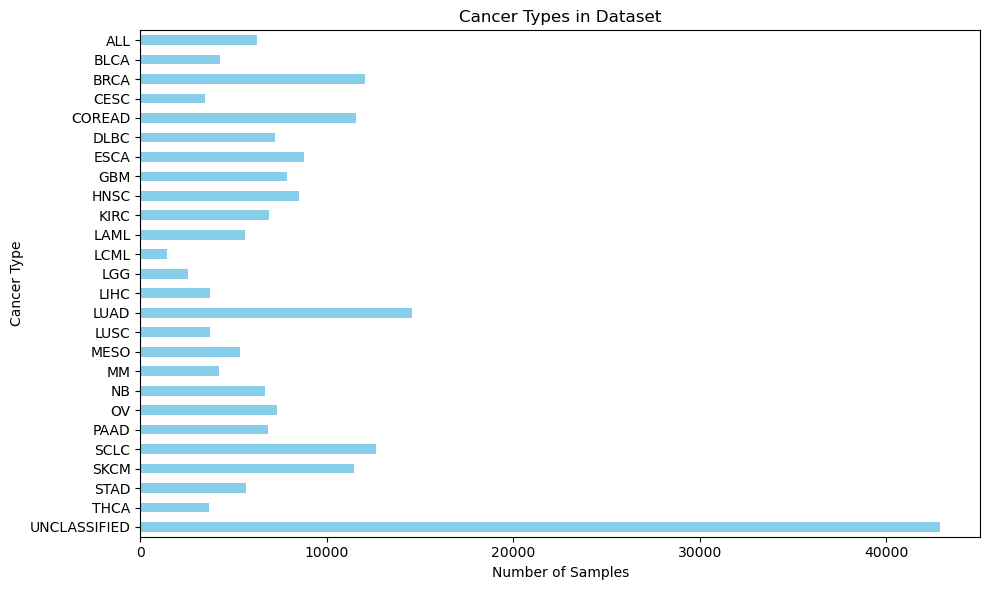

In [25]:
# Plot number of samples per cancer type stratified by drug_id if PROCESS_ALL_DRUGS = False
print("Plotting number of samples per cancer type stratified by drug_id...")

if not PROCESS_ALL_DRUGS:
    print("Plotting for the subset of drugs")
    # Create a crosstab of cancer_type and drug_id
    ct_drug_counts = pd.crosstab(df_filtered['cancer_type'], df_filtered['drug_id'])

    # Sort cancer types for consistent ordering
    ct_drug_counts = ct_drug_counts.sort_index(ascending=False)

    # Plot as a stacked horizontal bar chart
    ax = ct_drug_counts.plot.barh(
        stacked=True,
        figsize=(12, 8),
        colormap='tab20',
        xlabel="Number of Samples",
        ylabel="Cancer Type",
        title="Cancer Types in Dataset (Stratified by Drug ID)"
    )
    plt.legend(title='Drug ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig = ax.get_figure()
else:
    ax = df_filtered.cancer_type.value_counts().sort_index(ascending=False).plot.barh(
        title="Cancer Types in Dataset",
        xlabel="Number of Samples",
        ylabel="Cancer Type",
        figsize=(10, 6),
        color='skyblue'
    )
    fig = ax.get_figure()

plt.tight_layout()

#fig.savefig("results/number_samples_by_cancer_type.png")

plt.savefig( RESULTS_DIR / 'number_samples_by_cancer_type.png', dpi=300, bbox_inches='tight')
plt.show()

### Get total number of drug or patway by cancer combinations

In [26]:
num_drug_cancer_combos= df_filtered.groupby(['drug_id','cancer_type']).ngroups
print(f"Total number of unique drug_id and cancer_type combinations: {num_drug_cancer_combos}")


num_pathway_cancer_combos = df_filtered.groupby(['pathway','cancer_type']).ngroups
print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")

Total number of unique drug_id and cancer_type combinations: 6918
Total number of unique drug pathway and cancer_type combinations: 622


# 2: Data Splitting - Drug-Wise Stratified With Unseen Cell Line Split
To evaluate the ability of models to predict the ln_ic50 of unseen cell lines, the data will be split to ensure the test set has unseen cell lines for each drug.

## 2.1 Split Cell Lines into Training and Test Sets (80:20)

In [27]:
#  Data Splitting - Drug-Wise Stratified Unseen Cell Line Split ---
print("\n--- Starting Data Splitting ---")

# Identify Unique Cell Lines
unique_cell_lines = df_filtered['COSMIC_ID'].unique()
print(f"Total unique cell lines: {len(unique_cell_lines)}")

# # Split Cell Lines into Training and Test Sets (80:20)
gss = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=RANDOM_SEED)
train_idx, val_idx = next(gss.split(df_filtered, groups=df_filtered['COSMIC_ID']))

df_train = df_filtered.iloc[train_idx].copy()
df_val   = df_filtered.iloc[val_idx].copy()

# 2. Ensure every drug appears in validation
missing_drugs = set(df_filtered['drug_id']) - set(df_val['drug_id'])
if missing_drugs:
    print("Warning: these drugs are absent from validation", missing_drugs)



--- Starting Data Splitting ---
Total unique cell lines: 889


## 2.2: Add binary target for ln_ic50 for classification models
**NOTE:**
The threshold used to binarize the target ln_ic50 is based on the train data only and is applied to the validatand data set.  This is then used to train and evaluate classification models.


In [28]:
# Add binary targets to training and validation sets for classification models
# derive cut-off(s) from training dataset only
threshhold_per_drug = (
    df_train.groupby('drug_id')['ln_ic50']  # could use z_score
    .quantile(0.25) # 25% is most sensitive
    .to_dict()
    )

# save thresholds for later
joblib.dump(threshhold_per_drug, MODELS_DIR / "ln_ic50_binary_cutoffs_per_drug.pkl")

# make binary target labels for classifier models
for df in (df_train, df_val):
    df['binary_ln_ic50'] = df.apply(
        lambda r: int(r.ln_ic50 < threshhold_per_drug[r.drug_id]), axis=1
    )

# update target columns with binary_ln_ic50
cols_T = cols_T + ['binary_ln_ic50']


### Add global variables for continuos and binary ln_ic50

In [29]:
# Define features and target
TARGET_COLUMN_REG = 'ln_ic50'
TARGET_COLUMN_CAT = 'binary_ln_ic50'

TARGET_RELATED_FEATURES =  cols_T #['ln_ic50', 'auc', 'z_score', 'rmse', 'w'] # Exclude from training sets

## 2.3 Create Development Training and Validation DataFrames

### Set the target column
This emables evaluating ln_ic50, auc and z_score as targets.


In [30]:
df_filtered['drug_id'].nunique() 

286

In [31]:
# Create Training and Test DataFrames 

# make X_train/_y and test_X/y
#drop_cols_from_X = ['drug_id', 'COSMIC_ID'] + TARGET_RELATED_FEATURES
drop_cols_from_X =  TARGET_RELATED_FEATURES
print(f"Drop columns from X: {drop_cols_from_X}\n")

# Note: ['drug_id', 'COSMIC_ID']  will be dropped for X_train_use and X_val_use

# training data set
X_train = df_train.drop(columns=drop_cols_from_X).copy()


# Drop columns cols_C not in X_train
cols_C = [col for col in X_train.columns if col in cols_C]  # ensure core features are included

# setup y_train for regression and classification
y_train_reg = df_train[['drug_id', 'COSMIC_ID', TARGET_COLUMN_REG]].copy() # or 'auc' or 'zscore 
y_train_cat = df_train[['drug_id', 'COSMIC_ID', TARGET_COLUMN_CAT]].copy() # for classifier models

# # Get numeric and object columns for plotting
# numeric_cols = df_train.select_dtypes('number').columns.to_list()
# object_cols = df_train.select_dtypes('object').columns.to_list()
# #pprint(numeric_cols)

# validation dataset
X_val = df_val.drop(columns=drop_cols_from_X).copy()

# setup y_val for regression and classification
y_val_reg = df_val[['drug_id', 'COSMIC_ID', TARGET_COLUMN_REG]].copy() # for regression models (or use 'auc' or 'zscore)
y_val_cat = df_val[['drug_id', 'COSMIC_ID', TARGET_COLUMN_CAT]].copy() # for classifier models

# get weights (from RMSE) for training and validation sets
# These are used to weight the loss function during training
w_train = df_train['w'].copy().values.astype("float32")
w_val   = df_val['w'].copy().values.astype("float32")

feature_columns = X_train.columns
print(f"X_train shape: {X_train.shape}, y_train_reg shape: {y_train_reg.shape}")
print(f"X_val shape:   {X_val.shape},  y_test shape:       {y_val_reg.shape}")

#print(f"\nFeatures used for modeling:")
#pprint(feature_columns.to_list())


Drop columns from X: ['ln_ic50', 'auc', 'z_score', 'rmse', 'w', 'binary_ln_ic50']

X_train shape: (171761, 1213), y_train_reg shape: (171761, 3)
X_val shape:   (43502, 1213),  y_test shape:       (43502, 3)


### Confirm drugs are distributed across train and validation

In [32]:
# Verify Drug Coverage in Validation Set
# This is crucial to ensure "test set still contains potency measurements for each compound"
all_drugs = df_filtered['drug_id'].unique()
drugs_in_train = df_train['drug_id'].unique()
drugs_in_val   = df_val['drug_id'].unique()

missing_from_val   = set(all_drugs) - set(drugs_in_val)
missing_from_train = set(all_drugs) - set(drugs_in_train)

if len(missing_from_val) > 0:
    print(f"\nWARNING: The following drugs are MISSING from the VALIDATION set: {missing_from_val}")
    print("This means the random cell line split resulted in some drugs having no data in the validation set.")
    print("Consider re-running the split or adjusting the validation set if this is critical for all drugs.")
else:
    print("\nAll drugs are present in the Validation set. Good!")

if len(missing_from_train) > 0:
    print(f"\nWARNING: The following drugs are MISSING from the TRAINING set: {missing_from_train}")
    print("This is less common but indicates some drugs might only appear in the validation set.")
else:
    print("All drugs are present in the TRAINING set.   Good!")


All drugs are present in the Validation set. Good!
All drugs are present in the TRAINING set.   Good!


## 2.4 Check the distribution of cell lines in train and test by cell features

Is there a similar distribution of cell line types (tissue, cancer_type) in train and test

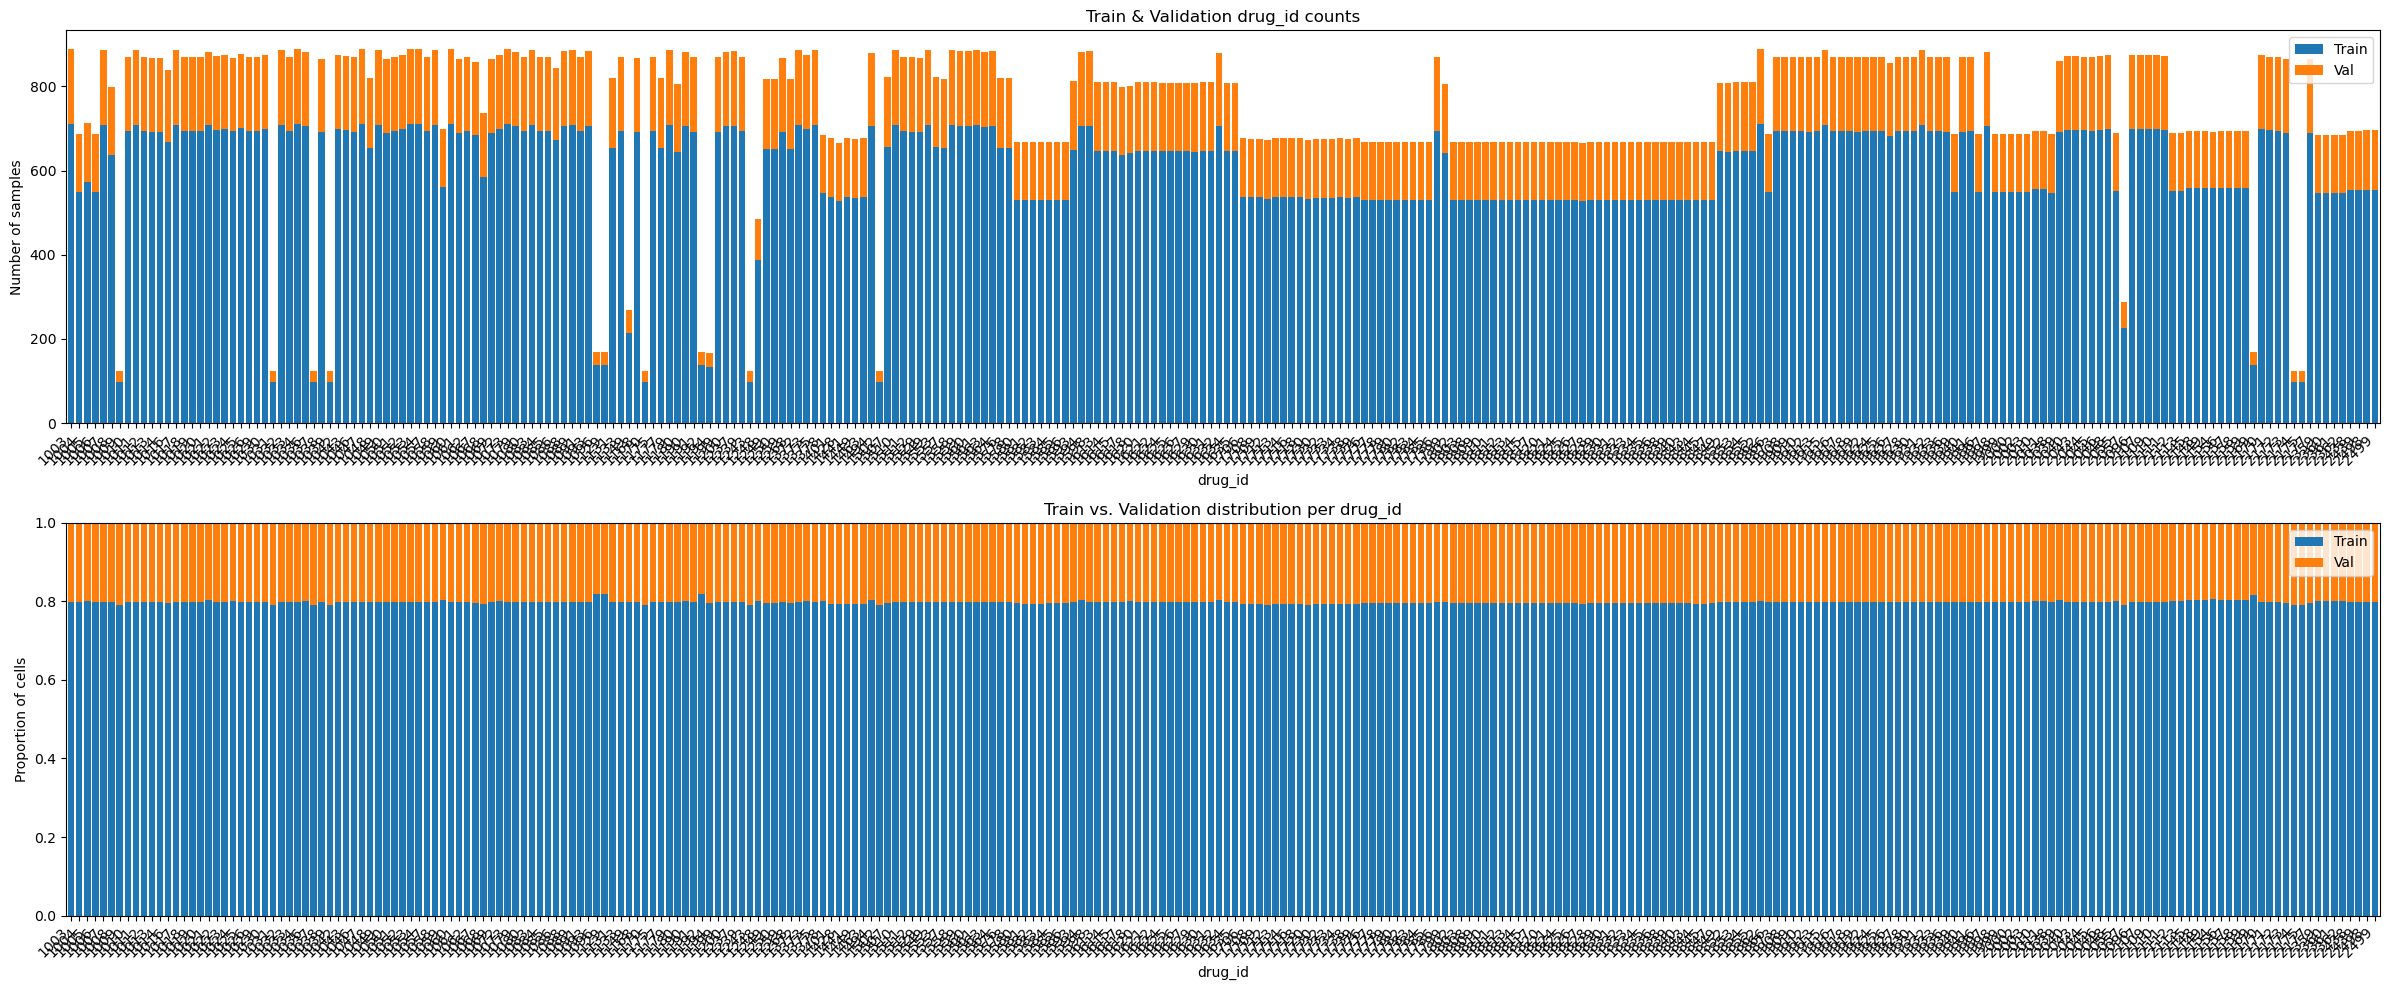

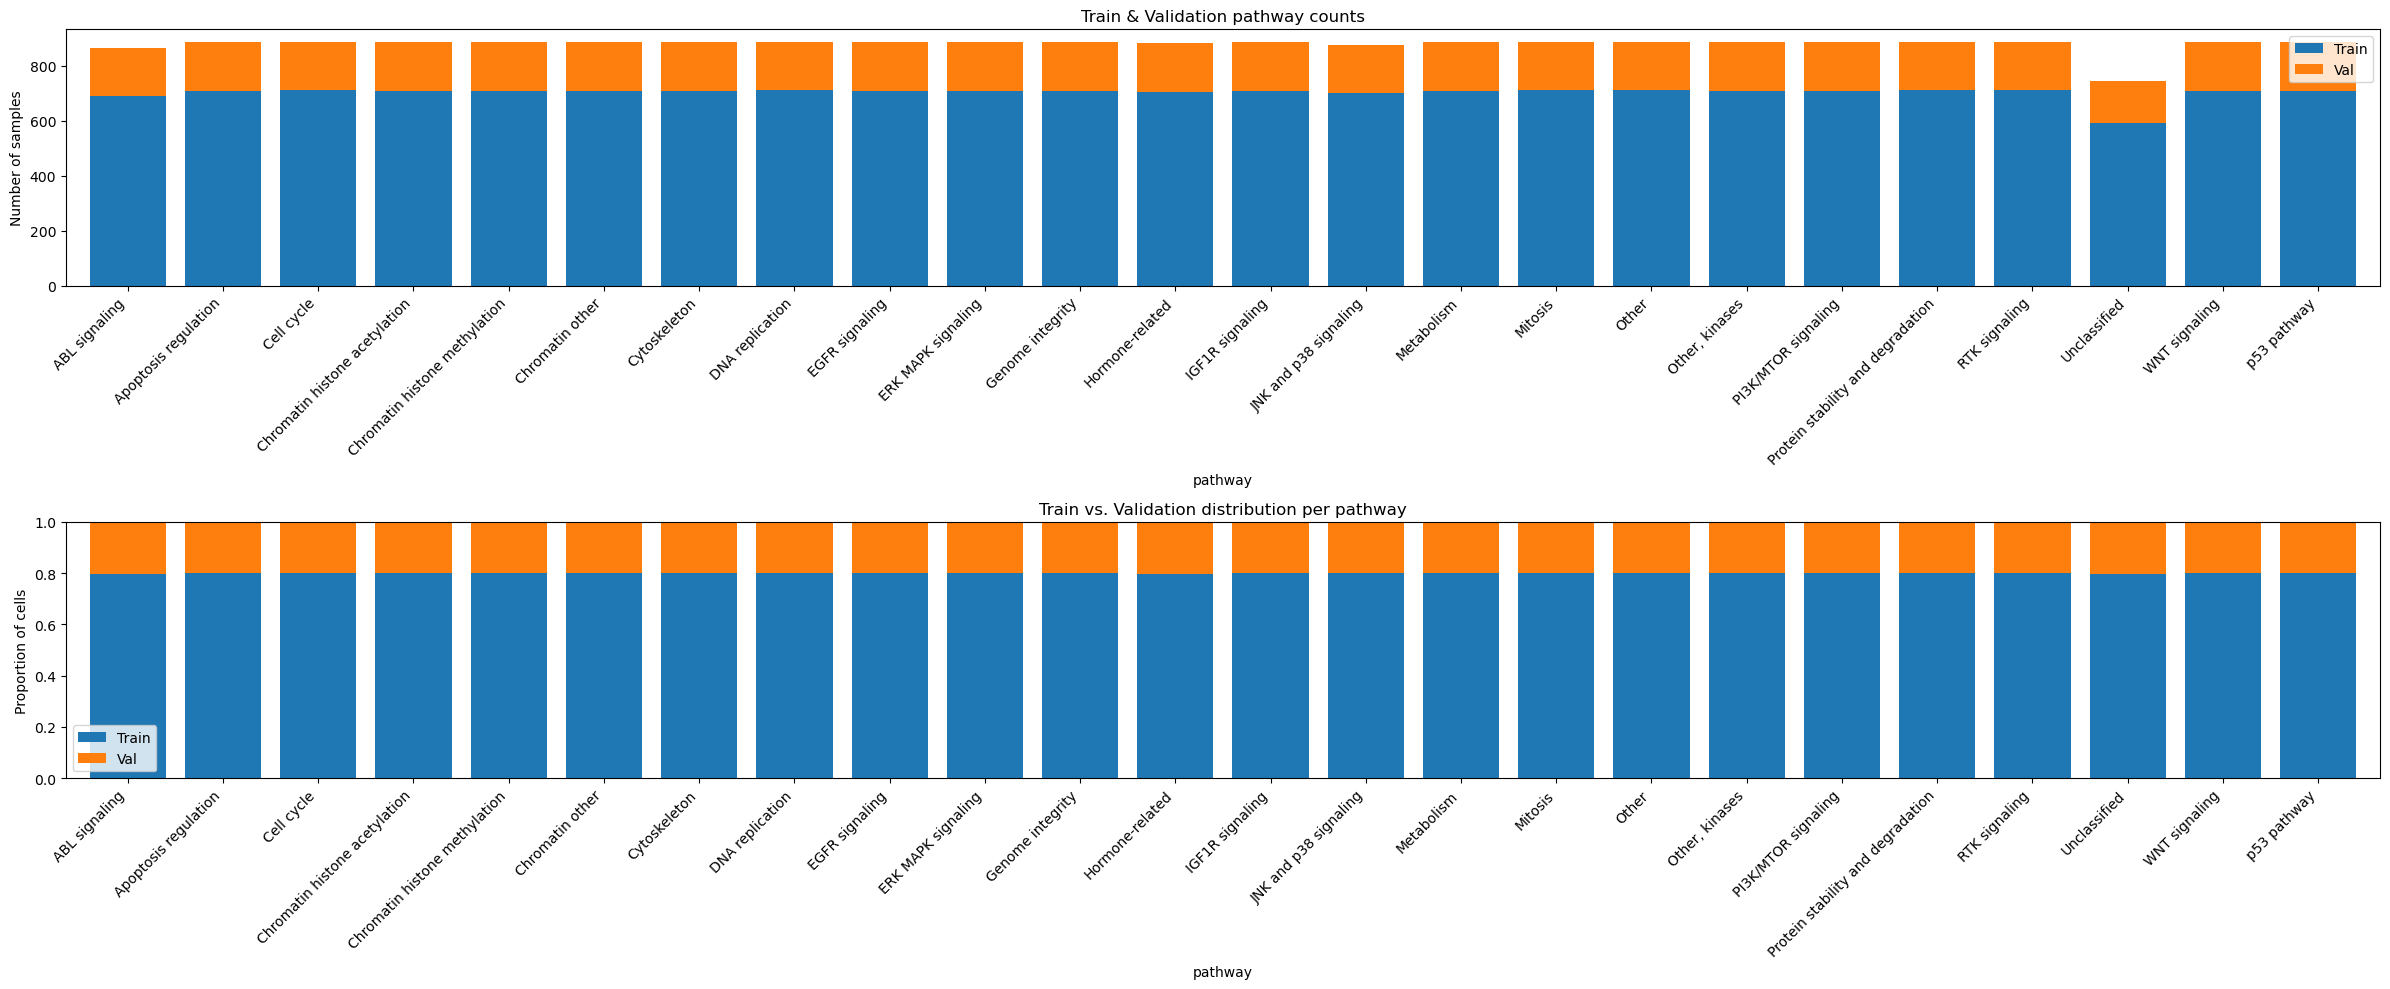

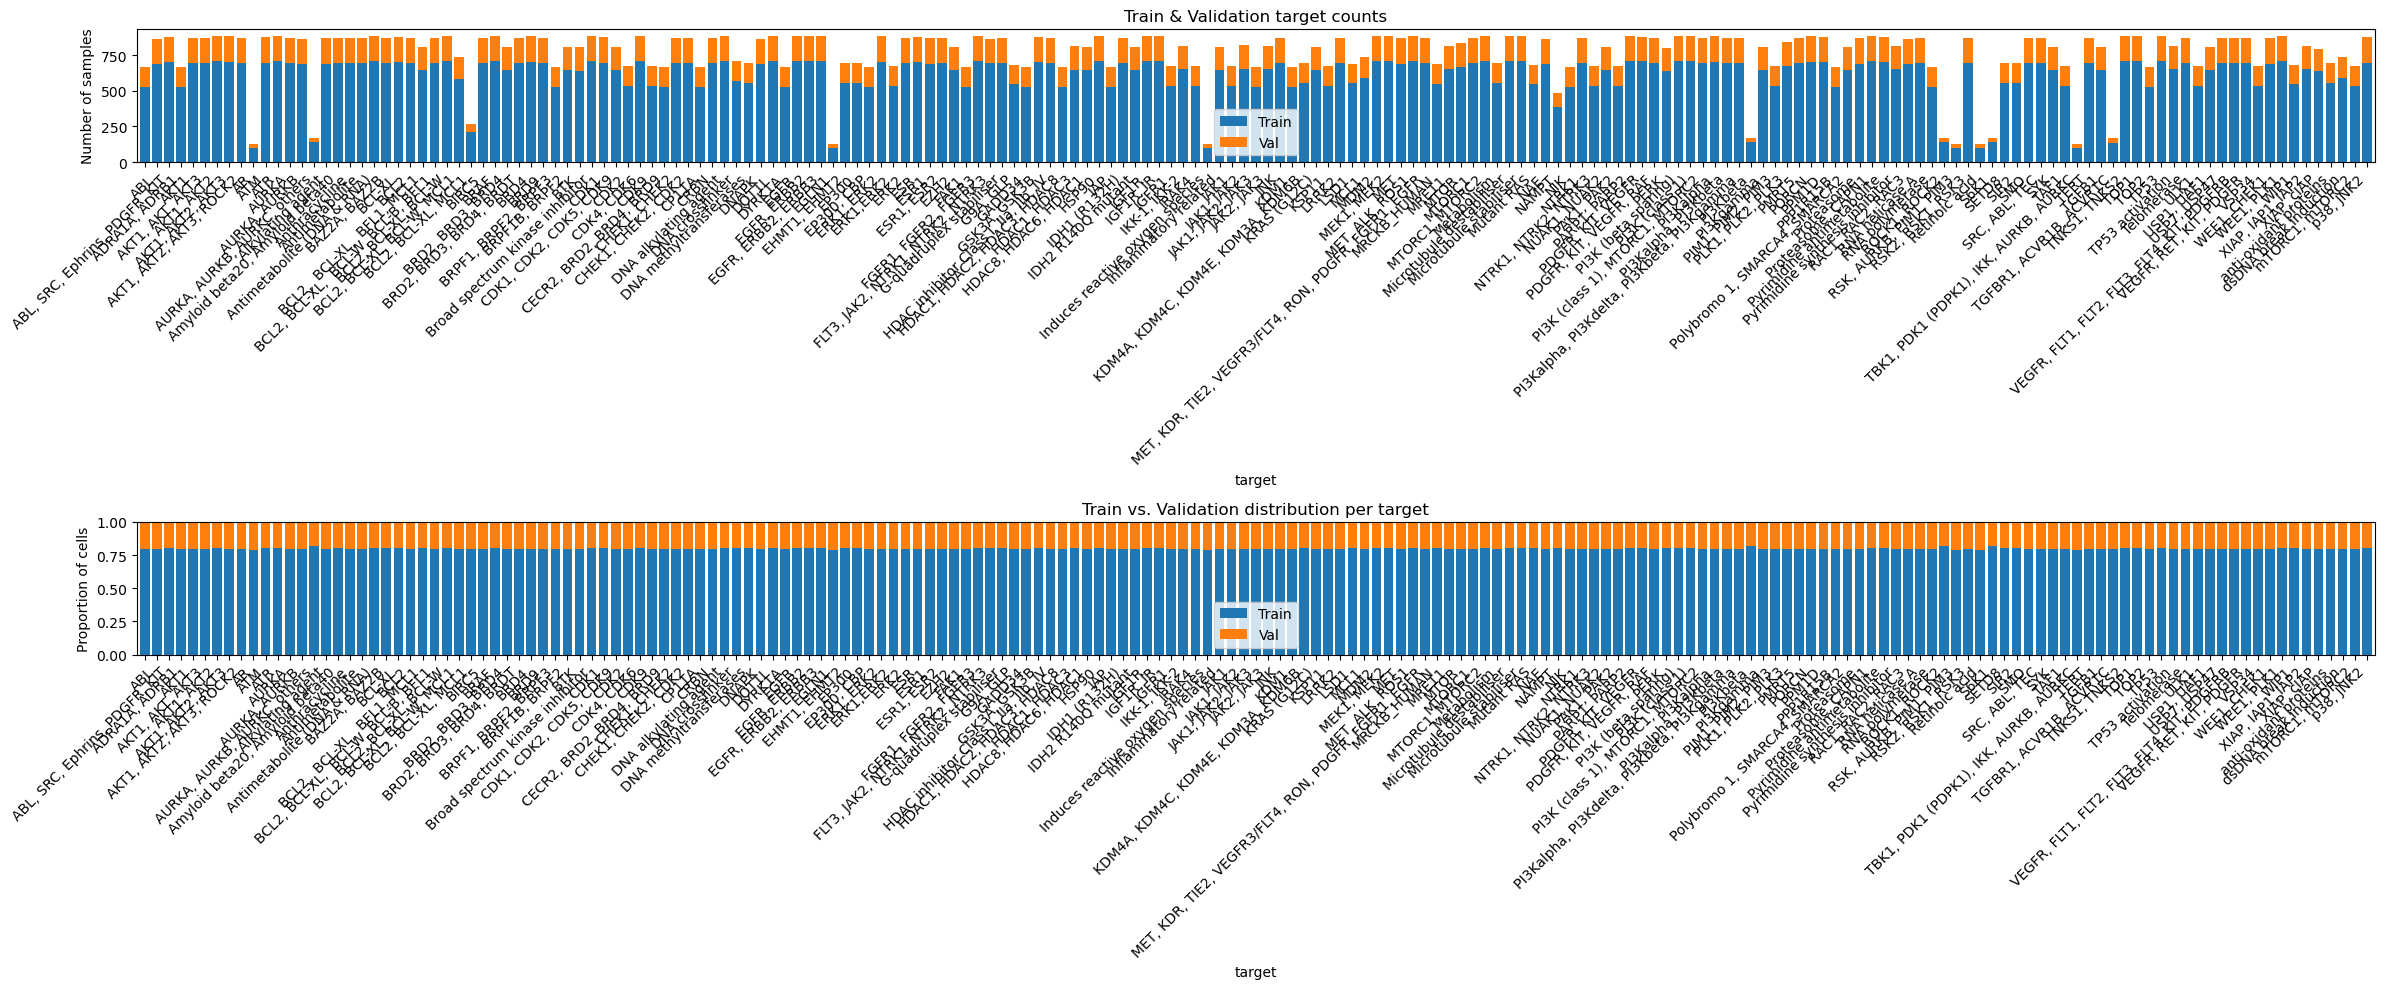

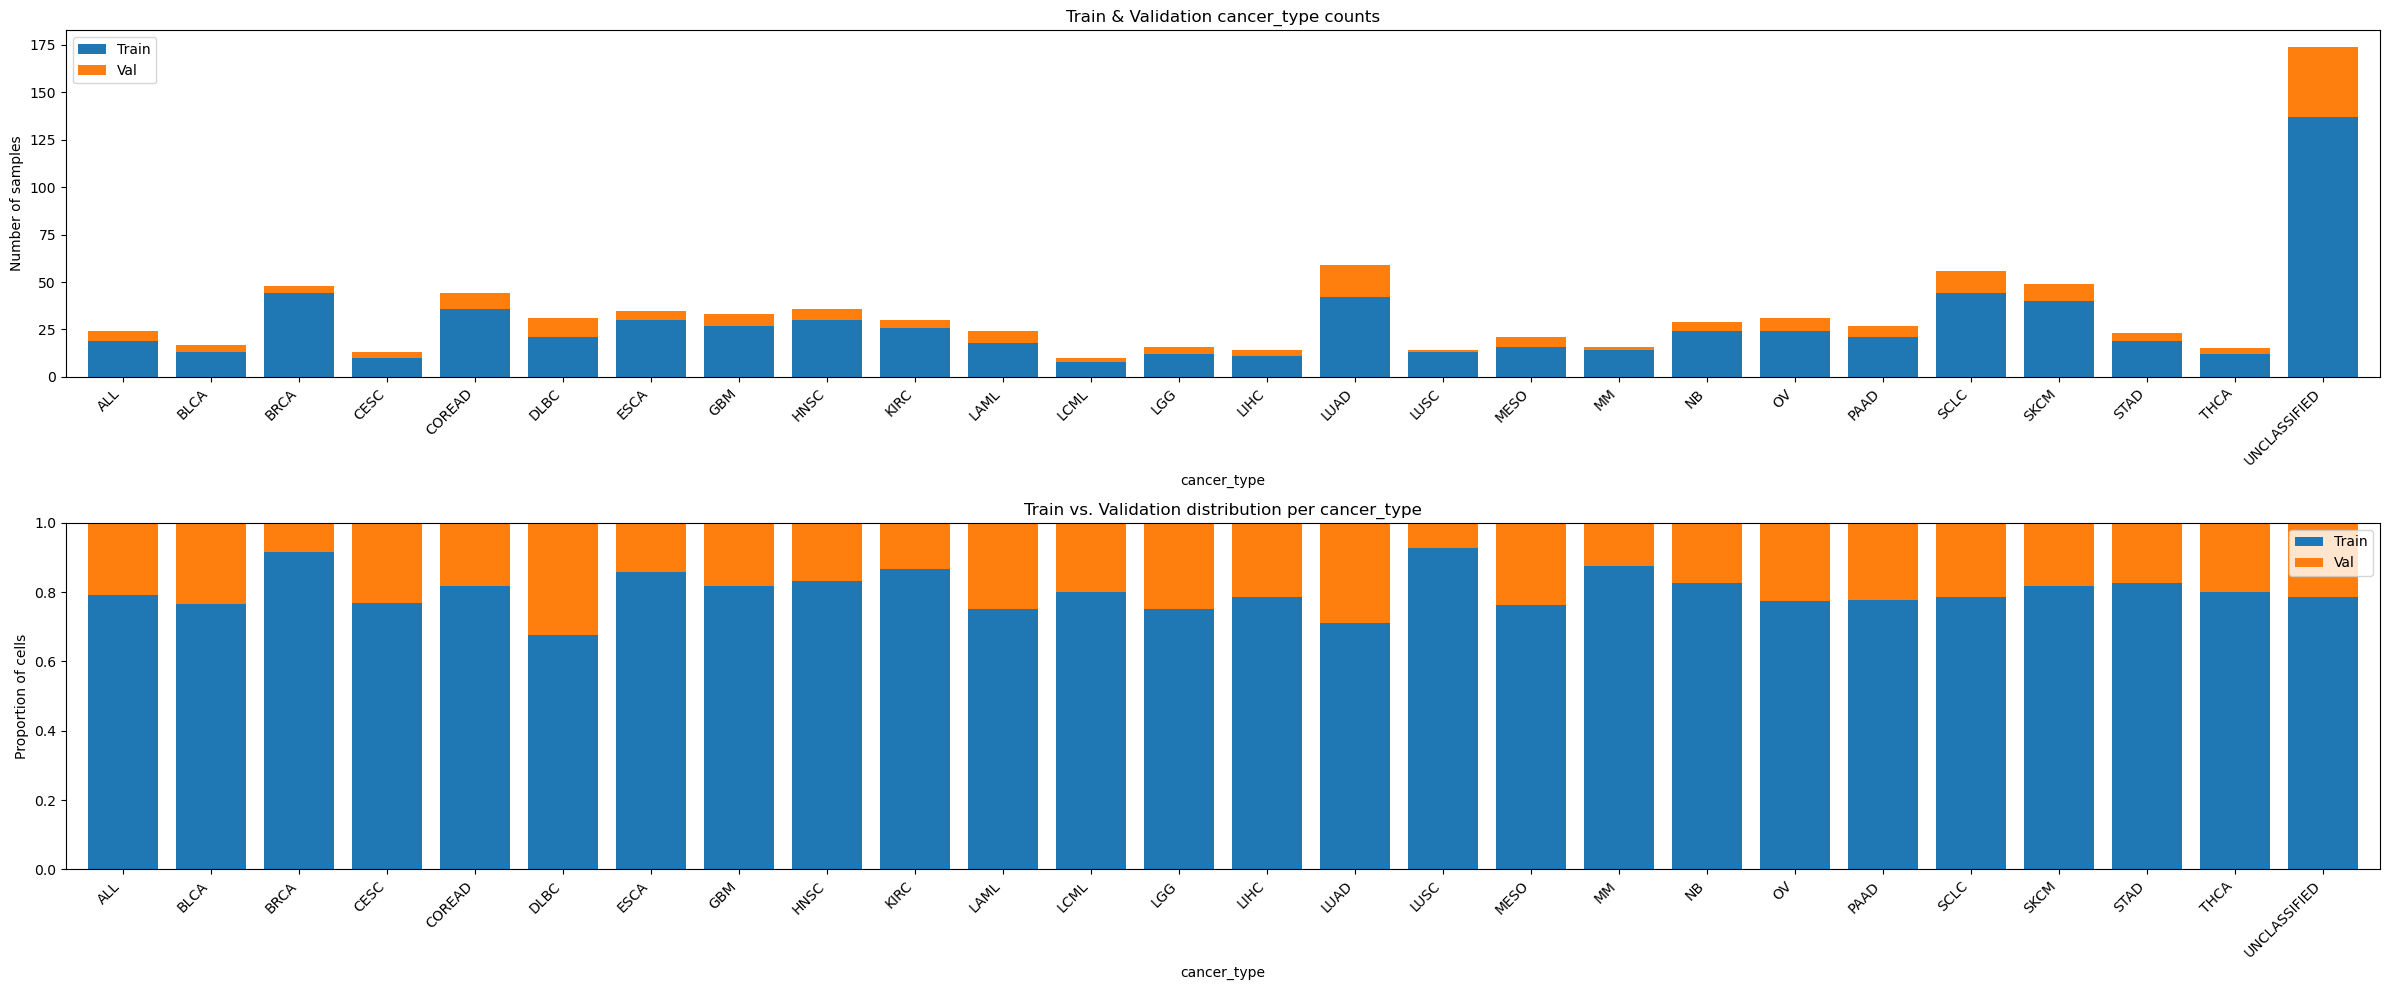

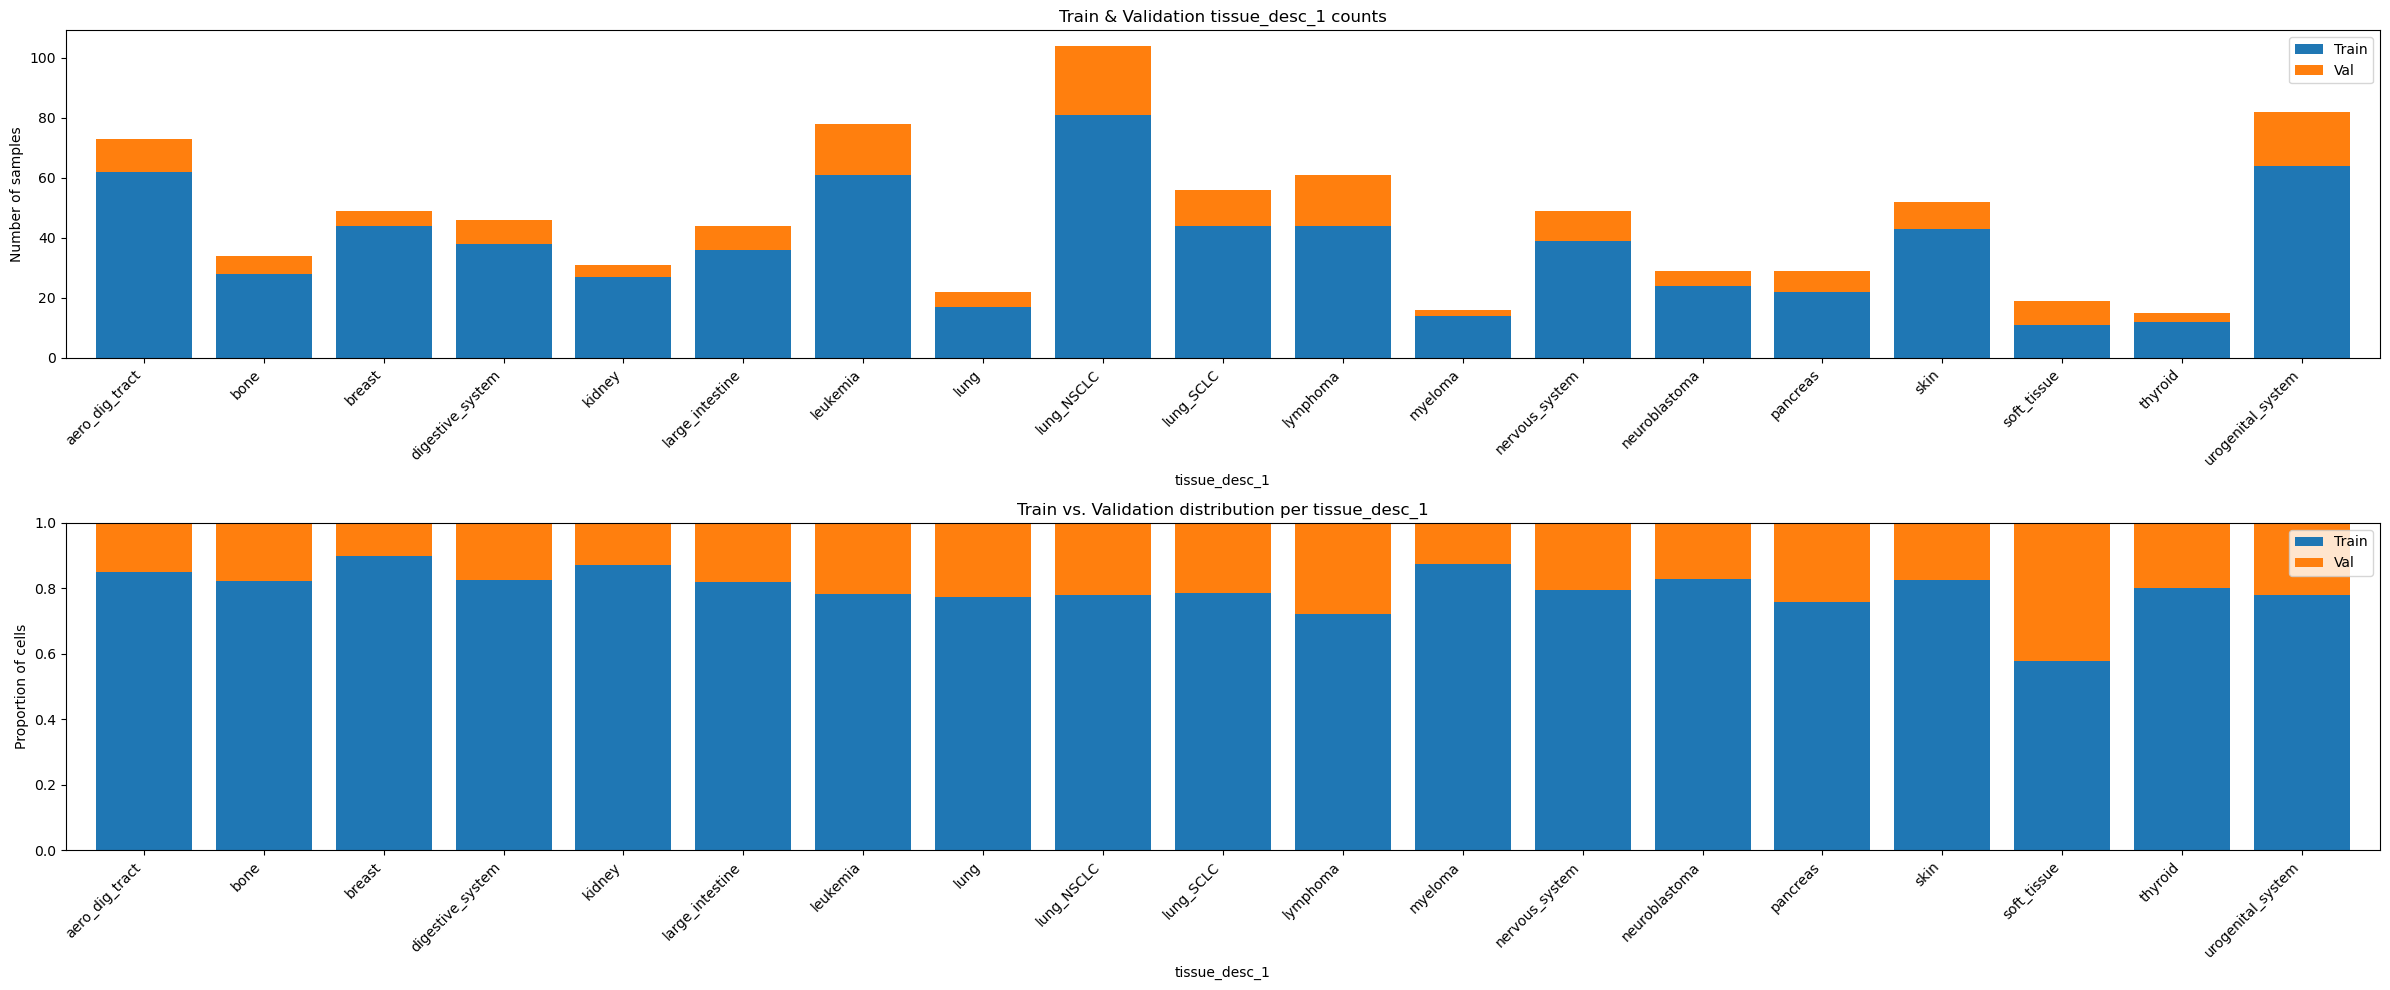

In [33]:
# Plot numbers and ratios for various features in train and test
feature_list = 'drug_id', 'pathway', 'target', 'cancer_type', 'tissue_desc_1'

for feature in feature_list:
    # Compute the distribution (absolute counts) in each set
    train_counts = df_train.groupby(feature)['COSMIC_ID'].nunique()
    val_counts   = df_val.groupby(feature)['COSMIC_ID'].nunique()

    # Right Plot: ratio of test:train / feature
    stacked_df = pd.DataFrame({
        'Train': train_counts,
        'Val':  val_counts
    })

    # nomalize by counts per each type 
    df_norm = stacked_df.div(stacked_df.sum(axis=1), axis=0)

    # Plot
    fig, axes = plt.subplots(nrows=2, figsize=(24, 10), sharey=False)

    # left: raw counts
    stacked_df.plot.bar(stacked=True, ax=axes[0], width=0.8)
    axes[0].set_title(f"Train & Validation {feature} counts")
    axes[0].set_ylabel("Number of samples")
    axes[0].legend()

    for lbl in axes[0].get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

    # right: normalized proportions
    df_norm.plot(kind='bar', stacked=True, ax=axes[1], width=0.8) #, color=['blue', 'red'])
    axes[1].set_title(f"Train vs. Validation distribution per {feature}")
    axes[1].set_ylabel("Proportion of cells")
    axes[1].set_ylim(0, 1)

    #axes[1].legend(title="Dataset", loc="upper right")
    #axes[1].tick_params(axis='x', rotation=45, labelsize='small')
    for lbl in axes[1].get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR /f"Split_distribution_by_{feature}", dpi=300, bbox_inches='tight')
    plt.show()


### Is there an unbalanced number of cancer types per tissue_desc_1?

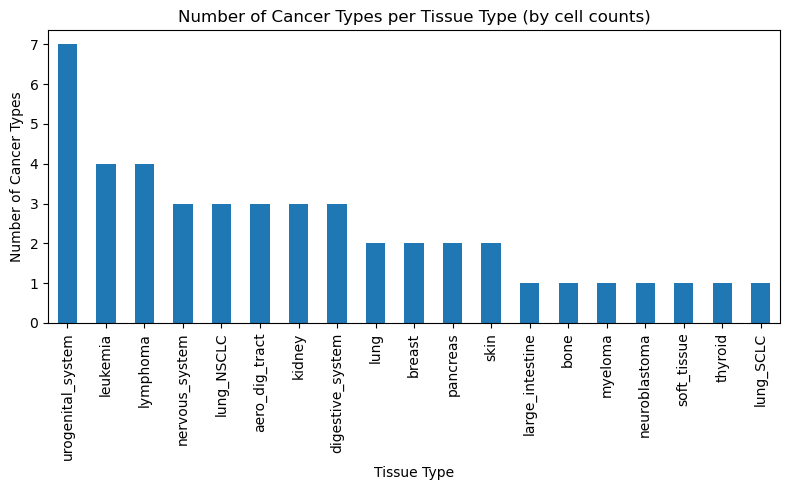

In [34]:
# Count unique cancer types per tissue type (by cell counts)
ct_per_cell  = df_merged.drop_duplicates('COSMIC_ID').set_index('COSMIC_ID')['cancer_type']
td1_per_cell = df_merged.drop_duplicates('COSMIC_ID').set_index('COSMIC_ID')['tissue_desc_1']

# Combine into a DataFrame
cell_info = pd.DataFrame({'tissue_desc_1': td1_per_cell, 'cancer_type': ct_per_cell})

# Group by tissue type and count unique cancer types
cancer_types_per_tissue = cell_info.groupby('tissue_desc_1')['cancer_type'].nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
cancer_types_per_tissue.plot(kind='bar')
plt.ylabel('Number of Cancer Types')
plt.xlabel('Tissue Type')
plt.title('Number of Cancer Types per Tissue Type (by cell counts)')
plt.tight_layout()
plt.show()


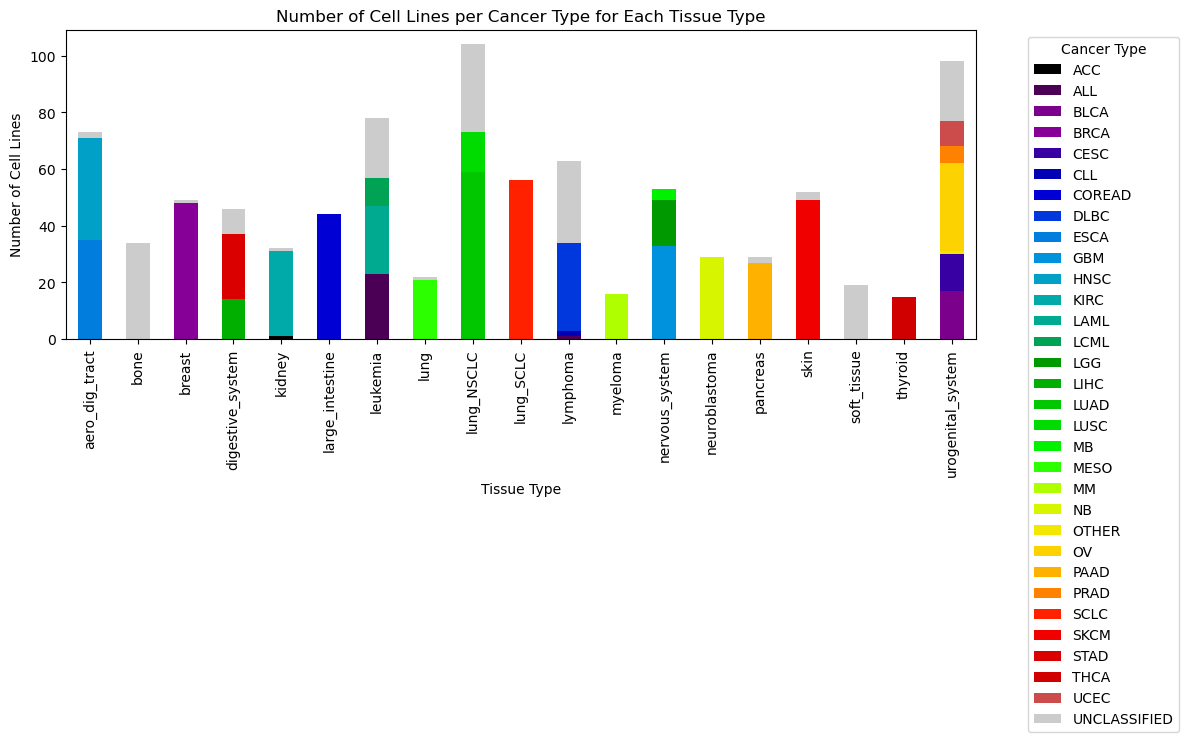

In [35]:
# For each tissue_desc_1, plot a stacked bar of the number of cell lines per cancer_type

# 1) Get the first value of each feature per COSMIC_ID
cell_info = df_merged.drop_duplicates('COSMIC_ID').set_index('COSMIC_ID')[['tissue_desc_1', 'cancer_type']]

# 2) Create a crosstab: rows=tissue_desc_1, columns=cancer_type, values=counts of cell lines
ctab = pd.crosstab(cell_info['tissue_desc_1'], cell_info['cancer_type'])

# 3) Plot as stacked bar
ctab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='nipy_spectral') #'gist_ncar') #'tab20b') #'tab20')
plt.ylabel('Number of Cell Lines')
plt.xlabel('Tissue Type')
plt.title('Number of Cell Lines per Cancer Type for Each Tissue Type')
plt.legend(title='Cancer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**INTERPRETATION:**

There zre multiple dimensions to the imbalance of the data with respect to number of cells per cancer and tissue type. 
- imbalance in the number of cells per cancer type.
- imbalance in the number of cancers per tissue type
- imbalance in the number of samples per a tissue type.

The data will not be balanced for training.

In the future, Explore wehter removal of unclassified cancer type impacts the model performance.

### How does the binary cuttoff compare to continuous ln_50, auc and z_score (in total and by drug) across all drugs?

Is there a significant overlap in continuos ln_50 across drugs for the binary ln_50?


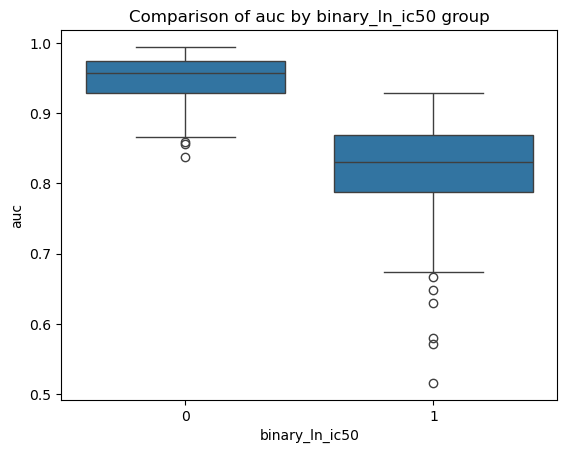

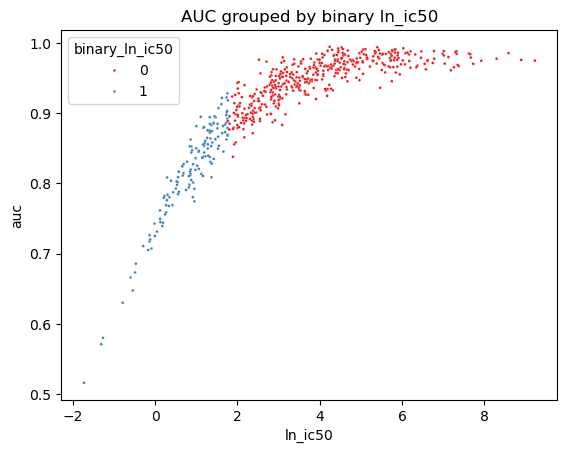

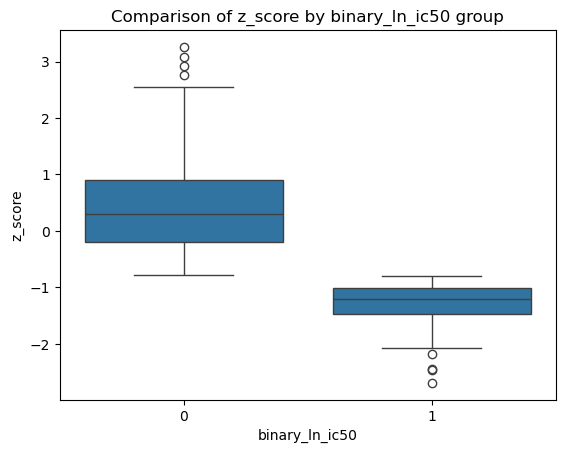

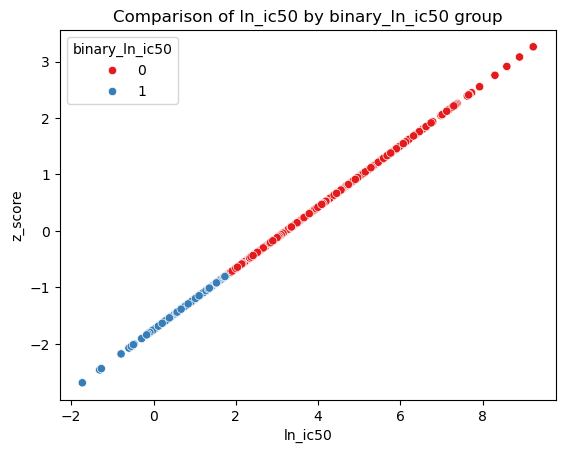

In [36]:
## plot binary_ln_ic50 by drug_id
# Filter for a specific drug_id, e.g., 1008

df_plot = df_train[df_train['drug_id'] == 1005]

# cmopare
xval='binary_ln_ic50'
yval='auc'
sns.boxplot(x='binary_ln_ic50', y='auc', data=df_plot)
plt.title("Comparison of auc by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

# df_merged.plot.scatter(x='ln_ic50', y='z_score')
xval='ln_ic50'
yval='auc'
sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50',  s=4,  data=df_plot, palette='Set1')
plt.title("AUC grouped by binary ln_ic50")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()



# Plot z_score distributions for each binary_ln_ic50 group on the same plot
xval='binary_ln_ic50'
yval='z_score'
sns.boxplot(x='binary_ln_ic50', y='z_score', data=df_plot)
plt.title("Comparison of z_score by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

xval='ln_ic50'
yval='z_score'
sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50', data=df_plot, palette='Set1')
plt.title("Comparison of ln_ic50 by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()


### Is there ambiguity in the binary_ln_ic5o 0-1 cuttoff on a per drug basis?
Plot will show that half of the drugs have > x% of samples in the ambiguous zone (overlap) between 0-1. And what the standard de

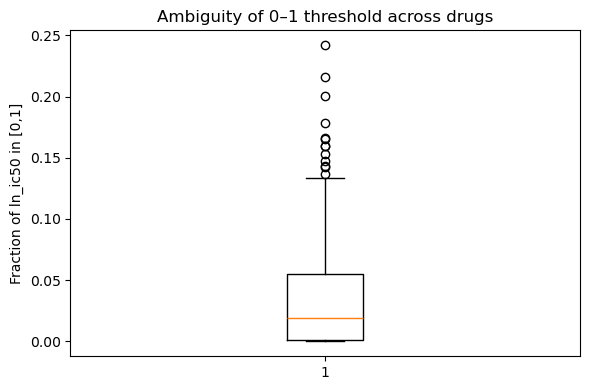

In [37]:
# compute overlap fraction per drug
def overlap_frac(g):
    mask = (g['ln_ic50'] >= 0.5) & (g['ln_ic50'] <= 1)
    return mask.sum() / len(g)

overlap = df_merged.groupby('drug_id').apply(overlap_frac)

# box-plot the distribution across drugs
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(overlap.values)
ax.set_ylabel("Fraction of ln_ic50 in [0,1]")
ax.set_title("Ambiguity of 0–1 threshold across drugs")
plt.tight_layout()
plt.show()

In [38]:
# ## IGNORE

# ### Calculate Cohen's d for each drug
# # Cohen's d is a measure of effect size that indicates the standardized difference between two means.
# # Here, we will calculate Cohen's d for the ln_ic50 values, comparing the lower
# def cohens_d(g):
#     s = g['ln_ic50']
#     thr = s.quantile(0.25)
#     low, high = s[s<thr], s[s>=thr]
#     n1, n2 = len(low), len(high)
#     # pooled std
#     s_pooled = np.sqrt(((n1-1)*low.std()**2 + (n2-1)*high.std()**2) / (n1+n2-2))
#     return (high.mean() - low.mean()) / s_pooled

# d_scores = df_merged.groupby('drug_id').apply(cohens_d)
# d_scores.describe()

**Interpretation:**
- even split 80:20 across values of drug related features
- uneven split across values of cell related cancer type and tissue descriptions. 
- There is a very small overlap in ln_50 across drugs at the cuttoff of 0/1 threshold for binary seperation

Next:
- Future study: Try splitting based on cell features (not to be done in this study)
- Should the cancers be combined into other if below a specific fequency? 

## 2.4 Evaluate distribution of target metrics in train and validation datasets

### Plot binary distribution of target

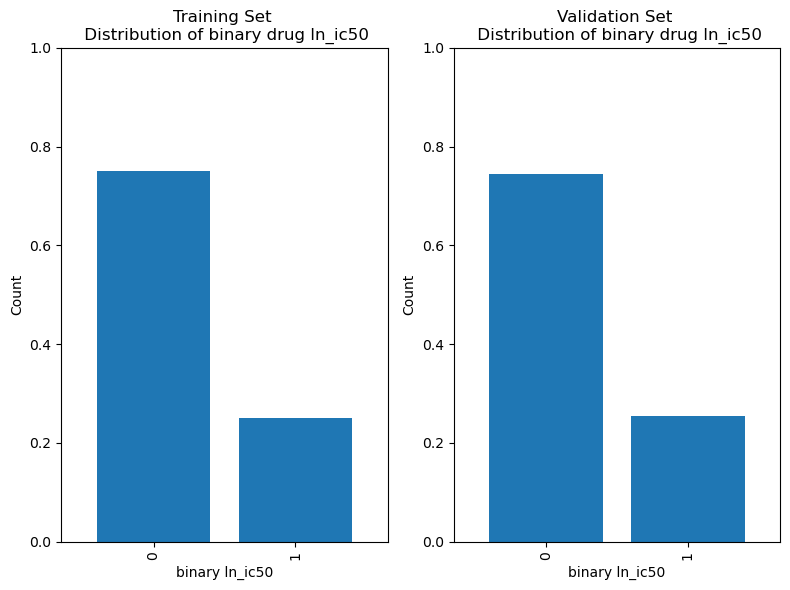

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))

train_pct = df_train[TARGET_COLUMN_CAT].value_counts(normalize=True)
train_pct.plot(kind='bar', stacked=False, ax=ax[0], width=0.8,  ylim=(0, 1) )
ax[0].set_title("Training Set \n Distribution of binary drug ln_ic50")
ax[0].set_xlabel("binary ln_ic50")
ax[0].set_ylabel("Count")

val_pct = df_val[TARGET_COLUMN_CAT].value_counts(normalize=True)
val_pct.plot(
    kind='bar', stacked=False, ax=ax[1], 
    width=0.8, ylim=(0, 1)
    )

ax[1].set_title("Validation Set \n Distribution of binary drug ln_ic50")
ax[1].set_xlabel("binary ln_ic50")
ax[1].set_ylabel("Count")
#plt.savefig(RESULTS_DIR / 'binary_ln_ic50_train_dist.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Plot distribution of continuos target and associated columns

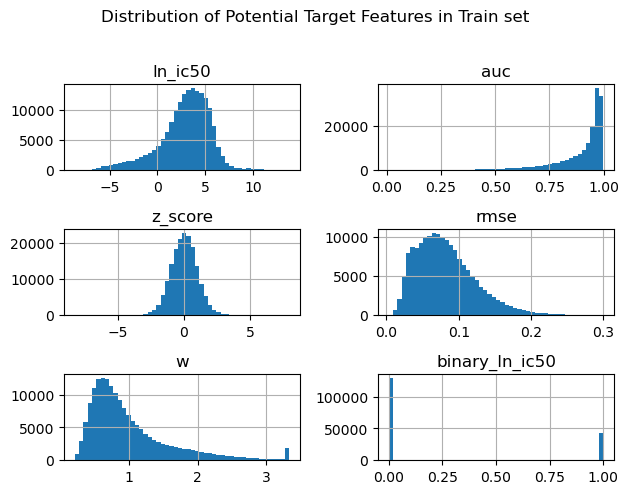

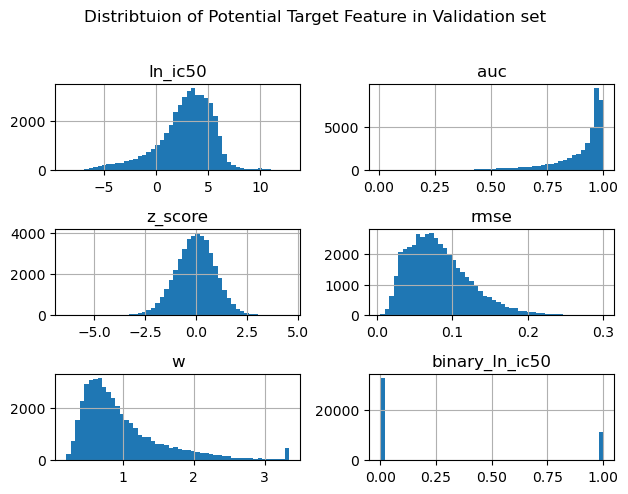

In [40]:
df_train.hist(column=TARGET_RELATED_FEATURES, bins=50)
plt.suptitle('Distribution of Potential Target Features in Train set', y=1.02)
plt.tight_layout()
plt.show()


df_val.hist(column=TARGET_RELATED_FEATURES, bins=50)
plt.suptitle('Distribtuion of Potential Target Feature in Validation set', y=1.02)
plt.tight_layout()
plt.show()


### Explore skew in continous ln_ic50

In [41]:
# Print metrix for ln_ic50
display(df_train['ln_ic50'].describe().round(3))

count    171761.000
mean          2.868
std           2.718
min          -8.643
25%           1.557
50%           3.261
75%           4.716
max          13.820
Name: ln_ic50, dtype: float64

### How does the application of RMSE weight impact the ln_ic50 distribution?

count    572.000
mean       3.049
std        2.465
min       -0.986
25%        1.226
50%        2.657
75%        4.137
max       16.781
Name: normalized, dtype: float64

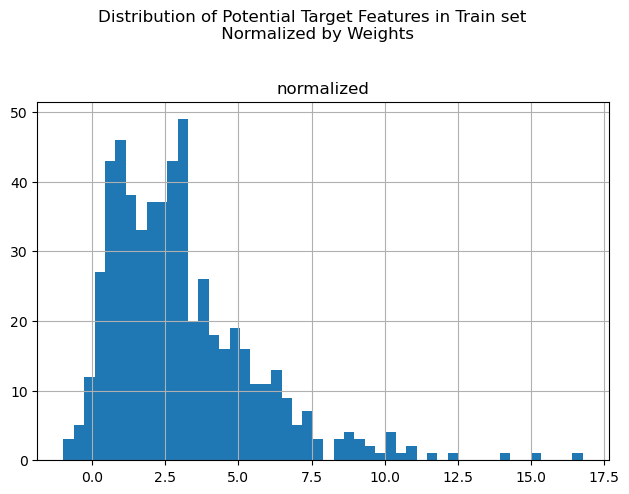

In [42]:
# distribution of weighted ln_ic50 during training
df_plot['normalized'] = df_train['ln_ic50'] * df_train['w']
display(df_plot['normalized'].describe().round(3))

df_plot.hist(column='normalized', bins=50)
plt.suptitle('Distribution of Potential Target Features in Train set \n Normalized by Weights', y=1.02)
plt.tight_layout()
plt.show()



**INTERPRETATION:**
- The ln_ic50 is skewed right. 
- Normalization of the ln_ic50 with the rmse derived weights does enough normalizaiton not to warent normalization ahead of NN model training.

Next:
- Models other than neural networks (NN) do not need normalization of the ln_ic50
- The neural network model will likely do better with normalized target ln_ic50, so normalization will be implemented.

# 3. Baseline Models
Get baseline performance for a Linear and Dummy model to compare optimized models to.

## 3.0 Set up metric capture for model evaluations

### Setup tracking of model evaluatoin information
- df_models_eval: capture metrics in table (AUC, RMSE, ACCURACY, etc .....)
- df_bounds: Capture lower, upper, quantial information in a table.

In [43]:
# Initiate df_models_eval for capturing model performance metrics
df_models_eval = evaluate_model()
#print_df_markdown(df_models_eval)

# track calcualated bounds for each numeric  feature analyzed
df_bounds = pd.DataFrame(columns=[
    'feature', 'lower', 'upper', 'q1', 'q3', 'iqr'
    ])

# Initiate df_model_info for capturing model information
# This will be used to store information about each model trained
df_model_info   = pd.DataFrame({
    'model_name': [],
    'model_type': [],
    'task_type':  [],
    'feature_set': [],
    'target_column': [],
    'train_data_X':  [],
    'train_data_y':  [],
    'val_data_X': [],
    'val_data_y': [],
    'train_sample_weights': [],
    'val_sample_weights': [],
    'model_description': []
    })

# Initiate a dictionary for storing each model - this may be used for drug-cancer specific prediciton
# input information is stored in df_models_info
models_dict = { }

## 3.1: Feature Preprocesser for Baseline Models

Baseline models will use the core features from GDSC (cols_C).  Additional features from methylation, mutation and expression will be added (and impact evaluated) during advanced model training and evaluation.

Note: there are no numeric features in the core feature set.  Preprocessor will be setup 

### Create Baseline preprocessor

In [44]:
## --- Feature Preprocessing for Baseline Model ---
# Create preprocessing pipelines for numerical and categorical features

# Specify columns to use for preprocessing and modeling
cols_use = cols_C
name_cols_used = 'cols_C' # Keep track of which columns are used for modeling

preprocessor_cols_C = get_preprocessor(X_train, cols_use=cols_C)
print(f"Preprocessor created for columns: {name_cols_used}")


# setup X_train and X_val data with the col_use
X_train_use  = X_train[cols_use]
X_val_use    = X_val[cols_use]


# 
print(f'cols_use: {cols_use}')

Preprocessor created for columns: cols_C
cols_use: ['pathway', 'target', 'cancer_type', 'growth_properties', 'tissue_desc_1', 'tissue_desc_2', 'msi']


## 3.2 Baseline Dummy Model


In [45]:
# Baseline Model 1: Dummy Regressor (Predicts the mean)

## -- edit this section per model --

# Model information
model_name = 'dummy_regressor_pipe'
model_type = 'DummyRegressor'
task_type = 'regresion'
model_description = 'Baseline Dummy Regressor predicting mean value'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg
val_data_y_name = 'y_val_reg'
pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---


# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)

# Create pipeline
dummy_regressor_pipe = Pipeline([
    ('prep', preprocessor_cols_C),
    ('model', DummyRegressor(strategy="mean"))
])

# Train the Model
start_time = time.time()
dummy_regressor_pipe.fit(X_train_use, y_data_train)
train_time = time.time() - start_time

# Save amd Evalaute the model
model_to_eval = dummy_regressor_pipe  # EDIT FOR EACH PIPELINE

print("Save model\n")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate the Model
# df_models_eval = evaluate_model(
#     model_to_eval, model_name, 'Train', X_train_use, y_data_train,  
#     df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
# ) # Train

# df_models_eval = evaluate_model(
#     model_to_eval, model_name, 'Test', X_val_use, y_data_val, 
#     df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
# ) # Test

# print("\n")
# print(f"Model evaluation for {model_type}: {model_name} completed.")
# print_df_markdown(df_models_eval)

Save model



['/Users/brianr/repos/UCBAIML-GDSC-Capstone/models/dummy_regressor_pipe.pkl']

## 3.3: LGBMRegressor Baseline Model

Save model


| Model Info                           | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model) | Train   | regression   |  0.975 |      0.735 |        0.46 |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC (baseline model) | Test    | regression   |  0.077 |      0.729 |        0.46 |    0.355 |   0.401 |      nan |  1.538 | 1.171 | 0.683 |     0.828 |      0.75  |


Model evaluation for LGBMRegressor: LGBMRegressor: GDSC Baseline completed.

Predicution column: LGBMRegressor: GDSC Baseline_y_pred


Total number of unique drug pathway and cancer_type combinations: 622


Number of drug pathway-cancer combos with 

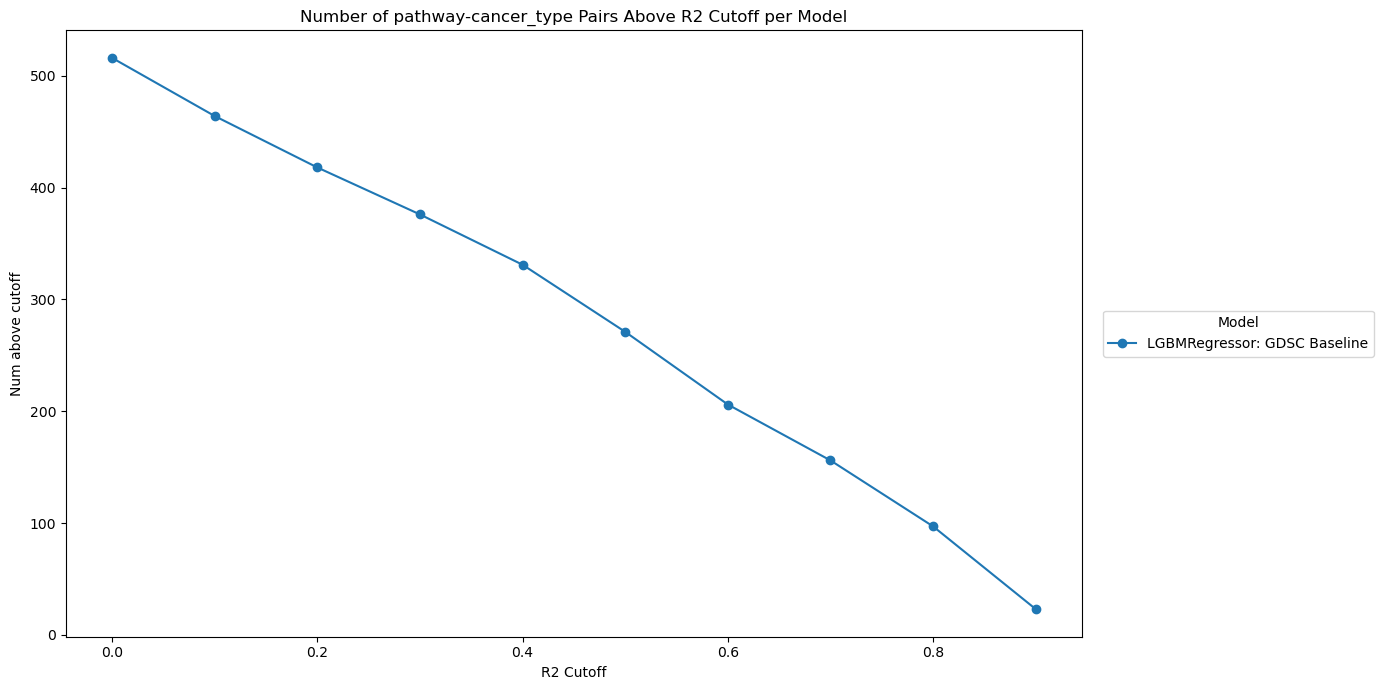

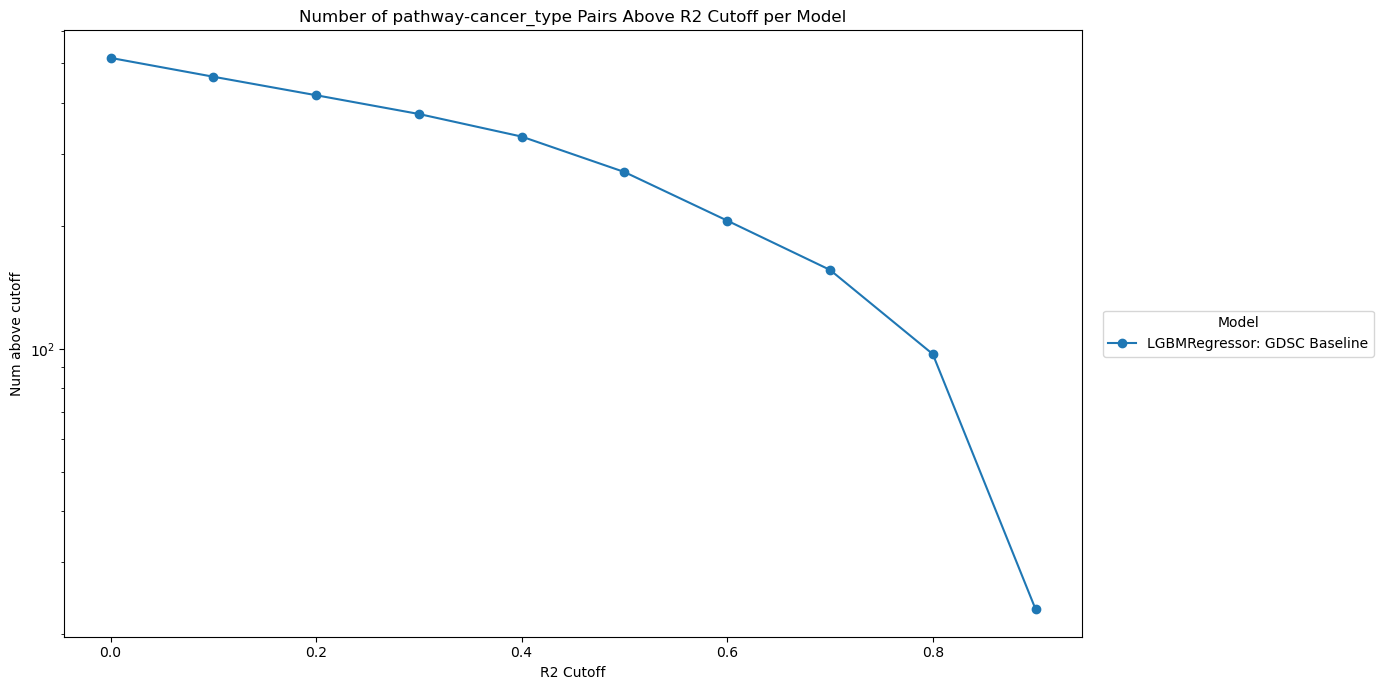

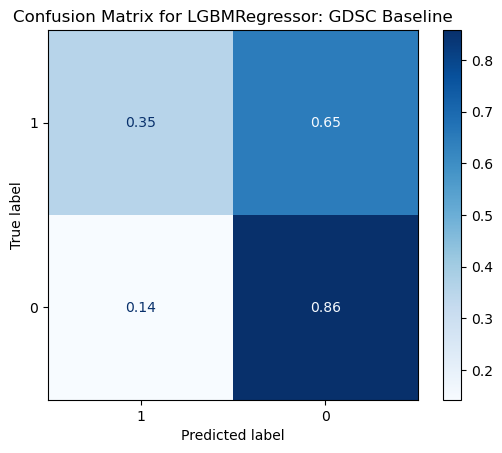

Plot y capped at -1 to 1 for Mean R2


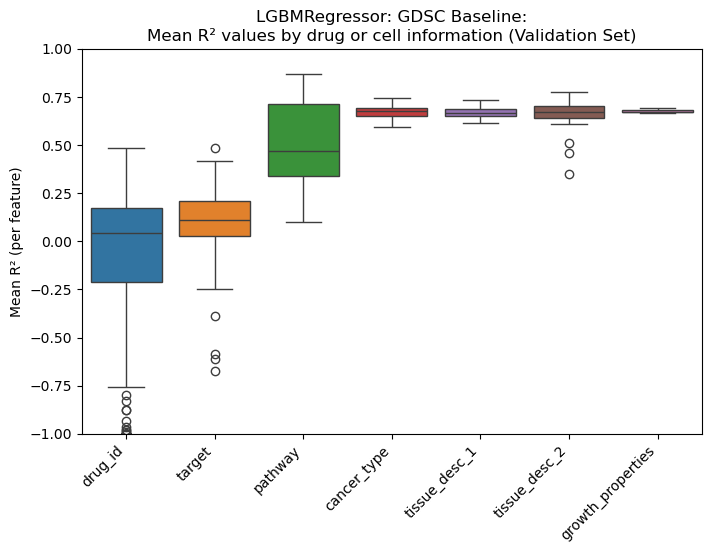

In [46]:
# Baseline Model: LGBMRegressor 


## -- edit this section per model --

# Model information
model_name = 'LGBMRegressor: GDSC Baseline'
model_type = 'LGBMRegressor'
task_type  = 'regression'
model_description = 'LGBMRegressor: GDSC (baseline model)'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train      = y_train_reg[TARGET_COLUMN_REG]
train_data_y_name = 'y_train_reg'
y_data_val        = y_val_reg[TARGET_COLUMN_REG]
val_data_y_name   = 'y_val_reg'
pos_label         = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---

# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)

lgb_gpu_params = [

]
if NVIDIA_GPU:
    lgb_base = lgb.LGBMRegressor(
        objective="rmse",
        metric="rmse",
        device='gpu',           # use the GPU 
        gpu_platform_id=0,      
        gpu_device_id=0,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )
else:
    lgb_base = lgb.LGBMRegressor(
        objective="rmse",
        metric="rmse",
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=0
    )

# Setup Pipeline
pipe = NamedPipeline(
    model_name,
    [
        ('pre', preprocessor_cols_C),
        ('model',lgb_base)
    ]
)

# Fit the model to the training data
start_time = time.time()
pipe.fit(X_train_use, y_data_train)
train_time = time.time() - start_time


# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe # EDIT FOR EACH PIPELINE

print("Save model")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
    (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print_model_metrics(df_models_eval, df_model_info)

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")

# print_df_markdown(df_models_eval)
print(f"\nPredicution column: {pred_col}")

print("\n")
# Get top drug-cancer R2 per model
r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
print("\n")
print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
#df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)

print("\n")


print("\n")
df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, [model_name], 
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
fig_1.savefig(RESULTS_DIR / f"{model_name}_combo_r2_lineplot.png")
fig_1.show()

# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()


## 3.5 Save Baseline data and info to .h5 file

In [47]:
# Write dataa into one .h5 file
with pd.HDFStore(MODELS_DIR / '04_modeling_datasets_baseline.h5', mode='w') as store:
    store['df_model_info'] = df_model_info
    store['df_models_eval'] = df_models_eval
    store['df_merged'] = df_merged
    store['df_filtered'] = df_filtered
    store['df_train'] = df_train
    store['df_val']  = df_val
    store['X_train'] = X_train
    store['X_val']   = X_val
    store['y_train_reg'] = y_train_reg
    store['y_val_reg']   = y_val_reg
    store['y_train_cat'] = y_train_cat
    store['y_val_cat']   = y_val_cat
    store['w_train_series'] = pd.Series(w_train)
    store['w_val_series'] = pd.Series(w_val)


## 3.6: Visualization of Base model performance

In [48]:
print("Model Information:")
print_model_metrics(df_models_eval, df_model_info)

Model Information:
| Model Info                           | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model) | Train   | regression   |  0.975 |      0.735 |        0.46 |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC (baseline model) | Test    | regression   |  0.077 |      0.729 |        0.46 |    0.355 |   0.401 |      nan |  1.538 | 1.171 | 0.683 |     0.828 |      0.75  |


### Plot of performance

#### compare models in y y plots labeling them by both wrong, 1-wrong, 2-wrong, both right

In [49]:
# Collect R² values for each drug in the validation set
def plot_r2_per_drug(y_real, y_pred, model_name=None):
    r2_by_drug = []
    for drug_id in df_val['drug_id'].unique():
        idx = df_val['drug_id'] == drug_id
        if idx.sum() > 1:  # Need at least 2 samples to compute R²
            r2 = r2_score(y_real[idx], y_pred[idx])
            r2_by_drug.append(r2)

    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(r2_by_drug, bins=60, kde=True)
    plt.xlabel("R² (per drug)")
    plt.ylabel("Count")
    plt.title(f"{model_name}: Histogram of R² values by drug (Validation Set)")
    plt.show()

In [50]:
print_model_metrics(df_models_eval, df_model_info, 'Train')
print("\n")

print_model_metrics(df_models_eval, df_model_info, 'Test')

| Model Info                           | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model) | Train   | regression   |  0.975 |      0.735 |        0.46 |     0.34 |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |


| Model Info                           | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model) | Test    | regression   |  0.077 |    

### Plot metrics for baseline model


--- Baseline Model Summary ---

LGBMRegressor: LGBMRegressor: GDSC Baseline y_val_data: y_val_reg


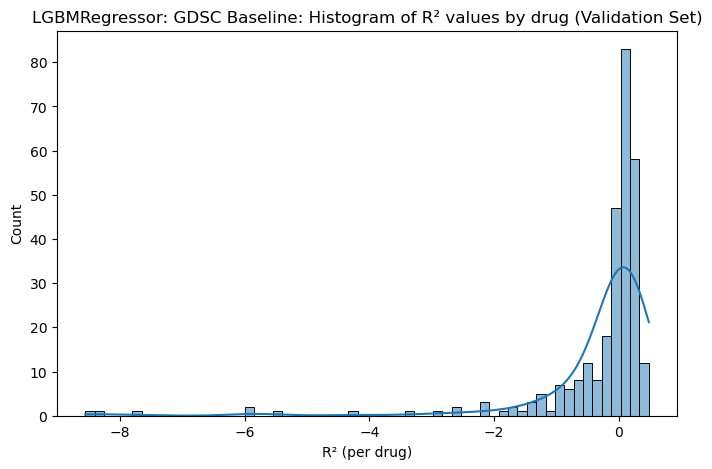

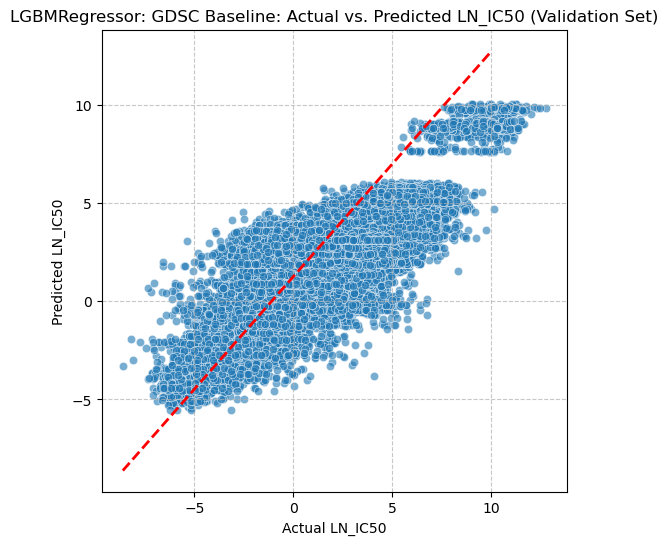

Plot y capped at -1 to 1 for Mean R2


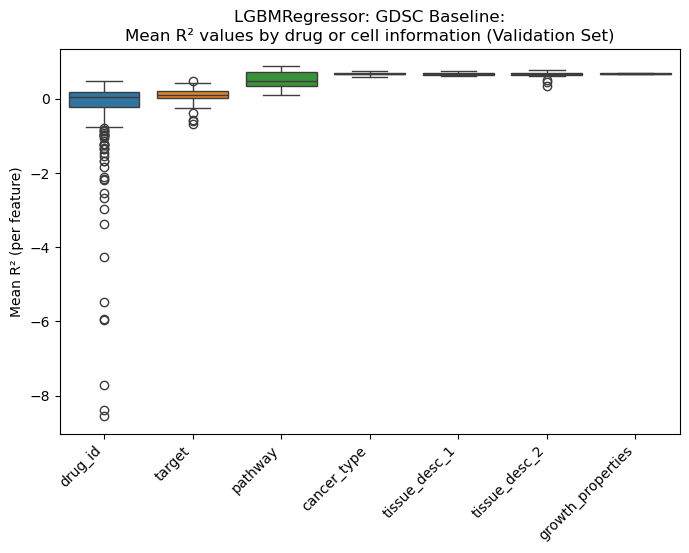

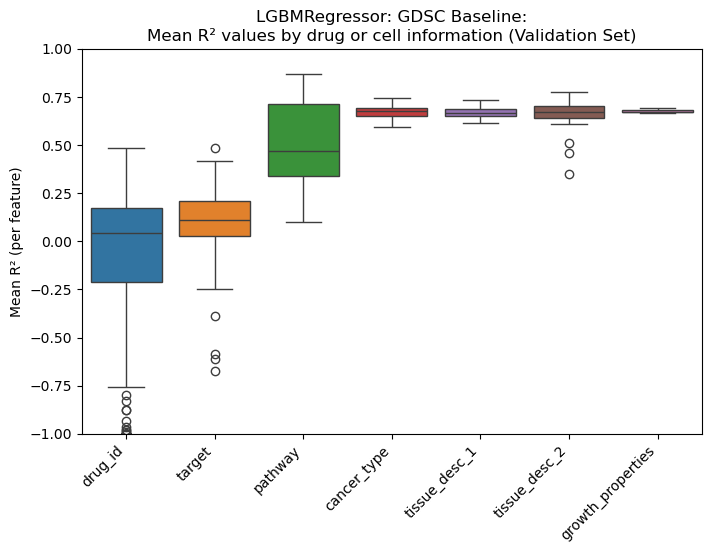

In [51]:
print("\n--- Baseline Model Summary ---")

model_name_1 = 'LGBMRegressor: GDSC Baseline'
model_to_eval_1 = models_dict[model_name_1]

y_pred_1 = model_to_eval_1.predict(X_val)
#y_pred_2 = model_to_eval_2.predict(X_val)


model_type_1 = df_model_info['model_type'][df_model_info['model_name'] == model_name].iloc[0]
val_data_y = df_model_info['val_data_y'][df_model_info['model_name'] == model_name].iloc[0]
print(f"\n{model_type}: {model_name} y_val_data: {val_data_y}")

# # raw coefficients:
# print(model_to_eval['model'].coef_)

# BAR TODO: Add stratification by pathway  drug

if val_data_y == 'y_val_reg':
    # plot scatter for linear predictions
    plot_r2_per_drug(y_val_reg[TARGET_COLUMN_REG], y_pred_1, model_name=model_name)
    plot_scatter_relationship(y_val_reg[TARGET_COLUMN_REG], y_pred_1, title=f"{model_name}: Actual vs. Predicted LN_IC50 (Validation Set)")
    plot_r2_by_feature(df_val, y_val_reg[TARGET_COLUMN_REG], y_pred_1, model_name=model_name)#, floor=-20)
    print("Plot y capped at -1 to 1 for Mean R2")
    plot_r2_by_feature(df_val, y_val_reg[TARGET_COLUMN_REG], y_pred_1, floor=-1, model_name=model_name)

**INTERPRETATION:**

The mean R2 of models improves when binned by cell traights as compared to drug traights.

### Evaluate feature importance of the baseline model

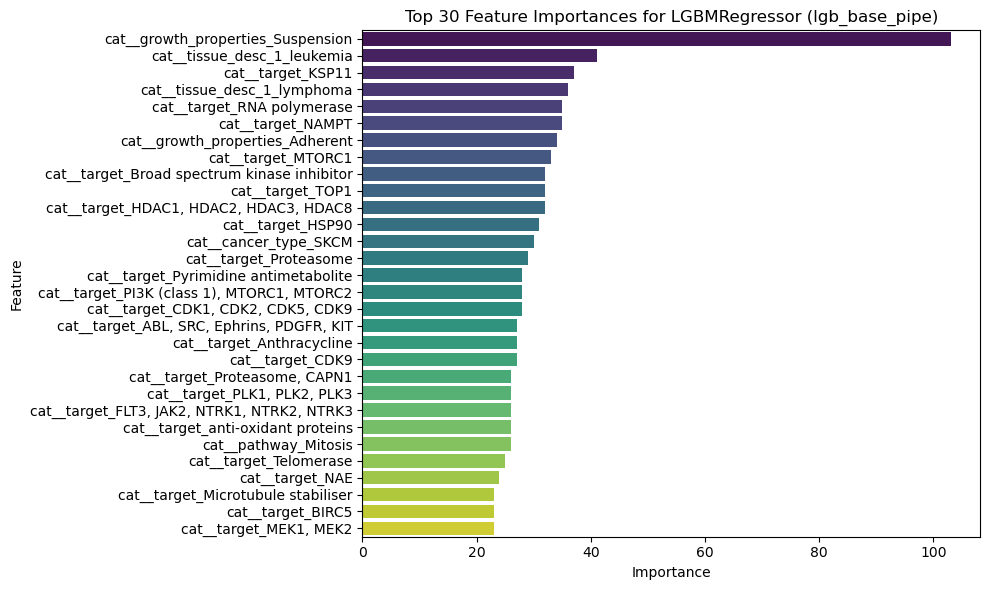

In [52]:
# Plot feature importance for lgb_base_pipe model
model_name = 'LGBMRegressor: GDSC Baseline'
model_use = models_dict[model_name]
preprocessor = model_use.named_steps['pre']

# Get feature names after preprocessing
cat_features = preprocessor.transformers_[1][2]
feature_names = (
    preprocessor.transformers_[1][1]['onehot']
    .get_feature_names_out(cat_features)
    if hasattr(preprocessor_cols_C.transformers_[1][1]['onehot'], 'get_feature_names_out')
    else cat_features
)
all_feature_names =  list(cat_features) if len(preprocessor.transformers_[0][2]) == 0 else []
all_feature_names += list(feature_names)


# Get feature importances from the model
importances = model_use.named_steps['model'].feature_importances_

# If the number of importances matches the number of features after preprocessing
if len(importances) == len(model_use .named_steps['pre'].get_feature_names_out()):
    all_feature_names = model_use .named_steps['pre'].get_feature_names_out()

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(30), x='importance', y='feature', palette='viridis')
plt.title('Top 30 Feature Importances for LGBMRegressor (lgb_base_pipe)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

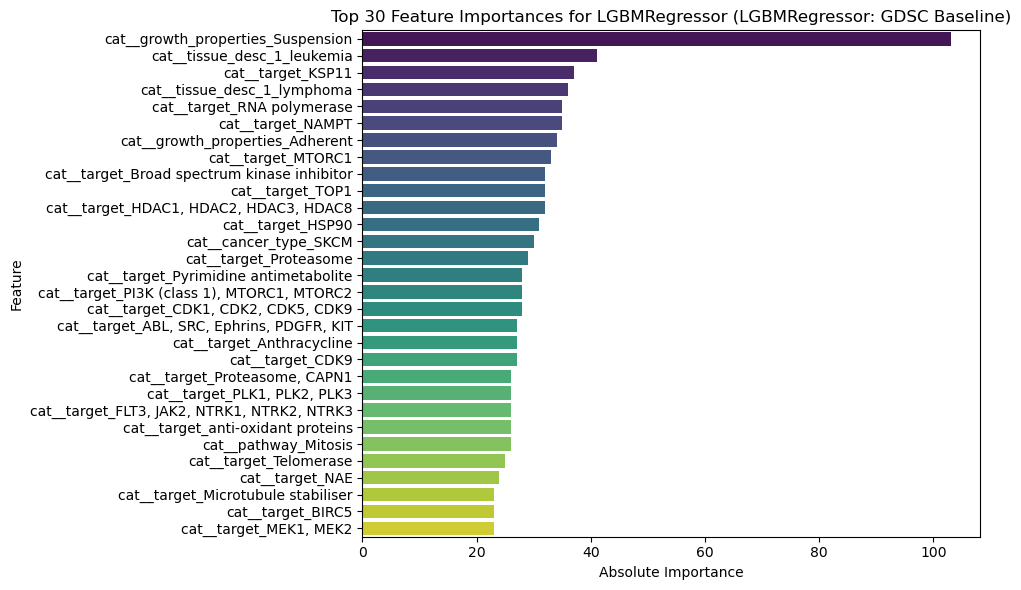

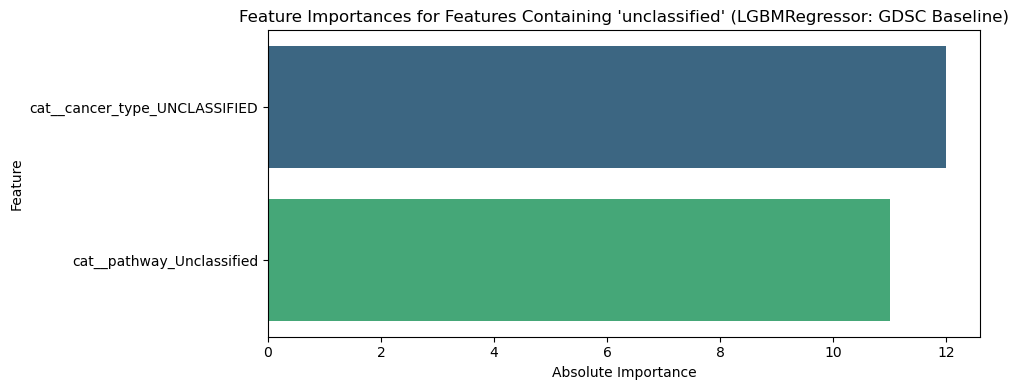

In [53]:
# Plot top 30 feature importances by absolute value for lgb_base_pipe model

# Get feature names after preprocessing
cat_features = preprocessor.transformers_[1][2]
feature_names = (
    preprocessor.transformers_[1][1]['onehot']
    .get_feature_names_out(cat_features)
    if hasattr(preprocessor_cols_C.transformers_[1][1]['onehot'], 'get_feature_names_out')
    else cat_features
)
all_feature_names = list(cat_features) if len(preprocessor_cols_C.transformers_[0][2]) == 0 else []
all_feature_names += list(feature_names)

# Get feature importances from the model
importances = model_use.named_steps['model'].feature_importances_

# If the number of importances matches the number of features after preprocessing
if len(importances) == len(model_use.named_steps['pre'].get_feature_names_out()):
    all_feature_names = model_use.named_steps['pre'].get_feature_names_out()

# Create a DataFrame for plotting (absolute value)
feat_imp_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})
feat_imp_df['abs_importance'] = feat_imp_df['importance'].abs()
feat_imp_df = feat_imp_df.sort_values('abs_importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(30), x='importance', y='feature', palette='viridis')
plt.title(f"Top 30 Feature Importances for LGBMRegressor ({model_name})")
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Only plot features containing 'unclassified' (case-insensitive)
unclassified_mask = feat_imp_df['feature'].str.contains('unclassified', case=False, na=False)
feat_imp_unclassified = feat_imp_df[unclassified_mask].copy()

plt.figure(figsize=(10, max(4, 0.3 * len(feat_imp_unclassified))))
sns.barplot(data=feat_imp_unclassified, x='importance', y='feature', palette='viridis')
plt.title(f"Feature Importances for Features Containing 'unclassified' ({model_name})")
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [54]:
top30_abs = feat_imp_df.reindex(feat_imp_df['importance'].abs().sort_values(ascending=False).index).head(30)
print(top30_abs)


                                         feature  importance  abs_importance
237            cat__growth_properties_Suspension         103             103
244                  cat__tissue_desc_1_leukemia          41              41
122                            cat__target_KSP11          37              37
248                  cat__tissue_desc_1_lymphoma          36              36
172                   cat__target_RNA polymerase          35              35
141                            cat__target_NAMPT          35              35
235              cat__growth_properties_Adherent          34              34
134                           cat__target_MTORC1          33              33
61   cat__target_Broad spectrum kinase inhibitor          32              32
189                             cat__target_TOP1          32              32
100       cat__target_HDAC1, HDAC2, HDAC3, HDAC8          32              32
103                            cat__target_HSP90          31              31

### QUESTION: What is the poor performance for some drugs (<= 0 and 0 < r2 < 0.5) related to?
- Number of samples in train set? 
    - Plot the r2 vs the number of cell lines by drug 

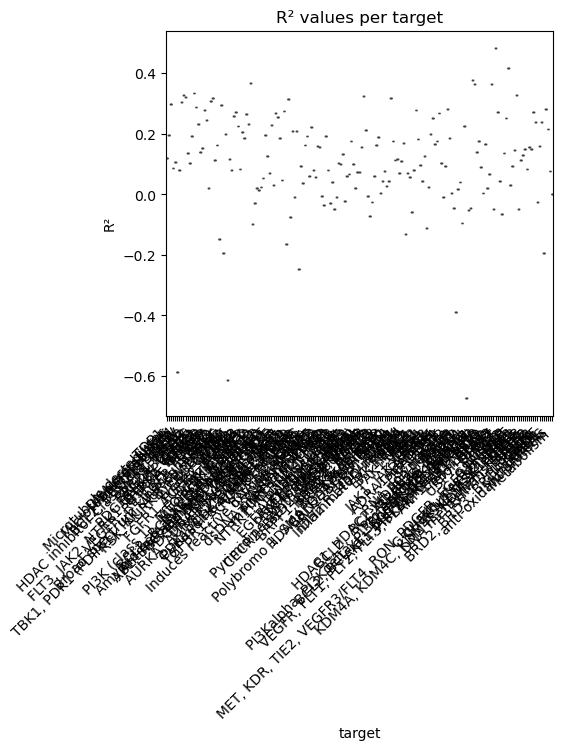

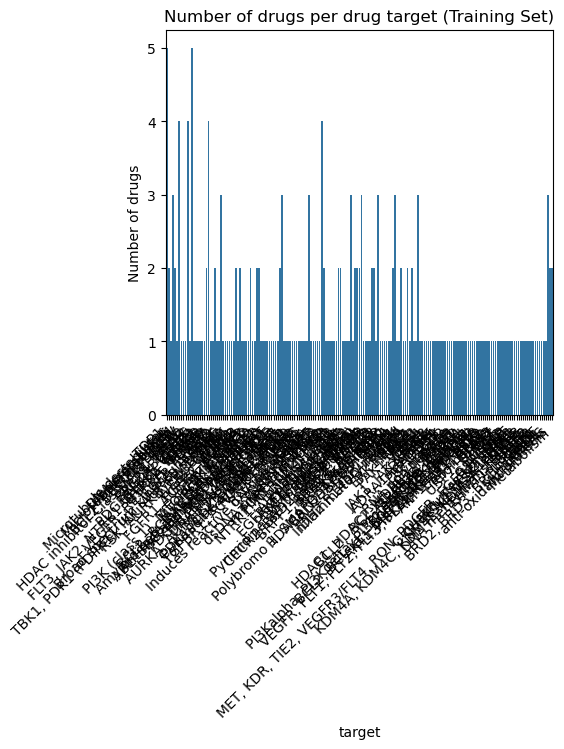

In [55]:
#
y_pred = y_pred_1 # remove this

#  build a table of r2 by drug, cosmic_id, cell info and drug info
keys = ['drug_id', 'r2', 'target', 'pathway', 'num_cells_test', 'num_cells_train', 'cancer_type', 'tissue_desc_1',
        'tissue_desc_2','growth_properties']
feature = 'target'
table_dict = {key: [] for key in keys}
feat_vals = []
r2_vals = []
n_samples = []
for feat_val in df_val[feature].unique():
    idx = (df_val[feature] == feat_val)
    #feat_vals.append(feat_val)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[TARGET_COLUMN_REG][idx], y_pred[idx])
        #r2 = -1 if r2 < -1 else r2
        r2_vals.append(r2)
        feat_vals.append(feat_val)
        n_samples.append(df_val['drug_id'][idx].nunique())

    #else:
        #r2_vals.append(0)

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.boxplot( x=feat_vals, y=r2_vals, )
plt.title(f"R² values per {feature}")
plt.xlabel("# cell lines (per drug)")
plt.xticks(rotation=45, ha='right')
plt.xlabel(feature)
plt.ylabel("R²")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.barplot( x=feat_vals, y=n_samples, )
plt.title("Number of drugs per drug target (Training Set)")
plt.xlabel("# cell lines (per drug)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of drugs")
plt.xlabel(feature)
plt.show()

Interpretation and Questions:

Question:
- Was this model trained on the whole data set, or was it trained on each drug-id?

Interpreation:
- Many drugs underperform based on R2

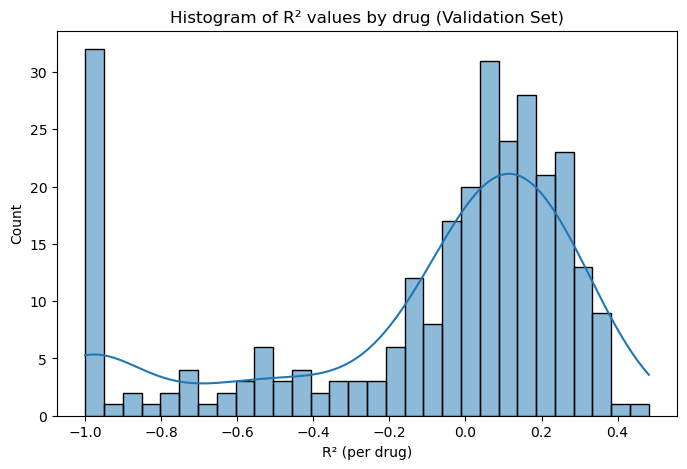

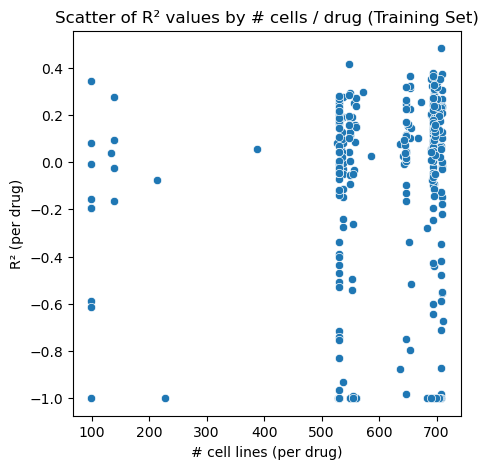

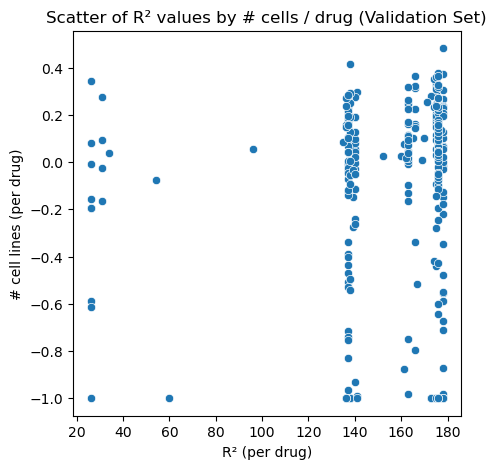

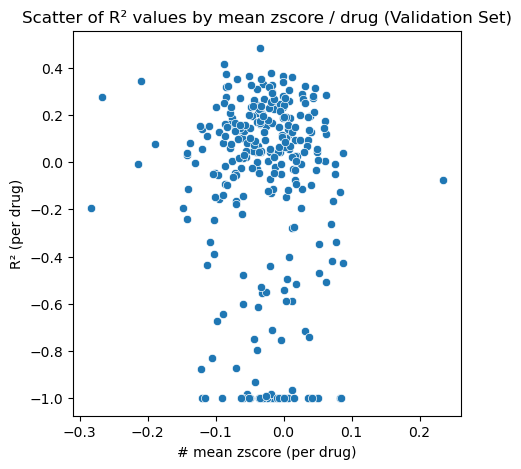

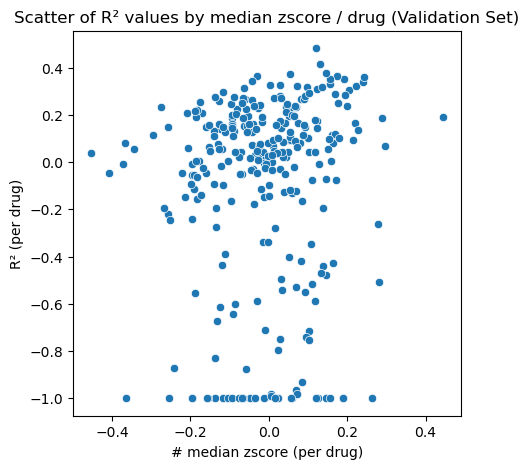

In [56]:
# Collect R² values for each drug in the validation set

r2_by_drug = []
cells_by_drug = []
cells_by_drug_train = []
mean_zscore_by_drug = []
median_zscore_by_drug = []
for drug_id in df_val['drug_id'].unique():
    idx = (df_val['drug_id'] == drug_id)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[TARGET_COLUMN_REG][idx], y_pred[idx])
        r2 = -1 if r2 < -1 else r2
        r2_by_drug.append(r2)

        # number of cells
        unique_cell_test = df_val['COSMIC_ID'][idx].nunique()
        cells_by_drug.append(unique_cell_test)

        # get the trianing number of cells for this drug
        idx_train = (df_train['drug_id'] == drug_id)
        n_train_cells = df_train['COSMIC_ID'][idx_train].nunique()
        cells_by_drug_train.append(n_train_cells)

        mean_zscore_by_drug.append(df_val['z_score'][idx].mean())
        median_zscore_by_drug.append(df_val['z_score'][idx].median())
    
# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(r2_by_drug, bins=30, kde=True)
plt.xlabel("R² (per drug)")
plt.ylabel("Count")
plt.title("Histogram of R² values by drug (Validation Set)")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.scatterplot( x=cells_by_drug_train, y=r2_by_drug,)
#plt.xlabel("# cell lines (per drug)")
plt.ylabel("R² (per drug)")
plt.xlabel("# cell lines (per drug)")
plt.title("Scatter of R² values by # cells / drug (Training Set)")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.scatterplot( x=cells_by_drug, y=r2_by_drug,)
plt.ylabel("# cell lines (per drug)")
plt.xlabel("R² (per drug)")
#plt.ylabel("# cell lines (per drug)")
plt.title("Scatter of R² values by # cells / drug (Validation Set)")
plt.show()


# Plot scatter r2 by mean zscore
plt.figure(figsize=(5, 5))
sns.scatterplot( x=mean_zscore_by_drug, y=r2_by_drug,)
plt.ylabel("# cell lines (per drug)")
plt.ylabel("R² (per drug)")
plt.xlabel("# mean zscore (per drug)")
plt.title("Scatter of R² values by mean zscore / drug (Validation Set)")
plt.show()


# Plot scatter r2 by mean zscore
plt.figure(figsize=(5, 5))
sns.scatterplot( x=median_zscore_by_drug, y=r2_by_drug,)
plt.ylabel("R² (per drug)")
plt.xlabel("# median zscore (per drug)")
plt.title("Scatter of R² values by median zscore / drug (Validation Set)")
plt.show()

In [57]:
# build a table of r2 by drug, cosmic_id, cell info and drug info
keys = ['drug_id', 'r2', 'target', 'pathway', 'num_cells_test', 'num_cells_train', 'cancer_type', 'tissue_desc_1',
        'tissue_desc_2','growth_properties']
table_dict = {key: [] for key in keys}
for drug_id in df_val['drug_id'].unique():
    idx = (df_val['drug_id'] == drug_id)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[TARGET_COLUMN_REG][idx], y_pred[idx])
        #r2 = -1 if r2 < -1 else r2
        table_dict['drug_id'].append(drug_id)
        table_dict['r2'].append(r2)
        table_dict['target'].append(df_val['target'][idx].unique())
        table_dict['pathway'].append(df_val['pathway'][idx].unique())

        table_dict['num_cells_test'].append(df_val['COSMIC_ID'][idx].nunique())
        # get the trianing number of cells for this drug
        idx_train = (df_train['drug_id'] == drug_id)
        n_train_cells = df_train['COSMIC_ID'][idx_train].nunique()
        table_dict['num_cells_train'].append(n_train_cells)

        table_dict['cancer_type'].append(df_val['cancer_type'][idx].unique())
        table_dict['tissue_desc_1'].append(df_val['tissue_desc_1'][idx].unique())
        table_dict['tissue_desc_2'].append(df_val['tissue_desc_2'][idx].unique())
        table_dict['growth_properties'].append(df_val['growth_properties'][idx].unique())

#print(table_dict)
r2_stats_df = pd.DataFrame(table_dict)

r2_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   drug_id            286 non-null    int64  
 1   r2                 286 non-null    float64
 2   target             286 non-null    object 
 3   pathway            286 non-null    object 
 4   num_cells_test     286 non-null    int64  
 5   num_cells_train    286 non-null    int64  
 6   cancer_type        286 non-null    object 
 7   tissue_desc_1      286 non-null    object 
 8   tissue_desc_2      286 non-null    object 
 9   growth_properties  286 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 22.5+ KB


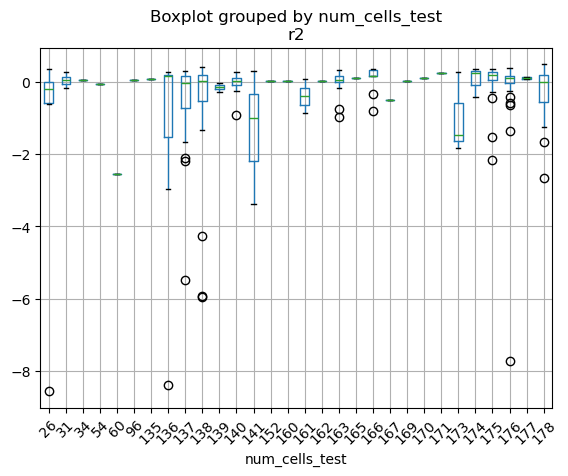

In [58]:
# Plot r2 dist by cell features

r2_stats_df.boxplot(column='r2', by='num_cells_test')
plt.xticks(rotation=45)
plt.show()


Interpretation:
The number of cells does not appear correlated to the level of model performance

In [59]:
print(df_model_info.model_type.unique())


['DummyRegressor' 'LGBMRegressor']


# 4: Model Family Selection
Train a series of model types on core data and then select which model will be used for Feature Selection and final Model hypertuning.


| 	Model	 | 	Brief description / notes	 | 	Library	 | 
| 	--------	 | 	-----------	 | 	----------	 | 
| 	***Continuous-target (regression)***	 | 		 | 		 | 
| 	LGBMRegressor (baseline & optimized)	 | 	Gradient-boosted decision trees, native categorical support, fast on 100 k + rows	 | 	lightgbm	 | 
| 	XGBRegressor	 | 	Complementary GBDT implementation; often rivals/edges out LightGBM on tabular data	 | 	xgboost	 | 
| 	MLPRegressor	 | 	Feed-forward neural net (dense) – serves as the neural-network baseline	 | 	scikit-learn / PyTorch-TabNet	 | 
| 	***Binary-target (classification)***	 | 		 | 		 | 
| 	DecisionTreeClassifier 	 | 	Transparent baseline; matches your current pipeline	 | 	scikit-learn	 | 
| 	RandomForestClassifier	 | 	Stronger ensemble; handles class imbalance with class-weights	 | 	scikit-learn	 | 

In [60]:
def plot_y_y_two_models(model_name_1, x, model_name_2, y):
    plt.scatter(x=x, y=y)
    plt.title(f"Prediction for {model_name_1} vs {model_name_2}")
    plt.xlabel(f"{model_name_1} Predictions")
    plt.ylabel(f"{model_name_2} Predictions")
    min_lim = np.floor(min(x.min(), y.min())) - 1
    max_lim = np.floor(max(x.max(), y.max())) + 1
    plt.xlim([min_lim, max_lim])
    plt.ylim([min_lim, max_lim])

    plt.plot([min_lim, max_lim], [min_lim, max_lim], 'r--', lw=2)  # y=x line
    plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect
    plt.grid(True)

    # Force x and y ticks to be the same
    # ticks = np.linspace(min_lim, max_lim, num=int((max_lim) - (min_lim) + 1))
    # plt.xticks(ticks)
    # plt.yticks(ticks)

#plot_y_y_two_models(model_name_1, y_pred_1, model_name_2, y_pred_2)

## 4.1 LGBMRegressor: Addition of weights to LGBMRegressor model training

Does the addition of sample weights improve model performance?



Model evaluation for LGBMRegressor: LGBMRegressor: GDSC + Weights completed.
| Model Info                              | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:----------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model)    | Train   | regression   |  0.975 |      0.735 |       0.46  |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC w/ training weights | Train   | regression   |  0.935 |      0.748 |       0.494 |    0.252 |   0.334 |      nan |  1.57  | 1.185 | 0.666 |     0.826 |      0.757 |


| Model Info                              | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson

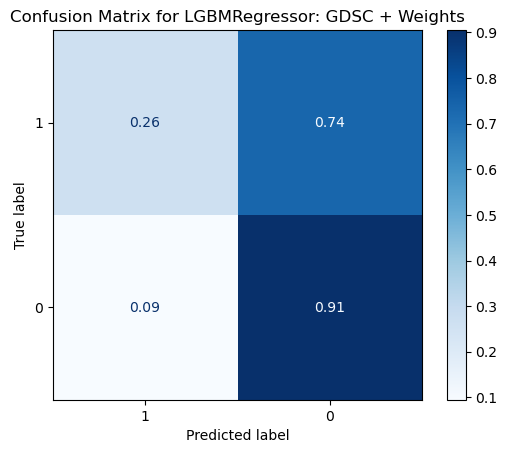

Plot y capped at -1 to 1 for Mean R2


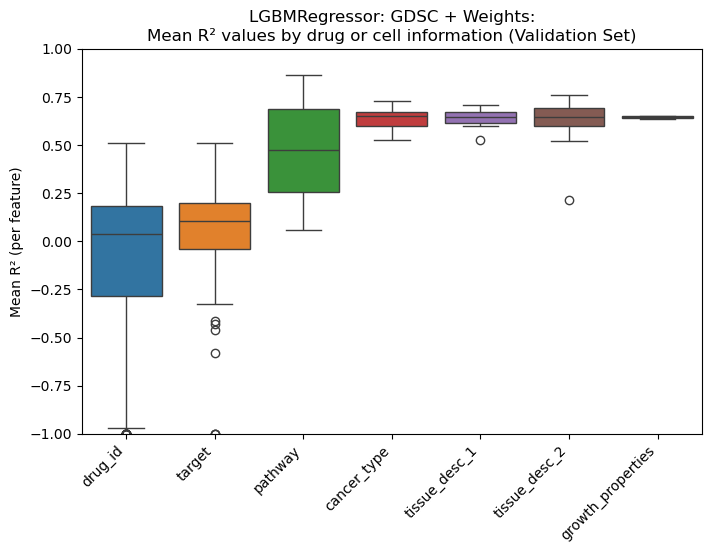

In [61]:
## 4.1 LGBMRegressor Per drug model: Hypertune and with Addition of weights to LGBMRegressor model training

## Core Model: LGBMRegressor with weights

# -- edit this section per model --
# Model information
model_name = 'LGBMRegressor: GDSC + Weights'
model_type = 'LGBMRegressor'
task_type = 'regression'
model_description = 'LGBMRegressor: GDSC w/ training weights'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg[TARGET_COLUMN_REG]
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg[TARGET_COLUMN_REG]
val_data_y_name = 'y_val_reg'
pos_label     = 1 # used to set as yes or 1 for categorical data (None for regression)

# -- END EDIT ---

# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)

## ---- Setup Model and Pipeline ----
# Create a LGBMRegressor model with sample weights
lgb_base = lgb.LGBMRegressor(
    objective="rmse",
    n_jobs=-1,
    metric="rmse",
    random_state=RANDOM_SEED,
    verbose=-1,
)

## setup pipeline
pipe = NamedPipeline(
    model_name,
    [
        ('pre', preprocessor_cols_C),
        ('model',lgb_base)
    ]
)

## -- Fit the model to the training data and save the model --
# Start the timer for training
start_time = time.time()

# Fit the model to the training data
pipe.fit(
    X_train_use, 
    y_train_reg[TARGET_COLUMN_REG], 
    model__sample_weight=w_train
    )
train_time = time.time() - start_time

# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe

# save to file 
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
    (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")
print_model_metrics(df_models_eval, df_model_info, 'Train')
print("\n")

print_model_metrics(df_models_eval, df_model_info, 'Test')

print(f"\nPredicution column: {pred_col}")

print("\n")
# Get top drug-cancer R2 per model
r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
print("\n")
print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
#df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)
print("\n")

# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()

In [62]:
print("Table of Model Performance:")
print_model_metrics(df_models_eval, df_model_info, 'Train')
print("\n")

print_model_metrics(df_models_eval, df_model_info, 'Test')

Table of Model Performance:
| Model Info                              | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:----------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model)    | Train   | regression   |  0.975 |      0.735 |       0.46  |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC w/ training weights | Train   | regression   |  0.935 |      0.748 |       0.494 |    0.252 |   0.334 |      nan |  1.57  | 1.185 | 0.666 |     0.826 |      0.757 |


| Model Info                              | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:---------------------------------

**Interpretation:**

Sample Weights does not improve the model performance.

Action
- Do not use sample weights

**INTERPRETATION:**

BAR rewrite this based on pathway-cnancer
Perfomrnace does not improve with when training on individual drugs.

## 4.2 DecisionTree Baseline Model - Core Dataset

Save model


Model evaluation for DecisionTreeClassifier: DecisionTreeClassifier GDSC completed.

| Model Info                   | Split   | Model_Type     |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |     R2 |   Pearson |   Spearman |
|:-----------------------------|:--------|:---------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|-------:|----------:|-----------:|
| DecisionTreeClassifier: GDSC | Train   | classification |  1.252 |      0.323 |       0.241 |    0.791 |   0.369 |      nan |  0.421 | 0.177 |  0.057 |     0.479 |      0.479 |
| DecisionTreeClassifier: GDSC | Test    | classification |  0.031 |      0.329 |       0.247 |    0.794 |   0.376 |      nan |  0.467 | 0.219 | -0.15  |     0.362 |      0.362 |

Predicution column: DecisionTreeClassifier GDSC_y_pred


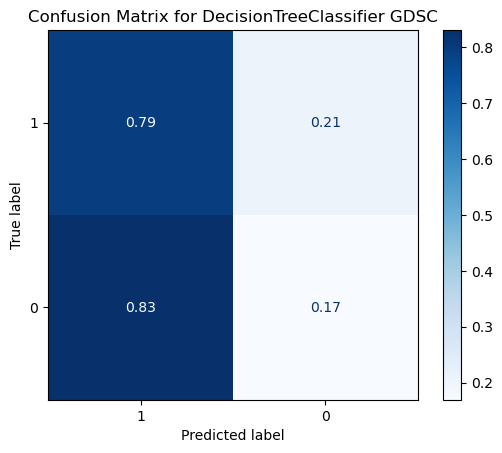

Plot y capped at -1 to 1 for Mean R2


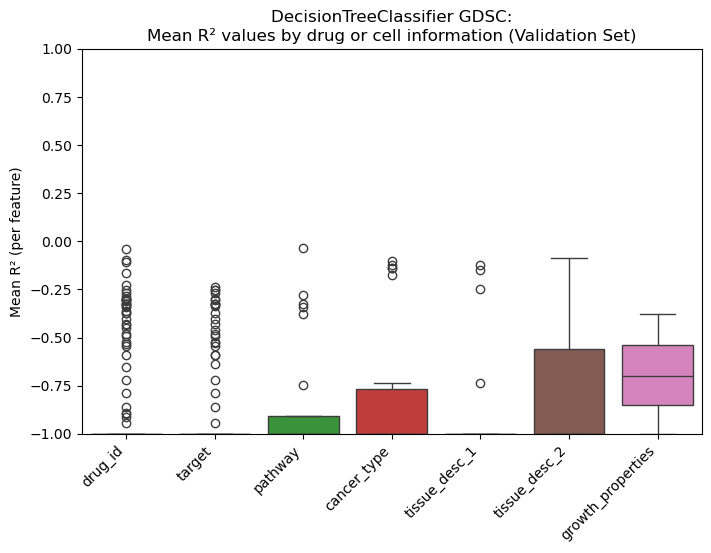

In [63]:
# Model 1: DecisionTree

## -- edit this section per model --

# Model information
model_name = 'DecisionTreeClassifier GDSC'
model_type = 'DecisionTreeClassifier'
task_type = 'classification'
model_description = 'DecisionTreeClassifier: GDSC'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_cat
train_data_y_name = 'y_train_cat'
y_data_val    = y_val_cat
val_data_y_name = 'y_val_cat'
pos_label     = 1 # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---


# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_CAT,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)

# Create pipeline
pipe = NamedPipeline(
    model_name,[
        ('pre',   preprocessor_cols_C),
        ('model', DecisionTreeClassifier())
    ]
)

# Train the Model
start_time = time.time()
pipe.fit(X_train_use, y_data_train[TARGET_COLUMN_CAT])
train_time = time.time() - start_time

# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe 

print("Save model")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_cat[TARGET_COLUMN_CAT], w_train, "Train"),
    (X_val_use,   y_val_cat[TARGET_COLUMN_CAT],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.\n")


print_model_metrics(df_models_eval[df_models_eval['Model'] == model_name], df_model_info)

print(f"\nPredicution column: {pred_col}")
# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()


## 4.3 XGBoost - Core Dataset

objective: e.g. "reg:squarederror" for regression, "binary:logistic" for binary classification, or "multi:softprob" for multiclass.



Model evaluation for XGBoostRegressor: XGBoostRegresspr GDSC completed.
| Model Info         | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |     R2 |   Pearson |   Spearman |
|:-------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|-------:|----------:|-----------:|
| XGBRegressor: GDSC | Train   | regression   |  0.379 |      0.323 |       0.241 |    0.791 |   0.369 |      nan |  3.919 | 3.42  | -1.08  |    -0.231 |     -0.241 |
| XGBRegressor: GDSC | Test    | regression   |  0.031 |      0.329 |       0.247 |    0.794 |   0.376 |      nan |  3.867 | 3.368 | -1.006 |    -0.192 |     -0.204 |

Predicution column: XGBoostRegresspr GDSC_y_pred


Total number of unique drug pathway and cancer_type combinations: 622


Number of drug pathway-cancer combos with R2 above the Cuttoff of: 0.5


Results for pathway-cancer combos above cuttoff of 0.5
| Mode

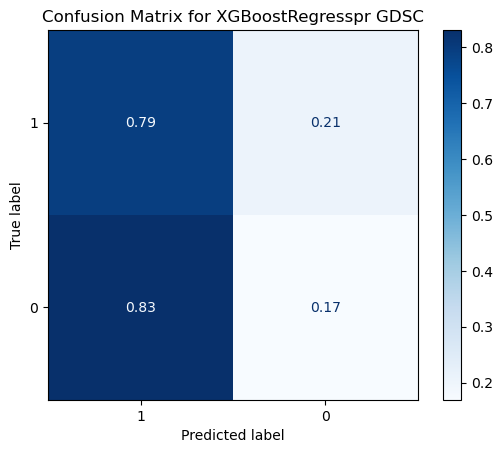

Plot y capped at -1 to 1 for Mean R2


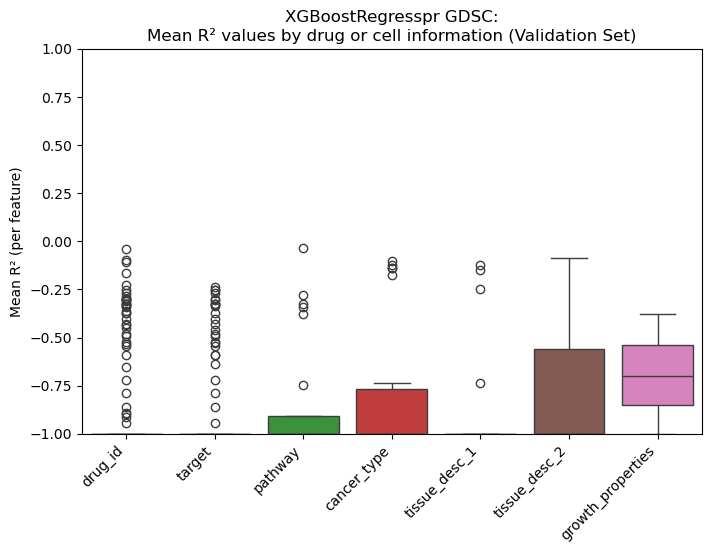

In [64]:
# XGBClassifier(objective='binary:logistic')

## -- edit this section per model --
# Model information
model_name = 'XGBoostRegresspr GDSC'
model_type = 'XGBoostRegressor'
task_type = 'regressino'
model_description = 'XGBRegressor: GDSC'

# Collect Statistics
y_data_train  = y_train_reg
train_sample_weights = None
y_data_val    = y_val_reg
val_sample_weights = None
pos_label     = None# used to set as yes or 1

## -- END EDIT ---

# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info,
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_CAT,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)


#  model with initial hyperparameters
xgb_base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=500,
#     learning_rate=0.1,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=RANDOM_SEED,
#     # early_stopping_rounds=30, 
#     # verbose=False
# )

xgb_reg_base_pipe = NamedPipeline(
    model_name,[
        ('pre', preprocessor_cols_C),
        ('model', xgb_base_model)  # note no () after xboost as it was already isntatiated
    ]
)

# Fit the model to the training data
start_time = time.time()
xgb_reg_base_pipe.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
train_time = time.time() - start_time

# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe

# save to file 
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
    (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")

print_model_metrics(df_models_eval[df_models_eval['Model'] == model_name], df_model_info)

print(f"\nPredicution column: {pred_col}")

print("\n")
# Get top drug-cancer R2 per model
r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
print("\n")
print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
#df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)

print("\n")

# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()




## 4.4: MLPRegressor - Core Dataset

Save model


Model evaluation for MLPRegressor : MLPRegressor GDSC completed.
| Model Info         | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| MLPRegressor: GDSC | Train   | regression   | 13.43  |      0.757 |       0.518 |    0.431 |   0.471 |      nan |  1.448 | 1.086 | 0.716 |     0.846 |      0.782 |
| MLPRegressor: GDSC | Test    | regression   |  0.035 |      0.739 |       0.488 |    0.426 |   0.455 |      nan |  1.518 | 1.146 | 0.691 |     0.832 |      0.759 |

Predicution column: MLPRegressor GDSC_y_pred


Total number of unique drug pathway and cancer_type combinations: 622


Number of drug pathway-cancer combos with R2 above the Cuttoff of: 0.5


Results for pathway-cancer combos above cuttoff of 0.5
| Model   

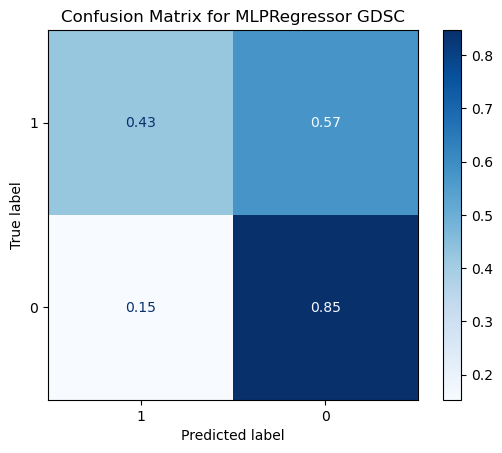

Plot y capped at -1 to 1 for Mean R2


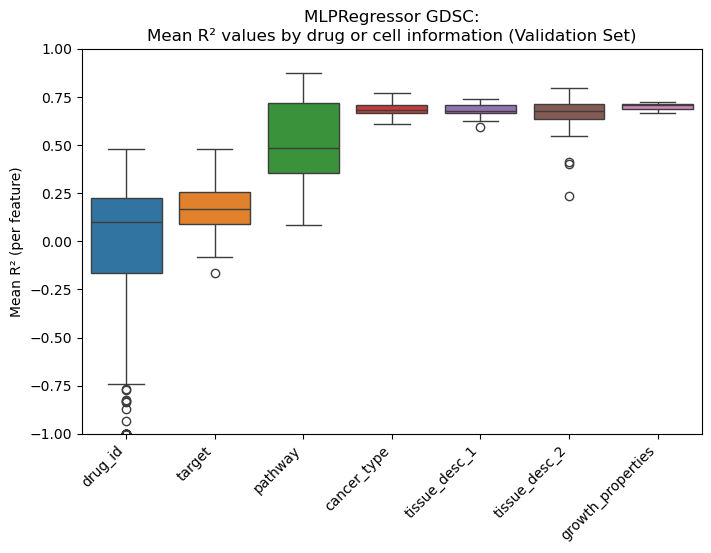

In [65]:
## Baseine MLPRegressor with Pipeline
## -- edit this section per model --

# Model information
model_name = 'MLPRegressor GDSC'
model_type = 'MLPRegressor '
task_type  = 'regression'
model_description = 'MLPRegressor: GDSC'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg[TARGET_COLUMN_REG]
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg[TARGET_COLUMN_REG]
val_data_y_name = 'y_val_reg'
pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---

# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)


mlp_base = MLPRegressor(
    random_state=RANDOM_SEED, 
    max_iter=500, 
    n_iter_no_change=20, 
    early_stopping=True
    )
# Create a Linear Regression pipeline (using weights during predicion)
pipe = NamedPipeline(
    model_name,[            
    ('pre',    preprocessor_cols_C),
    ('model',  mlp_base)           
])

# Fit the model to the training data
start_time = time.time()
pipe.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
train_time = time.time() - start_time

# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe

print("Save model")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")


# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
    (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")
print_model_metrics(df_models_eval[df_models_eval['Model'] == model_name], df_model_info)

print(f"\nPredicution column: {pred_col}")

print("\n")
# Get top drug-cancer R2 per model
r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
print("\n")
print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
#df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)

print("\n")

# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()



## 4.5 ElasticNet

Save model


Model evaluation for ElasticNet : ElasticNet GDSC completed.
| Model Info                  | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |     R2 |   Pearson |   Spearman |
|:----------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|-------:|----------:|-----------:|
| ElasticNet Regression: GDSC | Train   | regression   |  0.2   |      0.55  |       0.25  |    0.4   |   0.308 |      nan |  2.718 | 2.066 |  0     |       nan |        nan |
| ElasticNet Regression: GDSC | Test    | regression   |  0.026 |      0.546 |       0.252 |    0.395 |   0.307 |      nan |  2.731 | 2.067 | -0.001 |       nan |        nan |

Predicution column: ElasticNet GDSC_y_pred


Total number of unique drug pathway and cancer_type combinations: 622


Number of drug pathway-cancer combos with R2 above the Cuttoff of: 0.5


Results for pathway-cancer comb

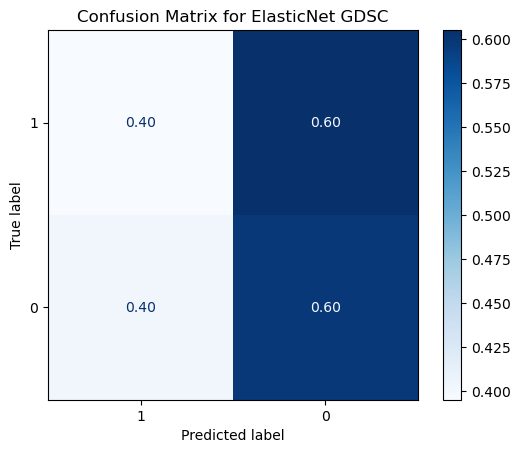

Plot y capped at -1 to 1 for Mean R2


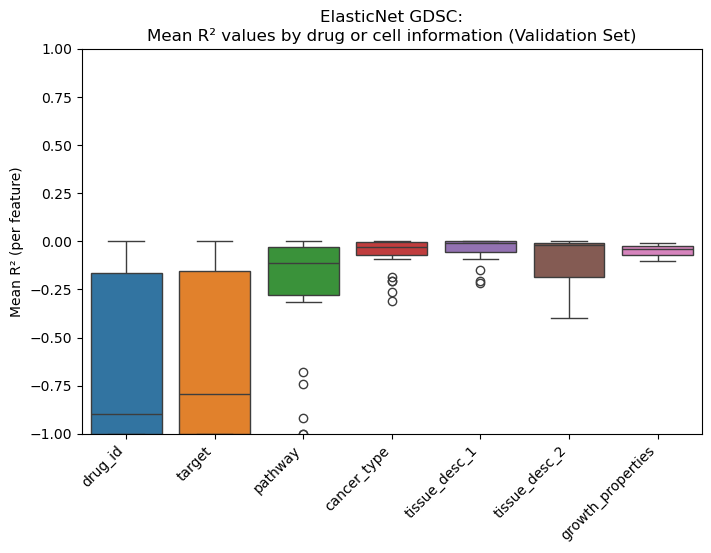

In [66]:
## Baseine ElasticNet with Pipeline
## -- edit this section per model --

# Model information
model_name = 'ElasticNet GDSC'
model_type = 'ElasticNet '
task_type  = 'regression'
model_description = 'ElasticNet Regression: GDSC'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg[TARGET_COLUMN_REG]
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg[TARGET_COLUMN_REG]
val_data_y_name = 'y_val_reg'
pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---

# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)


# Create Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)


elastic_base = ElasticNet(
    alpha=1.0,          # L1 vs. L2 mixing parameter
    l1_ratio=0.5,       # 0 = pure Ridge, 1 = pure Lasso
    random_state=RANDOM_SEED,
    max_iter=1000,
    tol=1e-4
)
# Create a Linear Regression pipeline (using weights during predicion)
pipe = NamedPipeline(
    model_name,[               
    ('pre',    preprocessor_cols_C),
    ('model',  elastic_base)                  
])

# Fit the model to the training data
start_time = time.time()
pipe.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
train_time = time.time() - start_time

# store model for later
models_dict[model_name] = pipe

# Save amd Evalaute the model
model_to_eval = pipe

print("Save model")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate on train & val, logging into df_models_eval
for X_data, y_data, w_data, split in [
    (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
    (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
    ]:

    # add predictions
    pred_col = f"{model_name}_y_pred"
    if split == "Train":
        df_train[pred_col] = model_to_eval.predict(X_data)
        y_pred = df_train[pred_col]
    else:
        df_val[pred_col]   = model_to_eval.predict(X_data)
        y_pred = df_val[pred_col]

    # regression metrics
    df_models_eval = evaluate_model(
        model_to_eval, model_name, split,
        X_data, y_data,
        df_models_eval = df_models_eval,
        train_time     = train_time,       # or search refit time if tracked
        pos_label      = None,             # regression
        round_to       = ROUND_TO
    )

    # binary metrics (if you have y_true_cat & threshold_per_drug)
    df_models_eval, df_tmp = add_binary_metrics(
        df_models_results  = df_models_eval,
        model_name         = model_name,
        split_name         = split,
        df                 = df_val if split == "Test" else df_train,
        y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
        y_pred             = y_pred,
        threshold_per_drug = threshhold_per_drug,
        pos_label          = 1,
        round_to           = ROUND_TO
    )

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")

print_model_metrics(df_models_eval[df_models_eval['Model'] == model_name], df_model_info)

print(f"\nPredicution column: {pred_col}")

print("\n")
# Get top drug-cancer R2 per model
r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
print("\n")
print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
#df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)

print("\n")

# Plot confusion matrix for validation set
plot_confusion_matrix(
    y_val_cat[TARGET_COLUMN_CAT], 
    df_val[f"{model_name}_y_pred_bin"], 
    model_name, 
    labels=[1,0], 
    normalize='true'
    )

print("Plot y capped at -1 to 1 for Mean R2")
fig = plot_r2_by_feature(
    df_val, 
    y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
    floor=-1,
    model_name=model_name)
fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
fig.show()

## 4.6 Final Selection of Model Family
Evaluate each of the core models and determine which to move to the next phase (Feature Selection)

Include:
- Table of results
- Visualization of model data in plots
- common error or model specific Y-Y plots



Final Model Information:
Training Results:
| Model Info                              | Split   | Model_Type     |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |     R2 |   Pearson |   Spearman |
|:----------------------------------------|:--------|:---------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|-------:|----------:|-----------:|
| LGBMRegressor: GDSC (baseline model)    | Train   | regression     |  0.975 |      0.735 |       0.46  |    0.34  |   0.391 |      nan |  1.528 | 1.163 |  0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC w/ training weights | Train   | regression     |  0.935 |      0.748 |       0.494 |    0.252 |   0.334 |      nan |  1.57  | 1.185 |  0.666 |     0.826 |      0.757 |
| DecisionTreeClassifier: GDSC            | Train   | classification |  1.252 |      0.323 |       0.241 |    0.791 |   0.369 |      nan |  0.421 | 0.177 |  0.057 |     0.479 |      0.479 |
| XGBR

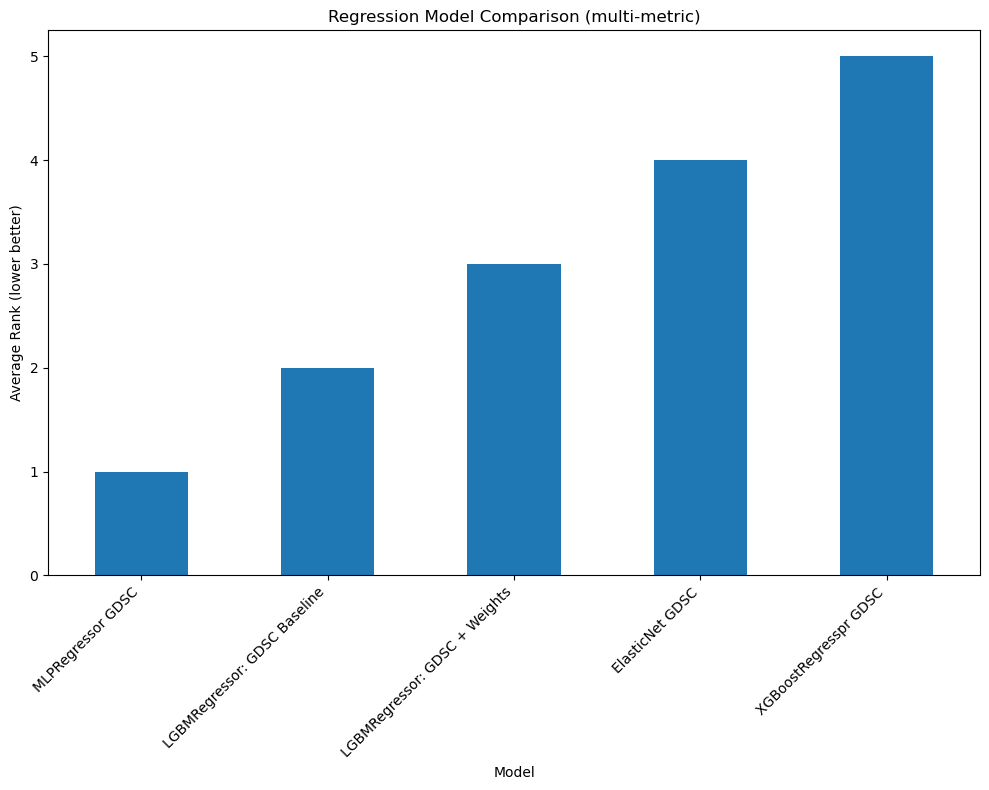

In [67]:
# Print final model information
print("\nFinal Model Information:")
print("Training Results:")
print_model_metrics(df_models_eval, df_model_info, 'Train')

print("\n")
print("Validation Results:")
print_model_metrics(df_models_eval, df_model_info, 'Test')

print("\nRanking of models by average rank of RMSE, MAE, R2")
fig = get_regression_model_rank(df_models_eval, df_model_info)


### Per drug pathway-cancer r2 performance of models

In [68]:
# Get results by drug-cancer
model_list = (
    list(df_models_eval['Model'].unique()) # + 
    #list(df_models_fa_eval['Model'].unique())
)

model_list, _ = check_ypredict_exists_in_df(df_val, df_models_eval['Model'].unique().tolist()) 
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, model_list, r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
#print_df_markdown(df_drugcancer_hits)

print_model_metrics(df_drugcancer_hits, df_model_info)



Results for pathway-cancer combos above cuttoff of 0.5
| Model Info                              |   Num above cuttoff |    Max |   Mean |
|:----------------------------------------|--------------------:|-------:|-------:|
| MLPRegressor: GDSC                      |                 289 |   0.96 |   0.73 |
| LGBMRegressor: GDSC (baseline model)    |                 271 |   0.95 |   0.73 |
| LGBMRegressor: GDSC w/ training weights |                 249 |   0.96 |   0.72 |
| DecisionTreeClassifier: GDSC            |                   0 | nan    | nan    |
| ElasticNet Regression: GDSC             |                   0 | nan    | nan    |
| XGBRegressor: GDSC                      |                   0 | nan    | nan    |


### Compare classification results - Order mmodel family by FBeta

In [69]:
## Print the model results in order of Fbeta
df_clf = df_models_eval#[df_models_eval['Model_Type']=='classification']
df_clf = df_clf[df_clf['Split']=='Test']
# sort by PR_AUC descending
df_clf_sorted = df_clf.sort_values('FBeta', ascending=False)

print_model_metrics(df_clf_sorted[['Model','FBeta','Precision','Accuracy','Recall']], df_model_info)


| Model Info                              |   FBeta |   Precision |   Accuracy |   Recall |
|:----------------------------------------|--------:|------------:|-----------:|---------:|
| MLPRegressor: GDSC                      |   0.455 |       0.488 |      0.739 |    0.426 |
| LGBMRegressor: GDSC (baseline model)    |   0.401 |       0.46  |      0.729 |    0.355 |
| DecisionTreeClassifier: GDSC            |   0.376 |       0.247 |      0.329 |    0.794 |
| XGBRegressor: GDSC                      |   0.376 |       0.247 |      0.329 |    0.794 |
| LGBMRegressor: GDSC w/ training weights |   0.342 |       0.487 |      0.741 |    0.263 |
| ElasticNet Regression: GDSC             |   0.307 |       0.252 |      0.546 |    0.395 |


### Evalaute regressio metrics for Model Familys

The model with the lowest avg_rank is your top‐performer across all metrics.


Ranking of models by average rank of RMSE, MAE, R2
| Model Info                              |   avg_rank |   RMSE |     R2 |   MAE |
|:----------------------------------------|-----------:|-------:|-------:|------:|
| MLPRegressor: GDSC                      |          1 |  1.518 |  0.691 | 1.146 |
| LGBMRegressor: GDSC (baseline model)    |          2 |  1.538 |  0.683 | 1.171 |
| LGBMRegressor: GDSC w/ training weights |          3 |  1.591 |  0.66  | 1.199 |
| ElasticNet Regression: GDSC             |          4 |  2.731 | -0.001 | 2.067 |
| XGBRegressor: GDSC                      |          5 |  3.867 | -1.006 | 3.368 |


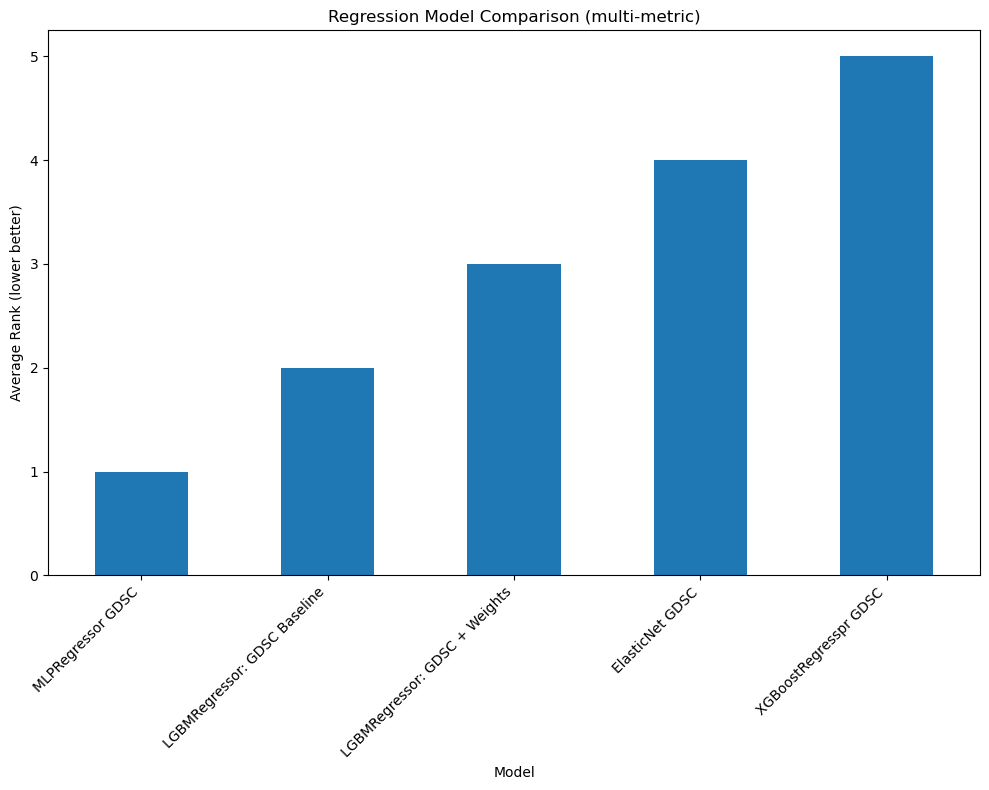

In [70]:

print("\nRanking of models by average rank of RMSE, MAE, R2")
fig = get_regression_model_rank(df_models_eval, df_model_info)




#### Compare models


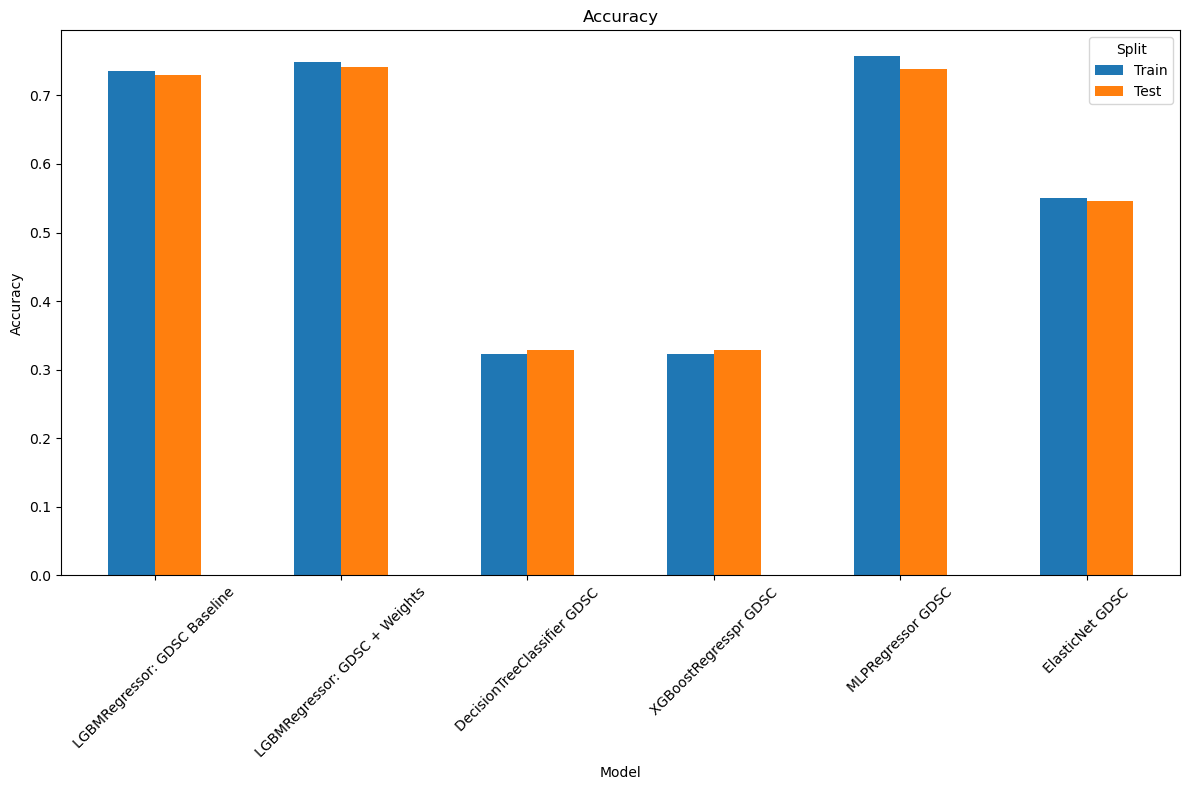

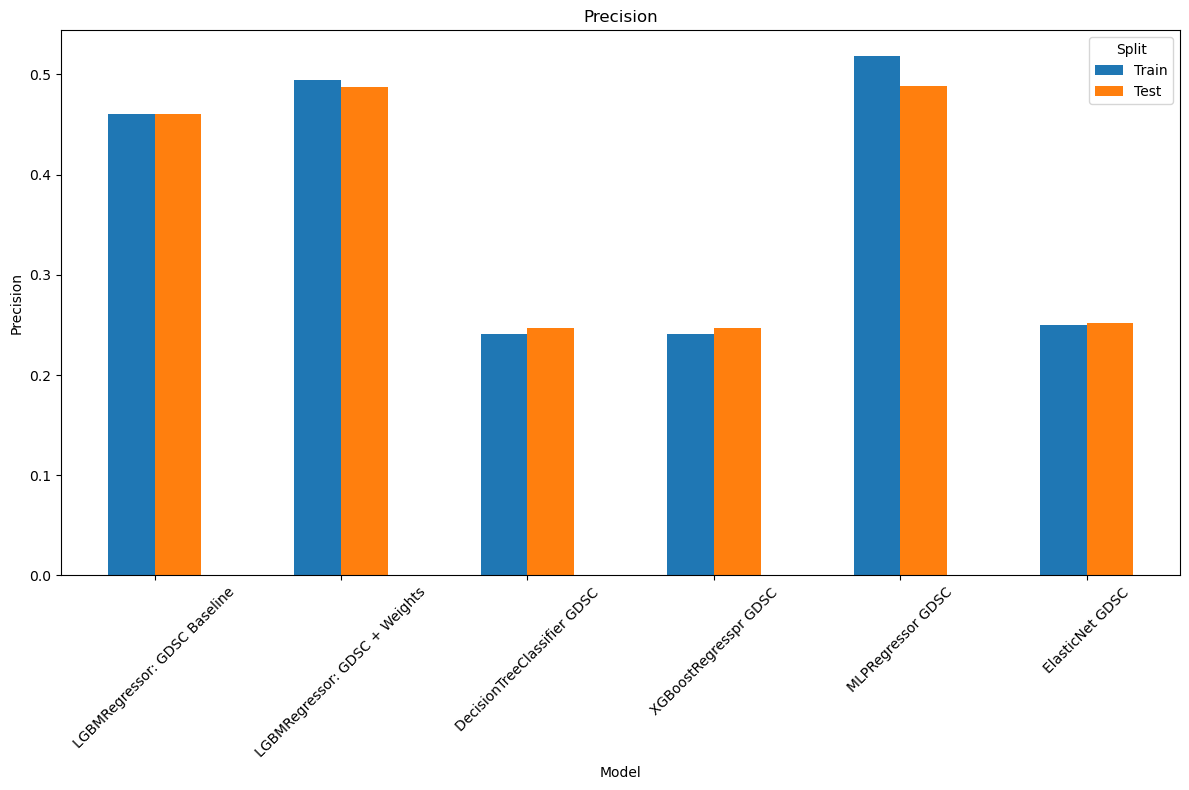

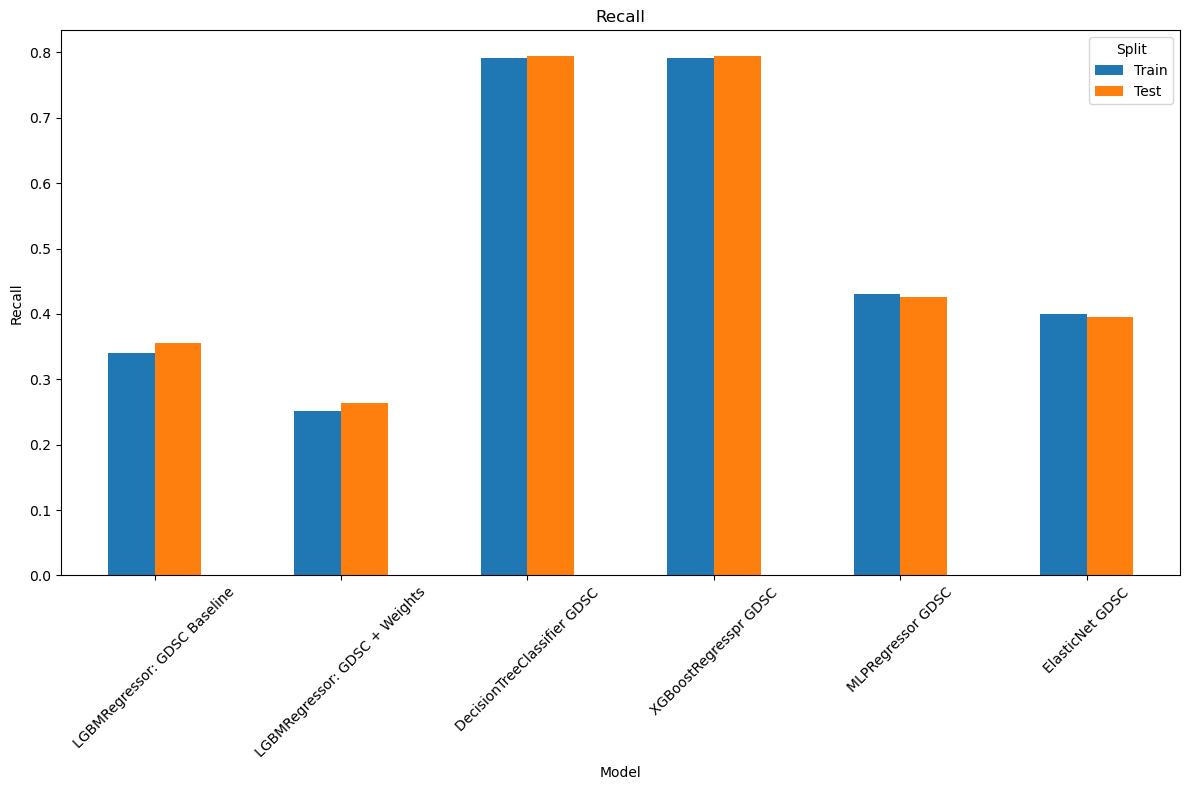

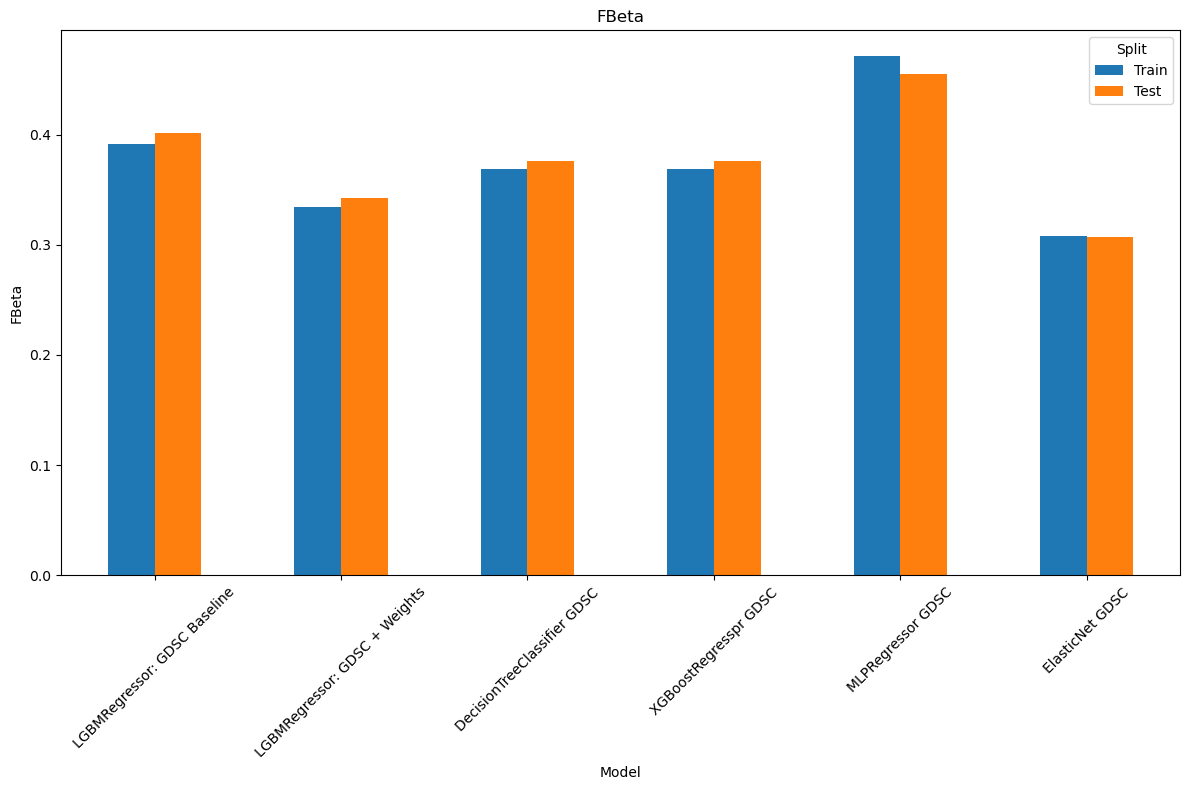

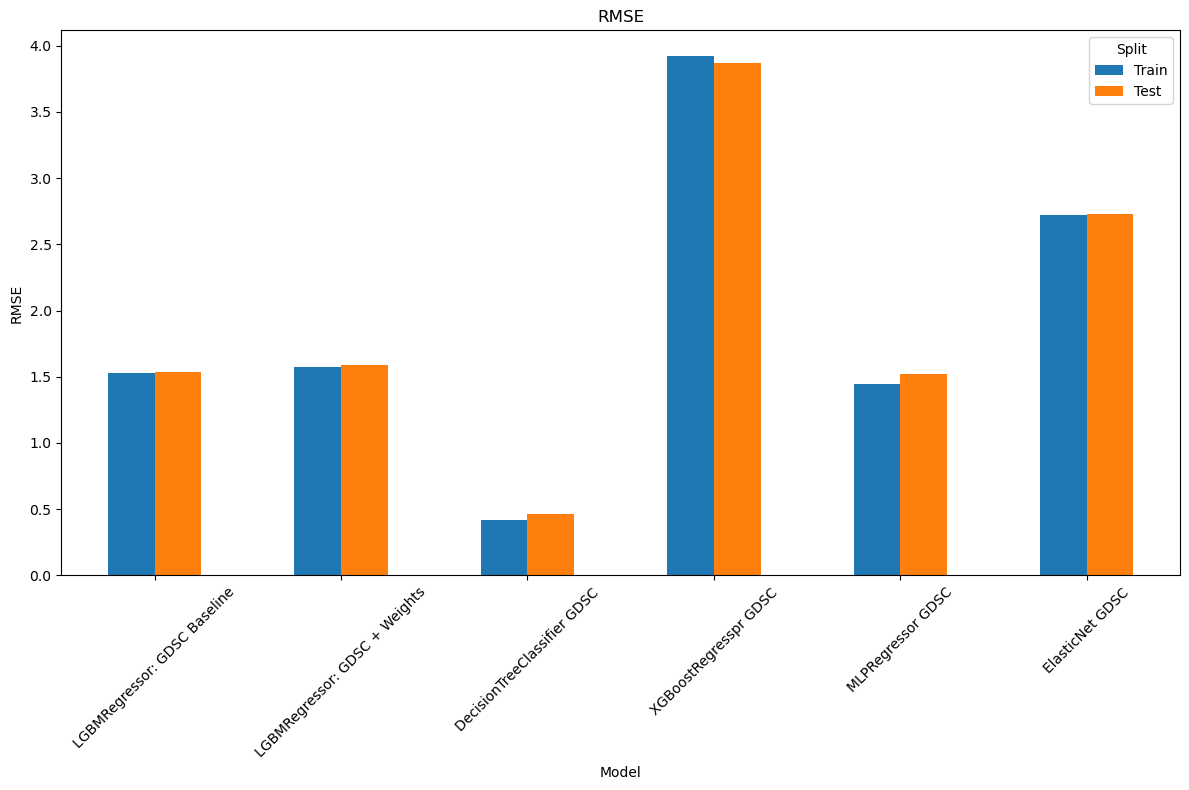

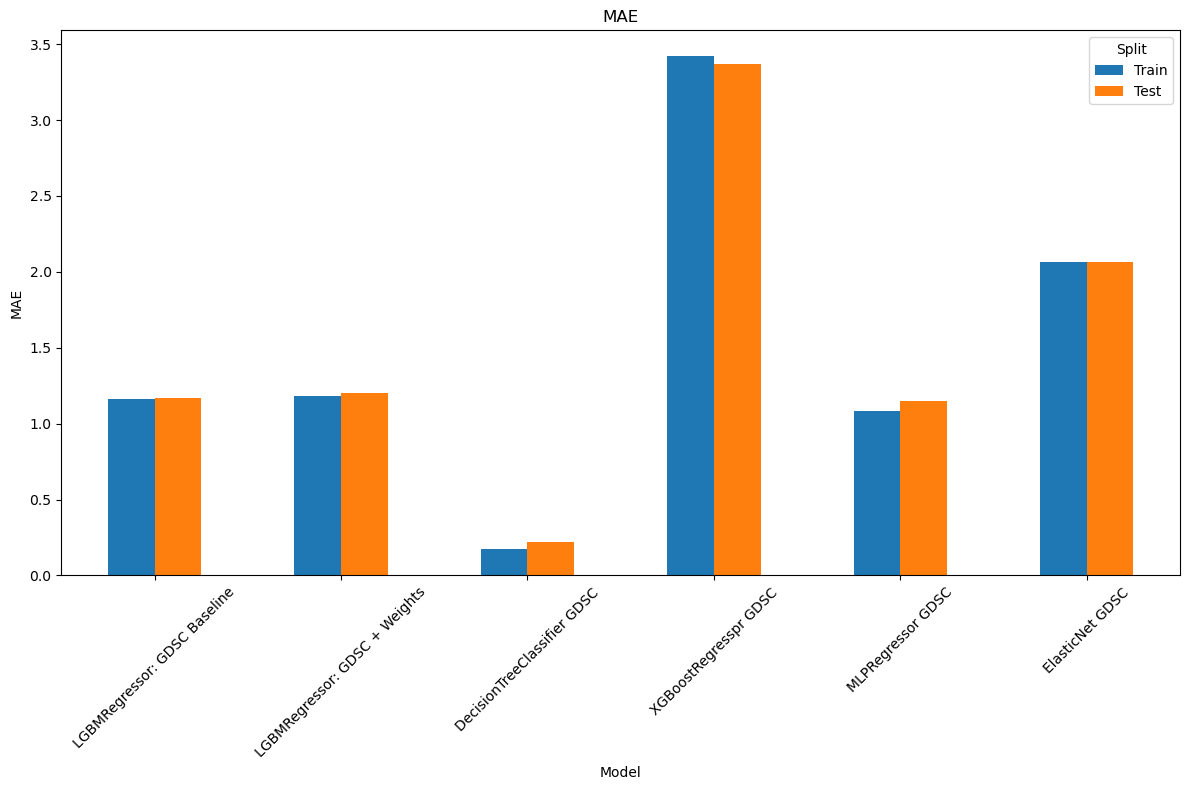

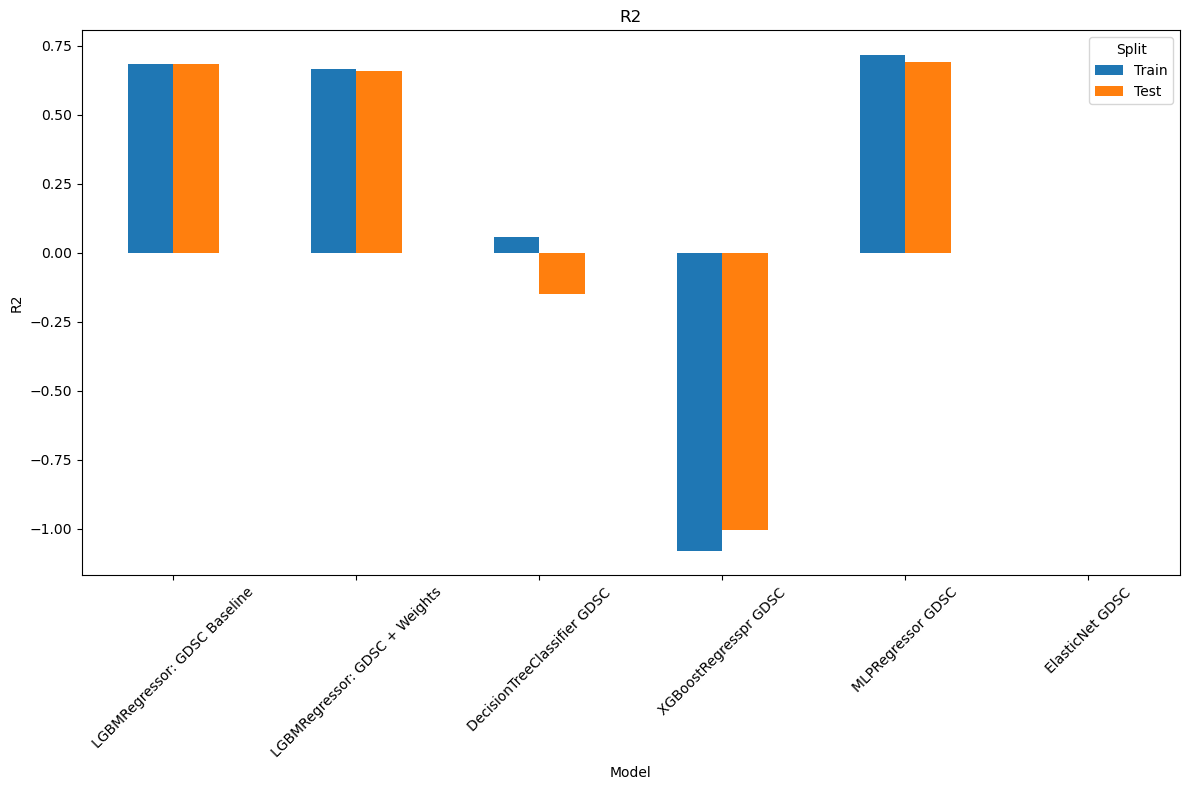

In [71]:
# Plot train/test per model

# Models to compare
selected_models = df_models_eval['Model'].unique()
#['LGBMRegressor: lgb_base_pipe', 'dectree_base_pipe', 'lgb_core_weights_pipe', 'xgb_reg_base_pipe', 'mlp_base_pipe', 'en_base_pipe']

#selected_models = df_models_eval['Model'].unique()
# ilter
df_sel = df_models_eval[df_models_eval['Model'].isin(selected_models)]

# metrics to plot
metrics = ['Accuracy','Precision','Recall','FBeta','RMSE','MAE','R2'] #'PR_AUC'

for metric in metrics:
    # 4) pivot so that Train/Test are columns
    df_piv = (
        df_sel
        .pivot(index='Model', columns='Split', values=metric)
        .reindex(selected_models)             # enforce the model order
    )
    
    # 5) simple grouped bar chart
    ax = df_piv[['Train','Test']].plot(
        kind='bar', 
        figsize=(12,8), 
        title=metric,
        rot=45
    )
    ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()


### Evaluate models using the number of drug-cancer combinations above an R2 cuttoff per model.

Total number of unique drug pathway and cancer_type combinations: 622
Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                         |   0.0 |   0.1 |   0.2 |   0.3 |   0.4 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|:------------------------------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Total Unique                  |   543 |   498 |   447 |   407 |   371 |   301 |   240 |   177 |   113 |    29 |
| LGBMRegressor: GDSC Baseline  |   516 |   464 |   418 |   376 |   331 |   271 |   206 |   156 |    97 |    23 |
| LGBMRegressor: GDSC + Weights |   497 |   452 |   406 |   360 |   312 |   249 |   194 |   139 |    82 |    14 |
| DecisionTreeClassifier GDSC   |     6 |     2 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |
| XGBoostRegresspr GDSC         |     6 |     2 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |
| MLPRegressor GDSC             |   517 |   467 |   430 |   392 |   3

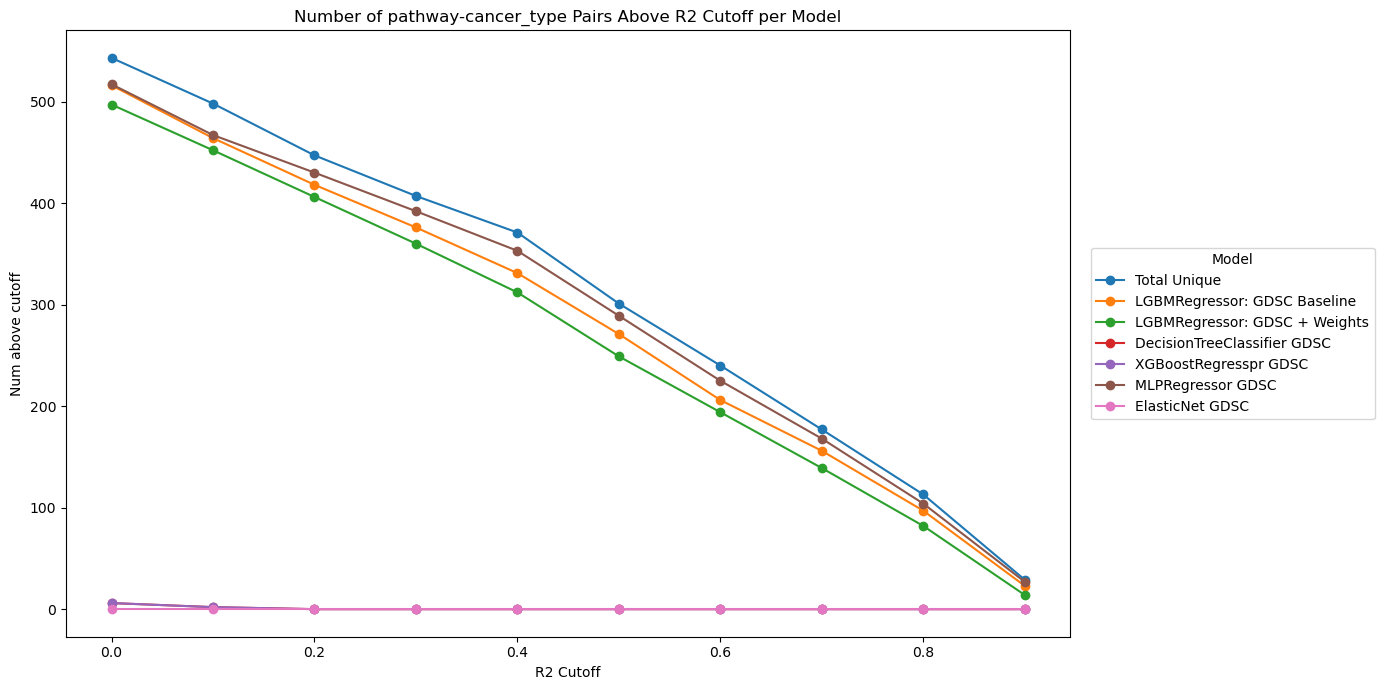

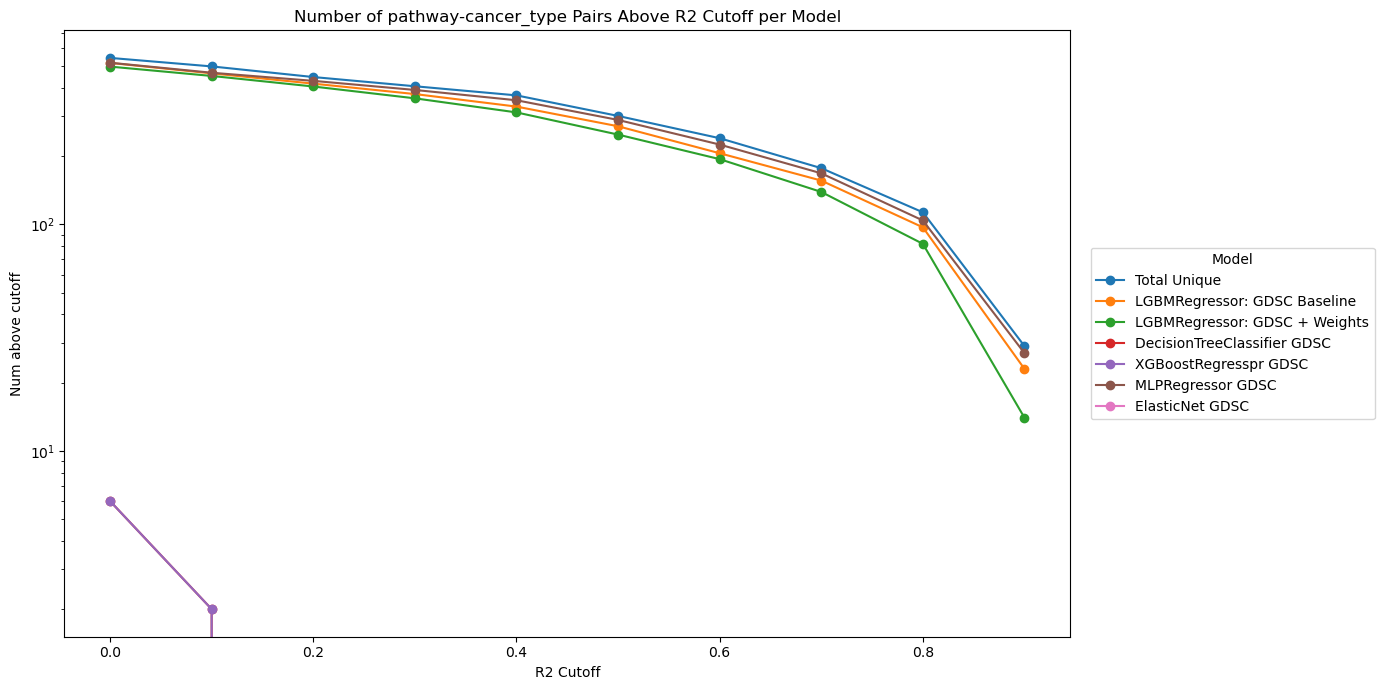

In [72]:
# Get top drug-cancer R2 per model
r2_cuttoff = 0 # R2_CUTTOFF
print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")

model_list, _ = check_ypredict_exists_in_df(df_val, df_models_eval['Model'].unique().tolist()) 


df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, model_list, 
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
fig_1.savefig(RESULTS_DIR / f"Model_Family_combo_r2_lineplot.png")
fig_1.show()

**INTERPRETATION:**

For all the models trained on the core GDSC data set (cols_c), MLPRegressor had the highest performance based on rank (lower score better) and number of drug pathway-cancer combinations above an R2 value of 0.5.

MLPRegressor also outperformed the DecisionTree model based on all metrics (precision, accuracy and FBeta) except recall.  

The MLPRegressor did take over 13 times longer to train than the LGBMRegressor, which was ranked second and had slightly fewer pathway-cancer combinations at each cuttoff. 

Therefore, the LGMRegressor type will be utilized for the Feature Addition and the Feature Selection experiments.

# 5.0 Feature Addition Experiment
Compare model performance with addition of Methylation, Mutation (Variant) and Expression Datasets


    The following combination of data sets will be used to evaluate the contribution of methylation, mutation and expression to with the GDSC on model performance.

 | 	Condition	 | 	Abbreviation	 | 	GDSC	 | 	Methylation (M)	 | 	Mutation (V)	 | 	Expression (E)	 | 
 | 	--------	 | 	----------	 | 	-----------	 | 	--------	 | 	-----------	 | 	----------	 | 
 | 	Impact of GDSC only *	 | 	C	 | 	Y	 | 		 | 		 | 		 | 
 | 	Impact of GDSC with M	 | 	CM	 | 	Y	 | 	Y	 | 		 | 		 | 
 | 	Impact of GDSC with M + V	 | 	CMV	 | 	Y	 | 	Y	 | 	Y	 | 		 | 
 | 	Impact of GDSC with  M + E	 | 	CME	 | 	Y	 | 	Y	 | 		 | 	Y	 | 
 | 	Impact of GDSC with  M + V + E	 | 	CMVE	 | 	Y	 | 	Y	 | 	Y	 | 	Y	 | 
	* Used for Base Models and Selection of the Best Model Type			


### Capture results in df_models_fa_eval for Feature Addition

In [73]:
# Setup model results dataframe for feature addition experiment
df_models_fa_eval = evaluate_model()

df_model_fa_info = pd.DataFrame(columns=[df_model_info.columns])

## 5.1 Feature addition with LGBMRegressor hypertuning

Using columns: GDSC
Processing model LGBMR_GDSC_feature_addition
Mean y_pred: 2.87
Mean y_pred: 2.86


Model evaluation for LGBMRegressor: LGBMR_GDSC_feature_addition completed.

Predicution column: LGBMR_GDSC_feature_addition_y_pred


Number of drug-cancer combos with R2 above the Cuttoff of: 0.5




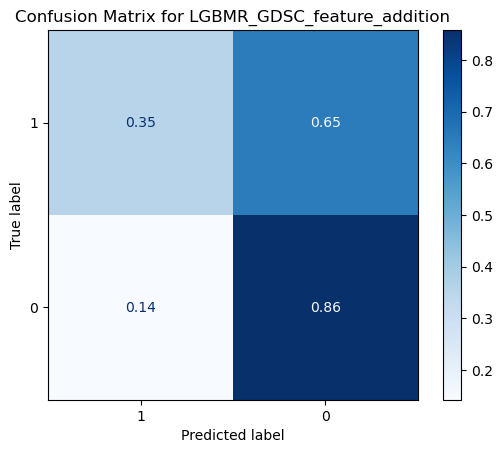

Plot y capped at -1 to 1 for Mean R2
Using columns: GDSC + M
Processing model LGBMR_GDSC + M_feature_addition
Mean y_pred: 2.87
Mean y_pred: 2.86


Model evaluation for LGBMRegressor: LGBMR_GDSC + M_feature_addition completed.

Predicution column: LGBMR_GDSC + M_feature_addition_y_pred


Number of drug-cancer combos with R2 above the Cuttoff of: 0.5




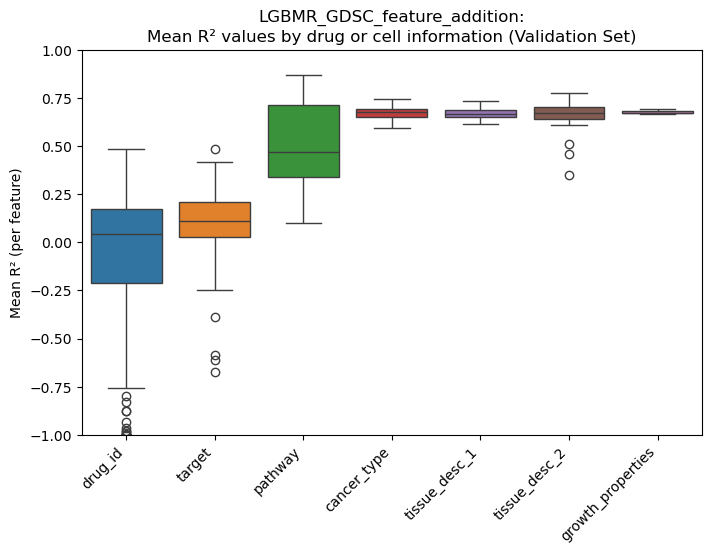

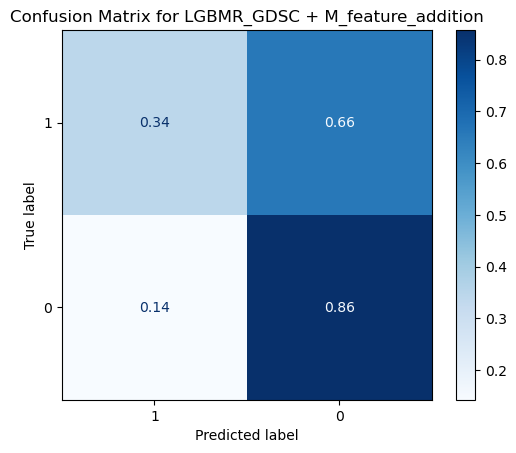

Plot y capped at -1 to 1 for Mean R2
Using columns: GDSC + ME
Processing model LGBMR_GDSC + ME_feature_addition
Mean y_pred: 2.87
Mean y_pred: 2.89


Model evaluation for LGBMRegressor: LGBMR_GDSC + ME_feature_addition completed.

Predicution column: LGBMR_GDSC + ME_feature_addition_y_pred


Number of drug-cancer combos with R2 above the Cuttoff of: 0.5




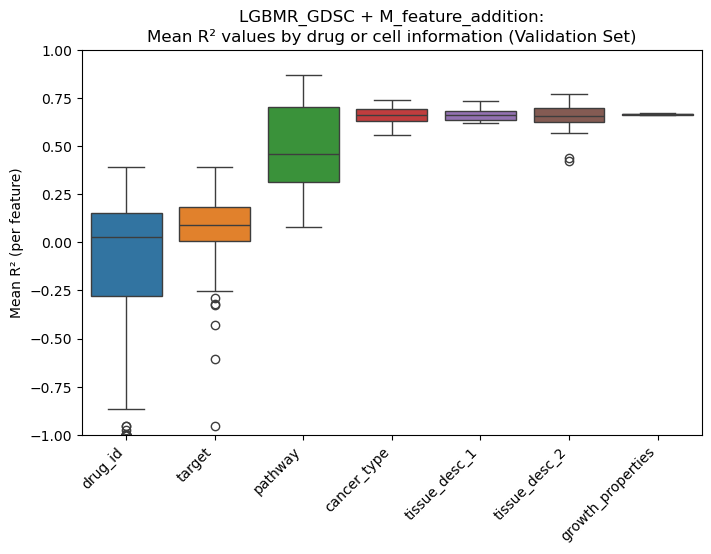

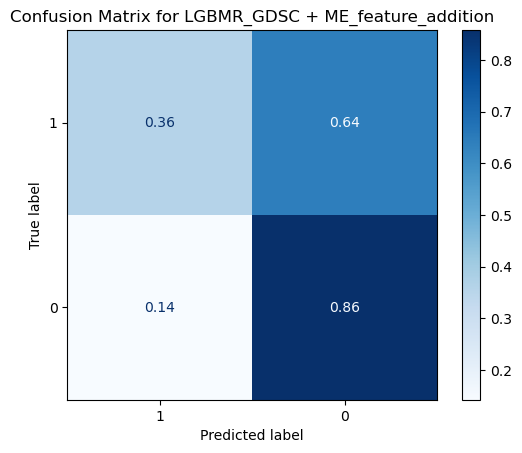

Plot y capped at -1 to 1 for Mean R2
Using columns: GDSC + MV
Processing model LGBMR_GDSC + MV_feature_addition
Mean y_pred: 2.87
Mean y_pred: 2.88


Model evaluation for LGBMRegressor: LGBMR_GDSC + MV_feature_addition completed.

Predicution column: LGBMR_GDSC + MV_feature_addition_y_pred


Number of drug-cancer combos with R2 above the Cuttoff of: 0.5




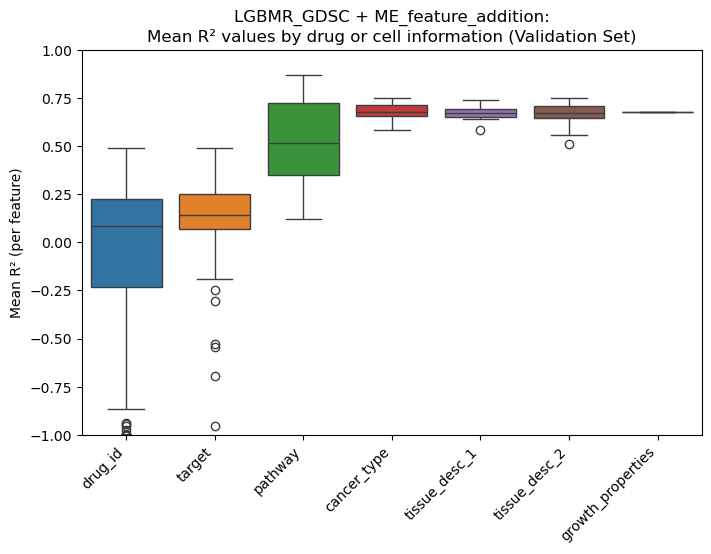

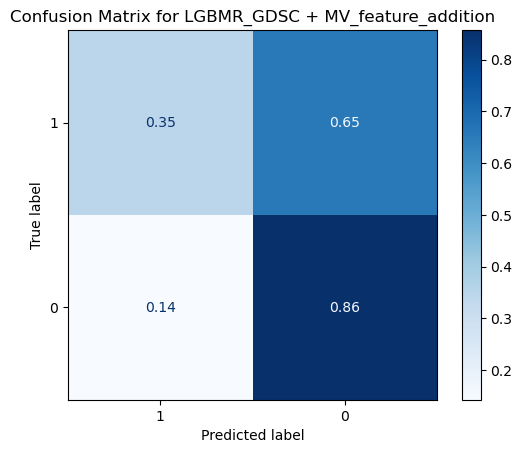

Plot y capped at -1 to 1 for Mean R2
Using columns: GDSC + MVE
Processing model LGBMR_GDSC + MVE_feature_addition
Mean y_pred: 2.87
Mean y_pred: 2.88


Model evaluation for LGBMRegressor: LGBMR_GDSC + MVE_feature_addition completed.

Predicution column: LGBMR_GDSC + MVE_feature_addition_y_pred


Number of drug-cancer combos with R2 above the Cuttoff of: 0.5




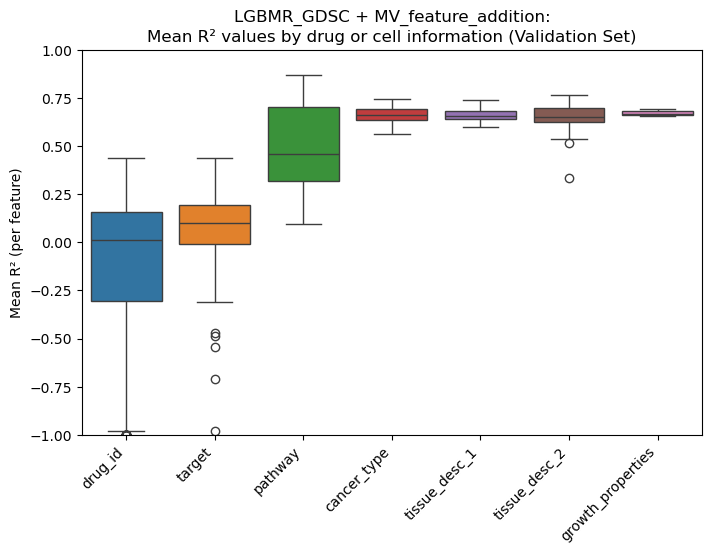

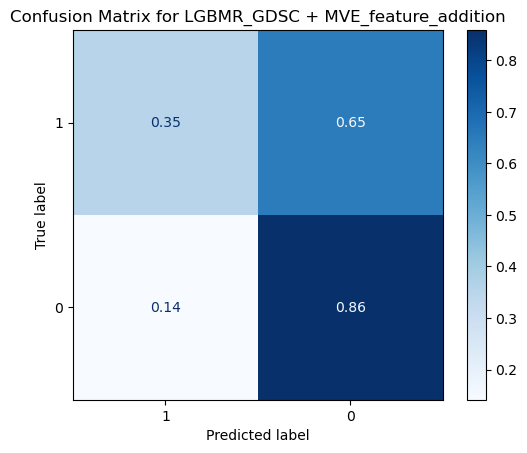

Plot y capped at -1 to 1 for Mean R2


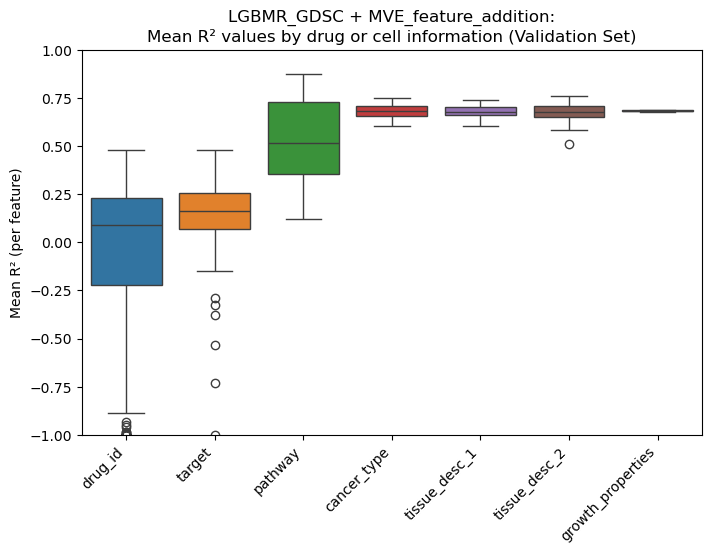

In [74]:
## Feature Addition with LGBMRegressor
feature_lists_dic = {
    'GDSC':       cols_C, # Core features
    'GDSC + M':   cols_CM, 
    'GDSC + ME':  cols_CME, 
    'GDSC + MV':  cols_CMV, 
    'GDSC + MVE': cols_CMVE,
    }

# Process each column set

for name_cols_used, cols_use in feature_lists_dic.items():
    ## --- Feature Preprocessing for Baseline Model ---
    # Create preprocessing pipelines for numerical and categorical features

    # Specify columns to use for preprocessing and modeling
    # Drop columns cols_C not in X_train
    cols_use = [col for col in X_train.columns if col in cols_use]  # ensure core features are included

    # setup X_train and X_val data with the col_use
    X_train_use  = X_train[cols_use]
    X_val_use    = X_val[cols_use]

    ## Baseine MLPRegressor with Pipeline
    ## -- edit this section per model --

    # Model information
    model_name = f"LGBMR_{name_cols_used}_feature_addition"
    model_type = 'LGBMRegressor'
    task_type  = 'regression'
    model_description = f"LGBMRegressor: {name_cols_used} feature addition"
    # model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

    # Y data and pos_label
    y_data_train  = y_train_reg[TARGET_COLUMN_REG]
    train_data_y_name = 'y_train_reg'
    y_data_val    = y_val_reg[TARGET_COLUMN_REG]
    val_data_y_name = 'y_val_reg'
    pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

    ## -- END EDIT ---

    # -- Train and evaluate the model --
    # track model info
    df_model_info = pd.concat([
        df_model_info, 
        pd.DataFrame([{
        'model_name'   : model_name,
        'model_type'   : model_type,
        'task_type'    : task_type,
        'feature_set'  : name_cols_used,
        'target_column': TARGET_COLUMN_REG,
        'train_data_X' : f"X_train[{name_cols_used}]",
        'train_data_y' : train_data_y_name,
        'val_data_X'   : f"X_val[{name_cols_used}]",
        'val_data_y'   : val_data_y_name,
        'train_sample_weights': 'nan', # no sample weights for dummy regressor
        'val_sample_weights'  : 'nan',
        'model_description': model_description
        }])
    ], ignore_index=True)


    print(f"Using columns: {name_cols_used}")
    print(f"Processing model {model_name}")
    preprocessor= get_preprocessor(X_train, cols_use=cols_use)
    #print(f"Preprocessor created for columns: {name_cols_used}")
    
    # Setup pipeline
    pipe = NamedPipeline(
        model_name,[              
            ('pre',    preprocessor),
            ('model',  lgb.LGBMRegressor(
                objective="rmse",
                n_jobs=-1,
                metric="rmse",
                random_state=RANDOM_SEED,
                verbose=-1,
            ))                  
        ]
    )
    
    # Fit the model to the training data
    start_time = time.time()
    pipe.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
    train_time = time.time() - start_time

    # store model for later
    models_dict[model_name] = pipe

    # Save amd Evalaute the model
    model_to_eval = pipe # EDIT FOR EACH PIPELINE

    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_train_use,)):.2f}")
    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_val_use,)):.2f}")
    
    ##print("Save model")
    #joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

    # Evaluate on train & val, logging into df_models_eval
    for X_data, y_data, w_data, split in [
        (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
        (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
        ]:

        # add predictions
        pred_col = f"{model_name}_y_pred"
        if split == "Train":
            df_train[pred_col] = model_to_eval.predict(X_data)
            y_pred = df_train[pred_col]
        else:
            df_val[pred_col]   = model_to_eval.predict(X_data)
            y_pred = df_val[pred_col]

        # regression metrics
        df_models_fa_eval = evaluate_model(
            model_to_eval, model_name, split,
            X_data, y_data,
            df_models_eval = df_models_fa_eval,
            train_time     = train_time,       # or search refit time if tracked
            pos_label      = None,             # regression
            round_to       = ROUND_TO
        )
        
        # binary metrics (if you have y_true_cat & threshold_per_drug)
        df_models_fa_eval, df_tmp = add_binary_metrics(
            df_models_results  = df_models_fa_eval,
            model_name         = model_name,
            split_name         = split,
            df                 = df_val if split == "Test" else df_train,
            y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
            y_pred             = y_pred,
            threshold_per_drug = threshhold_per_drug,
            pos_label          = 1,
            round_to           = ROUND_TO
        )

    print("\n")
    print(f"Model evaluation for {model_type}: {model_name} completed.")

    # print_df_markdown(df_models_eval)
    print(f"\nPredicution column: {pred_col}")

    print("\n")
    # Get top drug-cancer R2 per model
    r2_cuttoff = R2_CUTTOFF
    print(f"Number of drug-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
    df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                        feature_1='pathway',
                                        feature_2='cancer_type')
    print("\n")

    # Plot confusion matrix for validation set
    plot_confusion_matrix(
        y_val_cat[TARGET_COLUMN_CAT], 
        df_val[f"{model_name}_y_pred_bin"], 
        model_name, 
        labels=[1,0], 
        normalize='true'
        )

    print("Plot y capped at -1 to 1 for Mean R2")
    fig = plot_r2_by_feature(
        df_val, 
        y_val_reg[TARGET_COLUMN_REG], df_val[pred_col], 
        floor=-1,
        model_name=model_name)
    fig.savefig(RESULTS_DIR / f"{model_name}_boxplot_by_key_feature.png", dpi=300, bbox_inches='tight')
    fig.show()


## 5.2 Evaluate Feature Addition Nodels

#### Print performance metric table

In [75]:
# Print model results
print("Table of Model Performance:")
print_model_metrics(df_models_fa_eval, df_model_info, 'Train')
print("\n")

print_model_metrics(df_models_fa_eval, df_model_info, 'Test')

Table of Model Performance:
| Model Info                                 | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC feature addition       | Train   | regression   |  0.976 |      0.735 |       0.46  |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC + M feature addition   | Train   | regression   |  1.033 |      0.736 |       0.465 |    0.356 |   0.403 |      nan |  1.479 | 1.125 | 0.704 |     0.842 |      0.778 |
| LGBMRegressor: GDSC + ME feature addition  | Train   | regression   |  3.339 |      0.743 |       0.484 |    0.415 |   0.447 |      nan |  1.403 | 1.066 | 0.733 |     0.859 |      0.802 |
| LGBMRegressor: GDSC 


Ranking of models by average rank of RMSE, MAE, R2
| Model Info                                 |   avg_rank |   RMSE |    R2 |   MAE |
|:-------------------------------------------|-----------:|-------:|------:|------:|
| LGBMRegressor: GDSC + MVE feature addition |       1    |  1.516 | 0.692 | 1.152 |
| LGBMRegressor: GDSC + ME feature addition  |       2    |  1.524 | 0.689 | 1.159 |
| LGBMRegressor: GDSC feature addition       |       3    |  1.538 | 0.683 | 1.171 |
| LGBMRegressor: GDSC + MV feature addition  |       4.33 |  1.555 | 0.676 | 1.188 |
| LGBMRegressor: GDSC + M feature addition   |       4.67 |  1.556 | 0.675 | 1.187 |


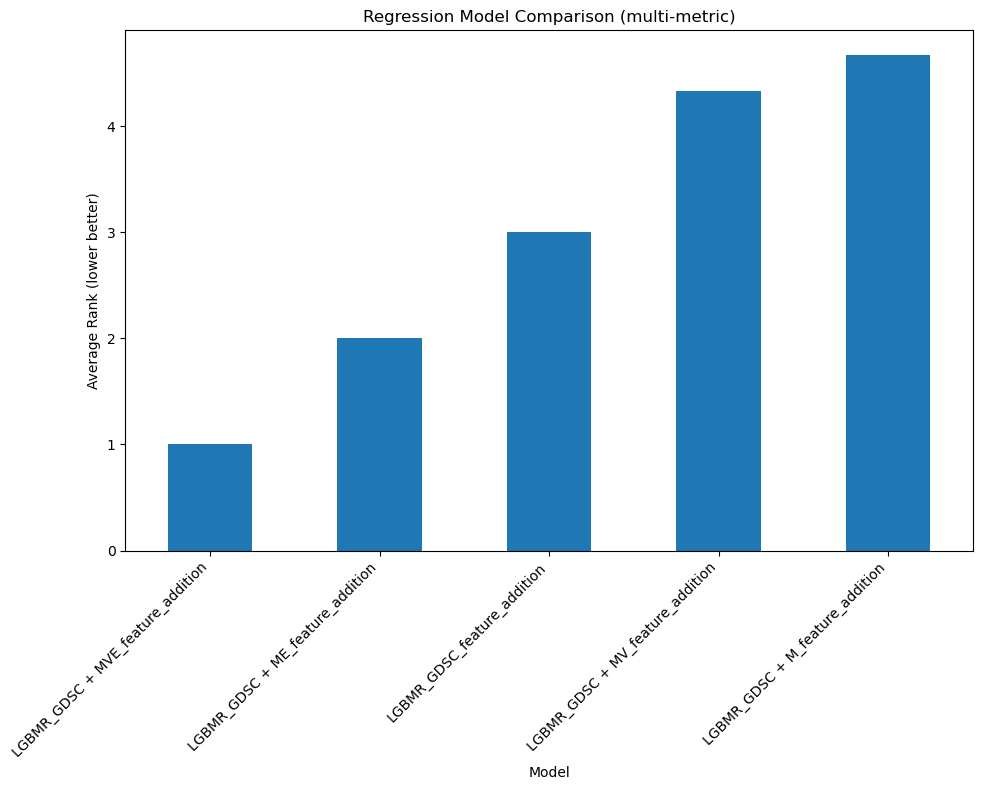

In [76]:

print("\nRanking of models by average rank of RMSE, MAE, R2")
fig = get_regression_model_rank(df_models_fa_eval, df_model_info)

#### Print and plot drug pathway-cancer R2 performance

Total number of unique drug pathway and cancer_type combinations: 622
Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                             |   0.0 |   0.1 |   0.2 |   0.3 |   0.4 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|:----------------------------------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Total Unique                      |   555 |   512 |   457 |   416 |   359 |   296 |   231 |   171 |   110 |    28 |
| LGBMR_GDSC_feature_addition       |   516 |   464 |   418 |   376 |   331 |   271 |   206 |   156 |    97 |    23 |
| LGBMR_GDSC + M_feature_addition   |   503 |   453 |   406 |   370 |   316 |   260 |   203 |   145 |    91 |    22 |
| LGBMR_GDSC + ME_feature_addition  |   532 |   479 |   434 |   387 |   331 |   279 |   216 |   158 |   105 |    20 |
| LGBMR_GDSC + MV_feature_addition  |   510 |   449 |   408 |   370 |   316 |   263 |   202 |   144 |    93 |    22 |
| LGBMR_GDSC + MVE_feature_addition |   5

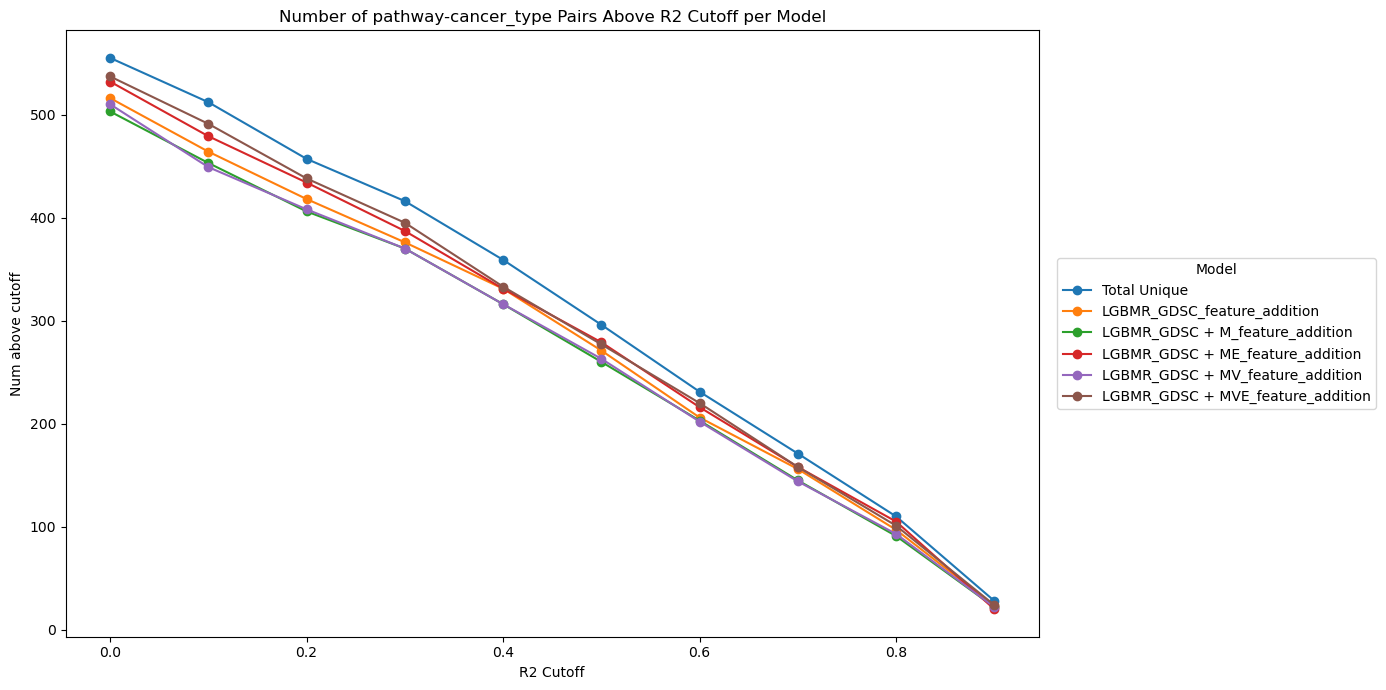

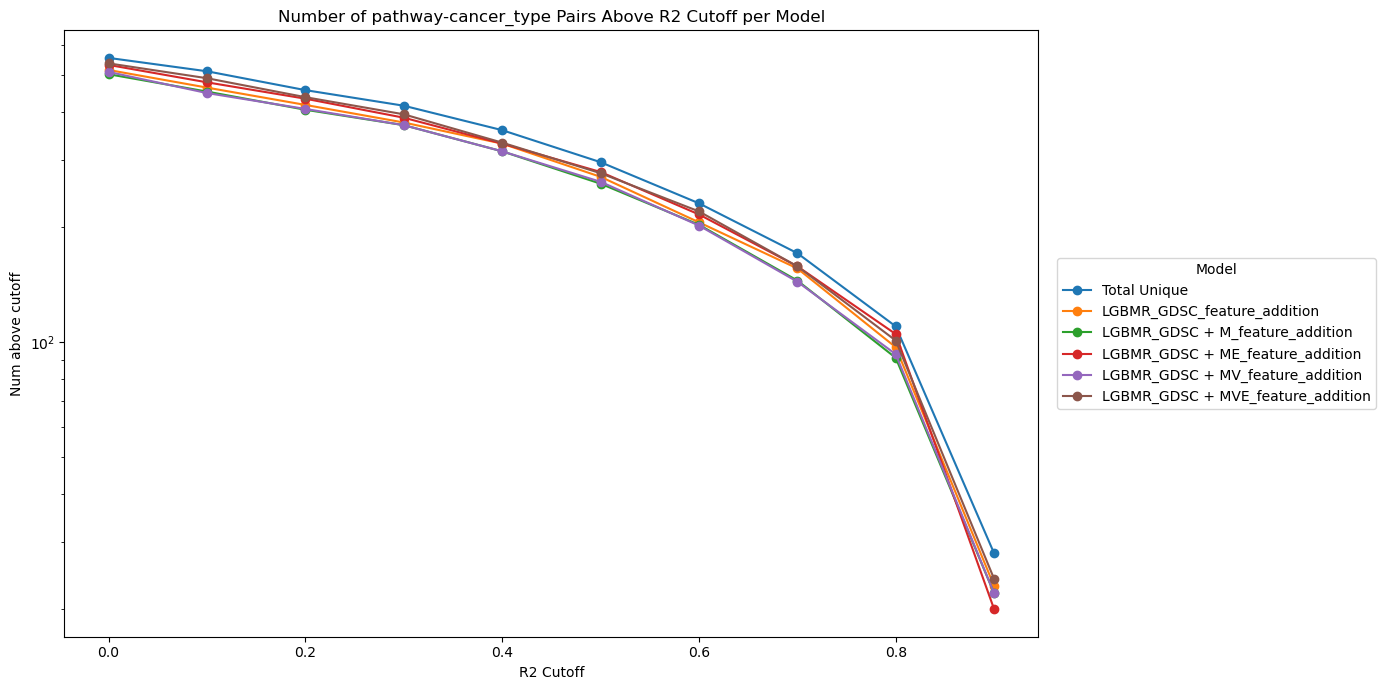

In [77]:
# Get top drug-cancer R2 per model

model_list, _ = check_ypredict_exists_in_df(df_val, df_models_fa_eval['Model'].unique().tolist()) 
model_list = [m for m in model_list if m.startswith('LGBMR')]

r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")

df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, model_list, 
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
fig_1.savefig(RESULTS_DIR / f"Feature_Addition_combo_r2_lineplot.png")
fig_1.show()

**INTERPRETATION:**

- Expression PCs (the “E” block) are by far the most valuable addition, driving both lower RMSE and higher coverage of well-predicted groups.

- Methylation (M) or mutation (V) on their own slightly degrade performance, but when combined with expression they yield marginal gains (CMVE vs CME).

- Trade-off: CME (GDSC + M + E) hits ~95 % of the full-block benefit (R² = 0.689 vs 0.692) with ~400 features instead of ~1 500 → faster training and simpler interpretation.



# 6 Final Model: Feature-Selection & Hyper-tune (using best feature combo)


**Capture results in df_models_fs_eval for Feature Selection**

In [78]:
# Setup model results dataframe for feature addition experiment
df_models_fs_eval = evaluate_model()


# capture imporant_features in a dictionary
important_features_dict = {}

## 6.1: Make a subset of the dataset for feature selection and hyper-tuning

To reduce the time to perform permutation importance, 20% of the drugs are randomly selected for permutation.

The final model will be trained on the full drug set using the importance features from the permutation.

In [79]:
# get subsets of data for hyper-tuning (not needed if already working with a subset)

if PROCESS_ALL_DRUGS & PROCESS_SUBSET_FEATURE_SEARCH:
    drug_ids = X_train.drug_id.unique()
    num_total_drugs = len(drug_ids)
    print(f"Out of {num_total_drugs}")

    # Calculate number of drugs to sample (20%)
    num_sample = int(np.ceil(num_total_drugs * DRUG_SUBSET_FRACTION))

    # Randomly select indices without replacement
    np.random.seed(RANDOM_SEED)  # for reproducibility if RANDOM_SEED is defined
    sampled_idx = np.random.choice(num_total_drugs, size=num_sample, replace=False)
    # Get the sampled drug_ids
    drug_ids_subset = drug_ids[sampled_idx].tolist()
    print(f"Selected {len(drug_ids_subset)} drug_ids ({DRUG_SUBSET_FRACTION*100}%) for perform Feature Selection permutation importance")

    # check to see if this is needed when workint with the full drug set
    if PROCESS_ALL_DRUGS: 
        # Make a subset for hyper-tuning
        X_train_sub     = X_train[X_train['drug_id'].isin(drug_ids_subset)].copy()
        y_train_reg_sub = y_train_reg[y_train_reg['drug_id'].isin(drug_ids_subset)].copy()
        y_train_cat_sub = y_train_cat[y_train_cat ['drug_id'].isin(drug_ids_subset)].copy()
        
        X_val_sub    = X_val[X_val['drug_id'].isin(drug_ids_subset)].copy()
        y_val_reg_sub = y_val_reg[y_val_reg['drug_id'].isin(drug_ids_subset)].copy()
        y_val_cat_sub   = y_val_cat[y_val_cat['drug_id'].isin(drug_ids_subset)].copy()
        
        w_train_sub = df_train['w'][df_train['drug_id'].isin(drug_ids_subset)].copy().values.astype("float32")
        w_val_sub   = df_val['w'][df_val['drug_id'].isin(drug_ids_subset)].copy().values.astype("float32")

Out of 286
Selected 58 drug_ids (20.0%) for perform Feature Selection permutation importance


## 6.2 MLPRegressor  Feature Selection with Permutation_importance

hidden_layer_sizes: try 1–3 layers, 50–200 units.

activation: relu is default and often best, but tanh can help on smaller nets.

alpha: L2 weight penalty—search across several orders of magnitude.

learning_rate_init: starting step‐size for Adam; smaller steps for deeper nets.

learning_rate: adaptive will reduce the rate when training plateaus.

early_stopping: automatically holds out a bit of your training data to stop before overfitting.

tol and n_iter_no_change control when optimization halts.

In [80]:
if False:

    feature_lists_dic = {
        'GDSC':   cols_C, # Core features
        #'GDSC + M':  cols_CM, 
        'GDSC + ME': cols_CME, 
        #'GDSC + MV': cols_CMV, 
        #'GDSC + MVE': cols_CMVE,
        }

    # Process each column set
    for name_cols_used, cols_use in feature_lists_dic.items():
        ## --- Feature Preprocessing for Baseline Model ---
        # Create preprocessing pipelines for numerical and categorical features

        ## Baseine MLPRegressor with Pipeline
        ## -- edit this section per model --

        # Model information
        model_name_original = f"MLP_{name_cols_used}_feature_addition"
        model_name = f"MLP_{name_cols_used}_feature_selection"
        model_type = 'MLPegressor '
        task_type  = 'regression'
        model_description = f"MLPRegressor: {name_cols_used} feature selection"
        # model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

        # Specify columns to use for preprocessing and modeling
        # Drop columns cols_C not in X_train
        cols_use = [col for col in X_train.columns if col in cols_use]  # ensure core features are included

        # Hyper-tune on a subset
        if PROCESS_ALL_DRUGS & PROCESS_SUBSET_FEATURE_SEARCH:
            print(f"Perform selection on a subset of {X_train_sub.drug_id.nunique()} drugs")
            # Make a subset for hyper-tuning
            X_train_use       = X_train_sub[cols_use]
            y_train_data_reg  = y_train_reg_sub[TARGET_COLUMN_REG]

            X_val_use         = X_val_sub[cols_use]
            y_val_data_reg    = y_val_reg_sub[TARGET_COLUMN_REG] 
            
            w_train_use = w_train_sub
            w_val_use   = w_val_sub   
        else:

            X_train_use       = X_train[cols_use]
            y_train_data_reg  = y_train_reg[TARGET_COLUMN_REG]

            X_val_use         = X_val[cols_use]
            # Y data and pos_label
            y_val_data_reg         = y_val_reg[TARGET_COLUMN_REG]
            
            w_train_use = w_train
            w_val_use   = w_val


        # setup X_train and X_val data with the col_use
        # X_train_use  = X_train[cols_use]
        # X_val_use    = X_val[cols_use]

        # Y data and pos_label
        y_data_train  = y_train_reg[TARGET_COLUMN_REG]
        train_data_y_name = 'y_train_reg'
        #y_data_val    = y_val_reg[TARGET_COLUMN_REG]
        val_data_y_name = 'y_val_reg'
        pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

        ## -- END EDIT ---

        # -- Train and evaluate the model --
        # track model info
        df_model_info = pd.concat([
            df_model_info, 
            pd.DataFrame([{
            'model_name'   : model_name,
            'model_type'   : model_type,
            'task_type'    : task_type,
            'feature_set'  : name_cols_used,
            'target_column': TARGET_COLUMN_REG,
            'train_data_X' : f"X_train[{name_cols_used}]_permute",
            'train_data_y' : train_data_y_name,
            'val_data_X'   : f"X_val[{name_cols_used}]_permute",
            'val_data_y'   : val_data_y_name,
            'train_sample_weights': 'nan', # no sample weights for dummy regressor
            'val_sample_weights'  : 'nan',
            'model_description': model_description
            }])
        ], ignore_index=True)


        print(f"Using columns: {name_cols_used}")
        print(f"Processing model {model_name} from the oringal model: {model_name_original}")
        
        # get the full pipeline used in Feature Addition experiment
        pipe = clone(models_dict[model_name_original])

        # # re-Fit the model to the training data to ensure correct model is pulled
        start_time = time.time()
        pipe.fit(X_train_use, y_train_data_reg)
        train_time = time.time() - start_time

        ## Perform permutation importance
        res = permutation_importance(
            pipe, X_val_use, y_val_data_reg,
            scoring='neg_root_mean_squared_error',
            n_repeats=10,
            random_state=42
        )

        # # grab features whose importance > 0
        start_time = time.time()
        important_features = X_train_use.columns[res.importances_mean > 0]
        prune_time = time.time() - start_time
        print(f"Feature Selection took {prune_time} sec")

        # retain important features for future use
        important_features_dict[model_type] = {name_cols_used: important_features}

        ## -- implement reduced features on the full data set
        # reset data to use to the full data set being processed (all or specified drugs)
        X_train_use     = X_train[cols_use]
        y_train_data   = y_train_reg[TARGET_COLUMN_REG]

        X_val_use       = X_val[cols_use]
        # Y data and pos_label
        y_val_data       = y_val_reg[TARGET_COLUMN_REG]
            
        X_train_use = X_train_use[important_features]
        X_val_use   = X_val_use[important_features]
        preprocessor= get_preprocessor(X_train, cols_use=important_features)

        pipe_reduced = NamedPipeline(
            model_name,[              
                ('pre',    preprocessor),
                ('model',  pipe.named_steps['model'])  # get original model again for fitting            
            ]
        )

        ## Re-Fit pipe with reduced features
        print("Fitting reduced dataset")
        start_time = time.time()
        pipe_reduced.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
        train_time = time.time() - start_time


        # store model for later
        models_dict[model_name] = pipe_reduced

        # Save amd Evalaute the model
        model_to_eval = pipe_reduced # EDIT FOR EACH PIPELINE

        print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_train_use,)).round(2)}")
        print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_val_use,)).round(2)}")
        ##print("Save model")
        #joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

        # Evaluate on train & val, logging into df_models_eval
        for X_data, y_data, w_data, split in [
            (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
            (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
            ]:

            # add predictions
            pred_col = f"{model_name}_y_pred"
            if split == "Train":
                df_train[pred_col] = model_to_eval.predict(X_data)
                y_pred = df_train[pred_col]
            else:
                df_val[pred_col]   = model_to_eval.predict(X_data)
                y_pred = df_val[pred_col]

            # regression metrics
            df_models_fs_eval = evaluate_model(
                model_to_eval, model_name, split,
                X_data, y_data,
                df_models_eval = df_models_fs_eval,
                train_time     = train_time,       # or search refit time if tracked
                pos_label      = None,             # regression
                round_to       = ROUND_TO
            )
            
            # binary metrics (if you have y_true_cat & threshold_per_drug)
            df_models_fs_eval, df_tmp = add_binary_metrics(
                df_models_results  = df_models_fs_eval,
                model_name         = model_name,
                split_name         = split,
                df                 = df_val if split == "Test" else df_train,
                y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
                y_pred             = y_pred,
                threshold_per_drug = threshhold_per_drug,
                pos_label          = 1,
                round_to           = ROUND_TO
            )

        print("\n")
        print(f"Model evaluation for {model_type}: {model_name} completed.")

        # print_df_markdown(df_models_eval)
        print(f"\nPredicution column: {pred_col}")

        print(f" Oringal number of features in {name_cols_used} {len(cols_use)} was \
            reduced by {len(cols_use)- len(important_features)} to {len(important_features)}")

        print("\n")
        # Get top drug-cancer R2 per model
        r2_cuttoff = R2_CUTTOFF
        print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
        #print("\n")
        #print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
        #df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
        df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                                feature_1='pathway',
                                                feature_2='cancer_type')
        print("\n")
        print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}:")
        print_df_markdown(df_drugcancer_hits)

        print("\n")
    
        df_dc_scores = plot_combos_cuffoff_scores(df_val, [model_name_original, model_name],     
                                            0, 'ln_ic50', 
                                            feature_1='pathway',
                                            feature_2='cancer_type',
                                            log_plot='both')



    print("Table of Model Performance:")
    print_model_metrics(df_models_fs_eval, df_model_info, 'Train')
    print("\n")

    print_model_metrics(df_models_fs_eval, df_model_info, 'Test')


## 6.3 LBMRegressor Feature Selection with Permutation_importance

Perform feature slection on the fly using permutation_importance

Perform selection on a subset of 58 drugs
Using columns: GDSC
Processing model LGBMR_GDSC_feature_selection from the oringal model: LGBMR_GDSC_feature_addition
Feature Selection took 1.5020370483398438e-05 sec
Fitting reduced dataset
Mean y_pred: 2.87
Mean y_pred: 2.86


Model evaluation for LGBMRegressor: LGBMR_GDSC_feature_selection completed.

Predicution column: LGBMR_GDSC_feature_selection_y_pred
 Oringal number of features in GDSC 7 was           reduced by 0 to 7


Total number of unique drug pathway and cancer_type combinations: 622


Results for pathway-cancer combos above cuttoff of 0.5:
| Model                        |   Num above cuttoff |   Max |   Mean |
|:-----------------------------|--------------------:|------:|-------:|
| LGBMR_GDSC_feature_selection |                 271 |  0.95 |   0.73 |


Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                        |   0.0 |   0.1 |   0.2 |   0.3 |   0.4 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|

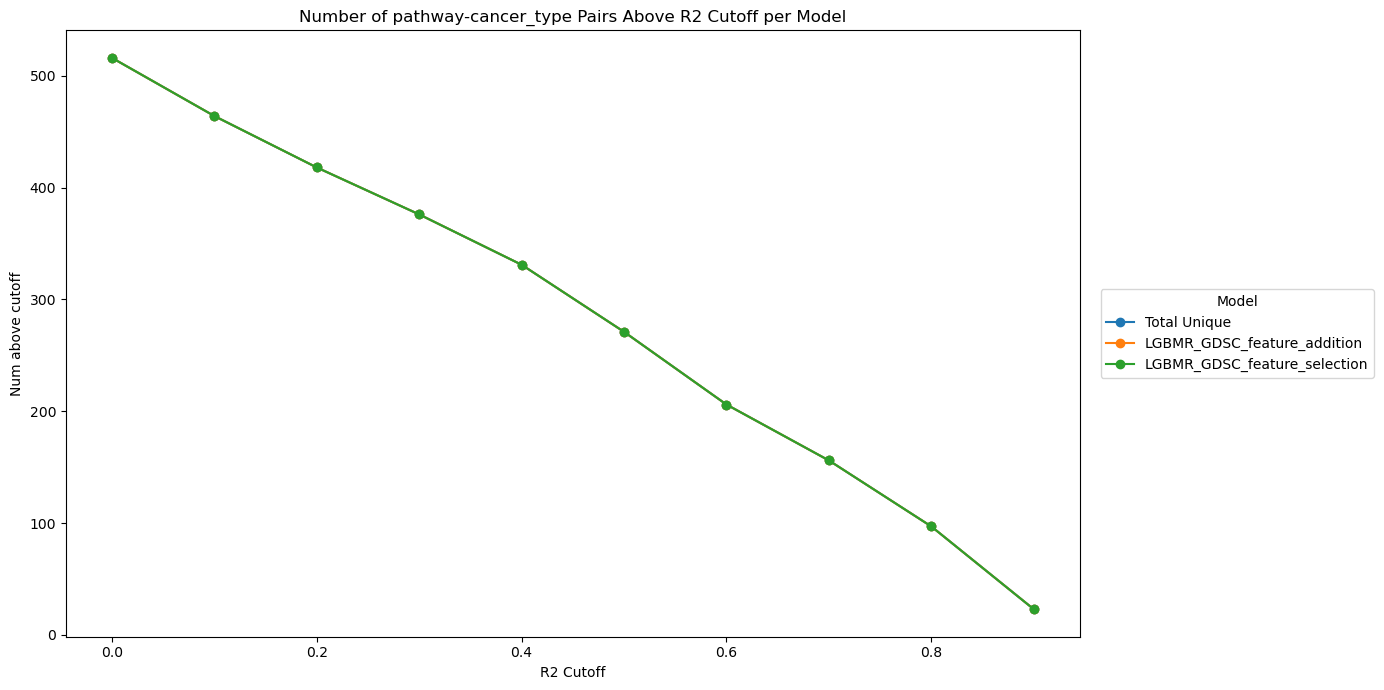

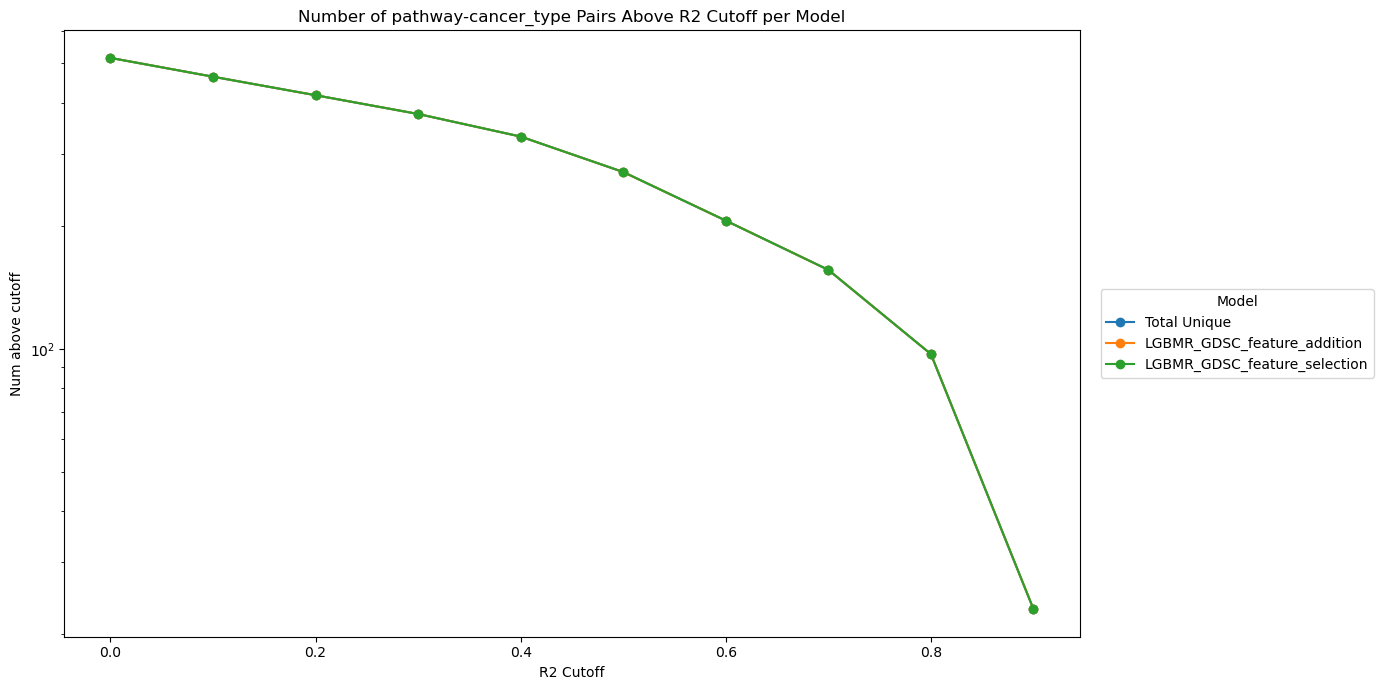

Perform selection on a subset of 58 drugs
Using columns: GDSC + ME
Processing model LGBMR_GDSC + ME_feature_selection from the oringal model: LGBMR_GDSC + ME_feature_addition
Feature Selection took 1.8835067749023438e-05 sec
Fitting reduced dataset
Mean y_pred: 2.87
Mean y_pred: 2.88


Model evaluation for LGBMRegressor: LGBMR_GDSC + ME_feature_selection completed.

Predicution column: LGBMR_GDSC + ME_feature_selection_y_pred
 Oringal number of features in GDSC + ME 109 was           reduced by 38 to 71


Total number of unique drug pathway and cancer_type combinations: 622


Results for pathway-cancer combos above cuttoff of 0.5:
| Model                             |   Num above cuttoff |   Max |   Mean |
|:----------------------------------|--------------------:|------:|-------:|
| LGBMR_GDSC + ME_feature_selection |                 281 |  0.95 |   0.73 |


Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                             |   0.0 |   0.1 |   0.2 |   0

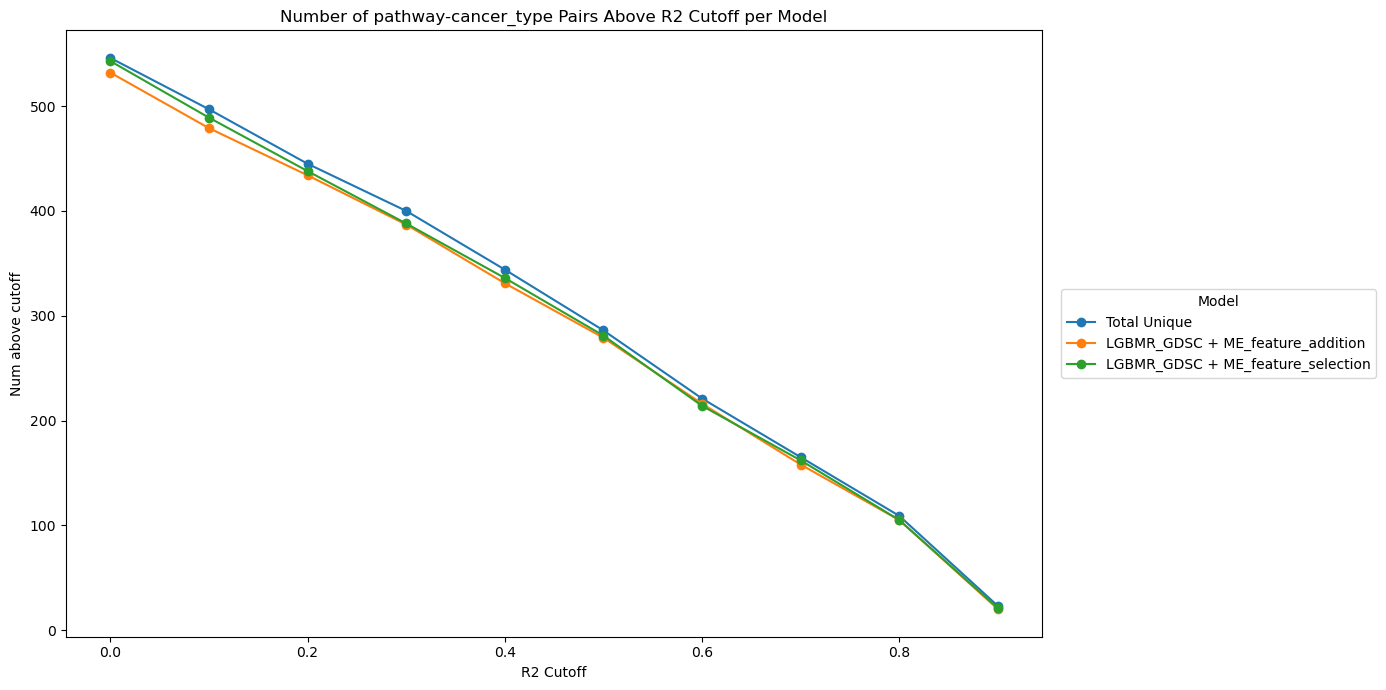

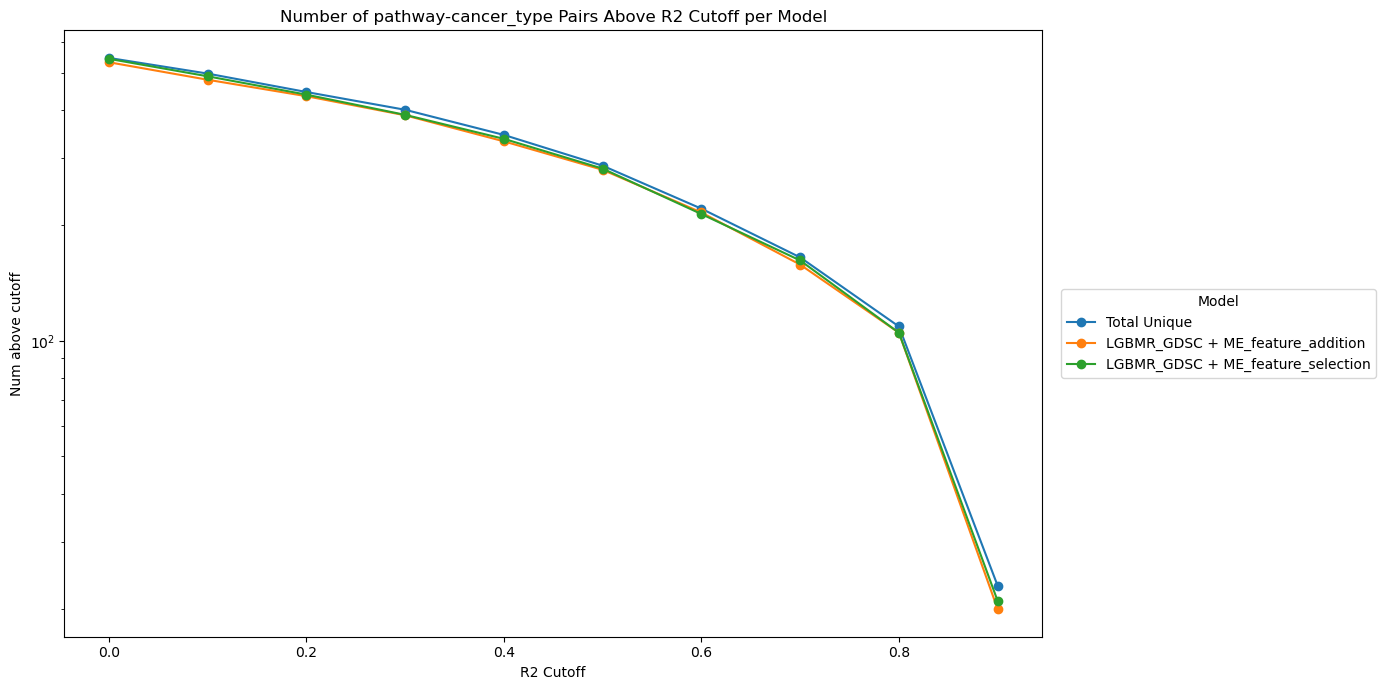

Table of Model Performance:
| Model Info                                 | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:-------------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|----------:|-----------:|
| LGBMRegressor: GDSC feature selection      | Train   | regression   |  0.928 |      0.735 |       0.46  |    0.34  |   0.391 |      nan |  1.528 | 1.163 | 0.684 |     0.829 |      0.756 |
| LGBMRegressor: GDSC + ME feature selection | Train   | regression   |  2.592 |      0.743 |       0.483 |    0.412 |   0.445 |      nan |  1.405 | 1.067 | 0.733 |     0.859 |      0.801 |


| Model Info                                 | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |   Pearson |   Spearman |
|:------------------

In [81]:
feature_lists_dic = {
    'GDSC':   cols_C, # Core features
    #'GDSC + M':  cols_CM, 
    'GDSC + ME': cols_CME, 
    #'GDSC + MV': cols_CMV, 
    #'GDSC + MVE': cols_CMVE,
    }

# Process each column set
for name_cols_used, cols_use in feature_lists_dic.items():
    ## --- Feature Preprocessing for Baseline Model ---
    # Create preprocessing pipelines for numerical and categorical features

    ## Baseine MLPRegressor with Pipeline
    ## -- edit this section per model --

    # Model information
    model_name_original = f"LGBMR_{name_cols_used}_feature_addition"
    model_name = f"LGBMR_{name_cols_used}_feature_selection"
    model_type = 'LGBMRegressor'
    task_type  = 'regression'
    model_description = f"LGBMRegressor: {name_cols_used} feature selection"
    # model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

    # Specify columns to use for preprocessing and modeling
    # Drop columns cols_C not in X_train
    cols_use = [col for col in X_train.columns if col in cols_use]  # ensure core features are included

    # Hyper-tune on a subset
    if PROCESS_ALL_DRUGS & PROCESS_SUBSET_FEATURE_SEARCH:
        print(f"Perform selection on a subset of {X_train_sub.drug_id.nunique()} drugs")
        # Make a subset for hyper-tuning
        X_train_use       = X_train_sub[cols_use]
        y_train_data_reg  = y_train_reg_sub[TARGET_COLUMN_REG]

        X_val_use         = X_val_sub[cols_use]
        y_val_data_reg    = y_val_reg_sub[TARGET_COLUMN_REG] 
        
        w_train_use = w_train_sub
        w_val_use   = w_val_sub   
    else:

        X_train_use       = X_train[cols_use]
        y_train_data_reg  = y_train_reg[TARGET_COLUMN_REG]

        X_val_use         = X_val[cols_use]
        # Y data and pos_label
        y_val_data_reg         = y_val_reg[TARGET_COLUMN_REG]
        
        w_train_use = w_train
        w_val_use   = w_val


    # setup X_train and X_val data with the col_use
    # X_train_use  = X_train[cols_use]
    # X_val_use    = X_val[cols_use]

    # Y data and pos_label
    y_data_train  = y_train_reg[TARGET_COLUMN_REG]
    train_data_y_name = 'y_train_reg'
    #y_data_val    = y_val_reg[TARGET_COLUMN_REG]
    val_data_y_name = 'y_val_reg'
    pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

    ## -- END EDIT ---

    # -- Train and evaluate the model --
    # track model info
    df_model_info = pd.concat([
        df_model_info, 
        pd.DataFrame([{
        'model_name'   : model_name,
        'model_type'   : model_type,
        'task_type'    : task_type,
        'feature_set'  : name_cols_used,
        'target_column': TARGET_COLUMN_REG,
        'train_data_X' : f"X_train[{name_cols_used}]_permute",
        'train_data_y' : train_data_y_name,
        'val_data_X'   : f"X_val[{name_cols_used}]_permute",
        'val_data_y'   : val_data_y_name,
        'train_sample_weights': 'nan', # no sample weights for dummy regressor
        'val_sample_weights'  : 'nan',
        'model_description': model_description
        }])
    ], ignore_index=True)


    print(f"Using columns: {name_cols_used}")
    print(f"Processing model {model_name} from the oringal model: {model_name_original}")
    
    # get the full pipeline used in Feature Addition experiment
    pipe = clone(models_dict[model_name_original])

    # # re-Fit the model to the training data to ensure correct model is pulled
    start_time = time.time()
    pipe.fit(X_train_use, y_train_data_reg)
    train_time = time.time() - start_time

    ## Perform permutation importance
    res = permutation_importance(
        pipe, X_val_use, y_val_data_reg,
        scoring='neg_root_mean_squared_error',
        n_repeats=10,
        random_state=42
    )

    # # grab features whose importance > 0

    start_time = time.time()
    important_features = X_train_use.columns[res.importances_mean > 0]
    prune_time = time.time() - start_time
    print(f"Feature Selection took {prune_time} sec")


    # retain important features for future use
    important_features_dict[model_type] = {name_cols_used: important_features}

    ## -- implement reduced features on the full data set
    # reset data to use to the full data set being processed (all or specified drugs)
    X_train_use     = X_train[cols_use]
    y_train_data   = y_train_reg[TARGET_COLUMN_REG]

    X_val_use       = X_val[cols_use]
    # Y data and pos_label
    y_val_data       = y_val_reg[TARGET_COLUMN_REG]
        
    X_train_use = X_train_use[important_features]
    X_val_use   = X_val_use[important_features]
    preprocessor= get_preprocessor(X_train, cols_use=important_features)

    pipe_reduced = NamedPipeline(
        model_name,[              
            ('pre',    preprocessor),
            ('model',  pipe.named_steps['model'])                  
        ]
    )

    ## Re-Fit pipe with reduced features
    print("Fitting reduced dataset")
    start_time = time.time()
    pipe_reduced.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
    train_time = time.time() - start_time


    # store model for later
    models_dict[model_name] = pipe_reduced

    # Save amd Evalaute the model
    model_to_eval = pipe_reduced # EDIT FOR EACH PIPELINE

    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_train_use,)).round(2)}")
    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_val_use,)).round(2)}")
    ##print("Save model")
    #joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

    # Evaluate on train & val, logging into df_models_eval
    for X_data, y_data, w_data, split in [
        (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
        (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
        ]:

        # add predictions
        pred_col = f"{model_name}_y_pred"
        if split == "Train":
            df_train[pred_col] = model_to_eval.predict(X_data)
            y_pred = df_train[pred_col]
        else:
            df_val[pred_col]   = model_to_eval.predict(X_data)
            y_pred = df_val[pred_col]

        # regression metrics
        df_models_fs_eval = evaluate_model(
            model_to_eval, model_name, split,
            X_data, y_data,
            df_models_eval = df_models_fs_eval,
            train_time     = train_time,       # or search refit time if tracked
            pos_label      = None,             # regression
            round_to       = ROUND_TO
        )
        
        # binary metrics (if you have y_true_cat & threshold_per_drug)
        df_models_fs_eval, df_tmp = add_binary_metrics(
            df_models_results  = df_models_fs_eval,
            model_name         = model_name,
            split_name         = split,
            df                 = df_val if split == "Test" else df_train,
            y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
            y_pred             = y_pred,
            threshold_per_drug = threshhold_per_drug,
            pos_label          = 1,
            round_to           = ROUND_TO
        )

    print("\n")
    print(f"Model evaluation for {model_type}: {model_name} completed.")

    # print_df_markdown(df_models_eval)
    print(f"\nPredicution column: {pred_col}")

    print(f" Oringal number of features in {name_cols_used} {len(cols_use)} was \
          reduced by {len(cols_use)- len(important_features)} to {len(important_features)}")

    print("\n")
    # Get top drug-cancer R2 per model
    r2_cuttoff = R2_CUTTOFF
    print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
    #print("\n")
    #print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
    #df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
    df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50', 
                                            feature_1='pathway',
                                            feature_2='cancer_type')
    print("\n")
    print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}:")
    print_df_markdown(df_drugcancer_hits)

    print("\n")
  
    df_dc_scores = plot_combos_cuffoff_scores(df_val, [model_name_original, model_name],     
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')



print("Table of Model Performance:")
print_model_metrics(df_models_fs_eval, df_model_info, 'Train')
print("\n")

print_model_metrics(df_models_fs_eval, df_model_info, 'Test')

Compare hyper-tune feature selection model to baseline or feature addition model for drug-cancer



Total number of unique drug pathway and cancer_type combinations: 622
Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                             |   0.0 |   0.1 |   0.2 |   0.3 |   0.4 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|:----------------------------------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Total Unique                      |   550 |   503 |   445 |   401 |   353 |   292 |   222 |   168 |   110 |    26 |
| LGBMR_GDSC_feature_selection      |   516 |   464 |   418 |   376 |   331 |   271 |   206 |   156 |    97 |    23 |
| LGBMR_GDSC + ME_feature_selection |   543 |   489 |   438 |   388 |   336 |   281 |   214 |   162 |   105 |    21 |


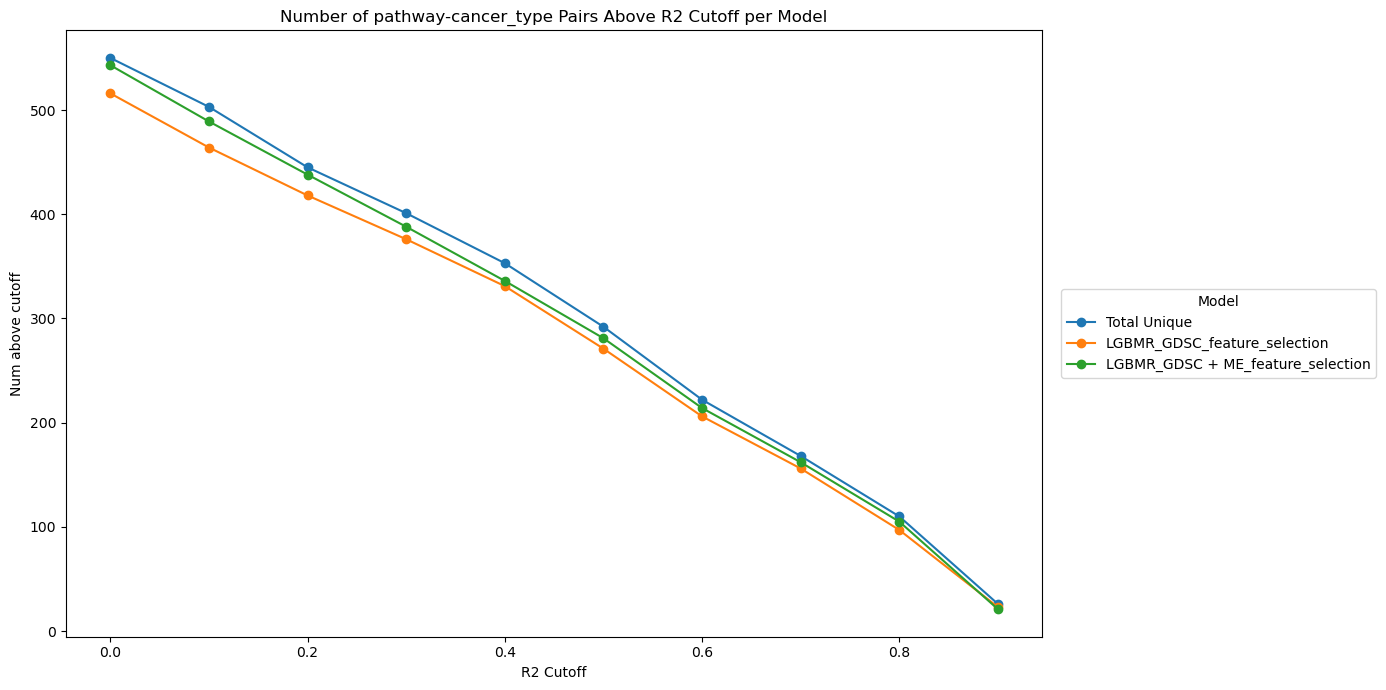

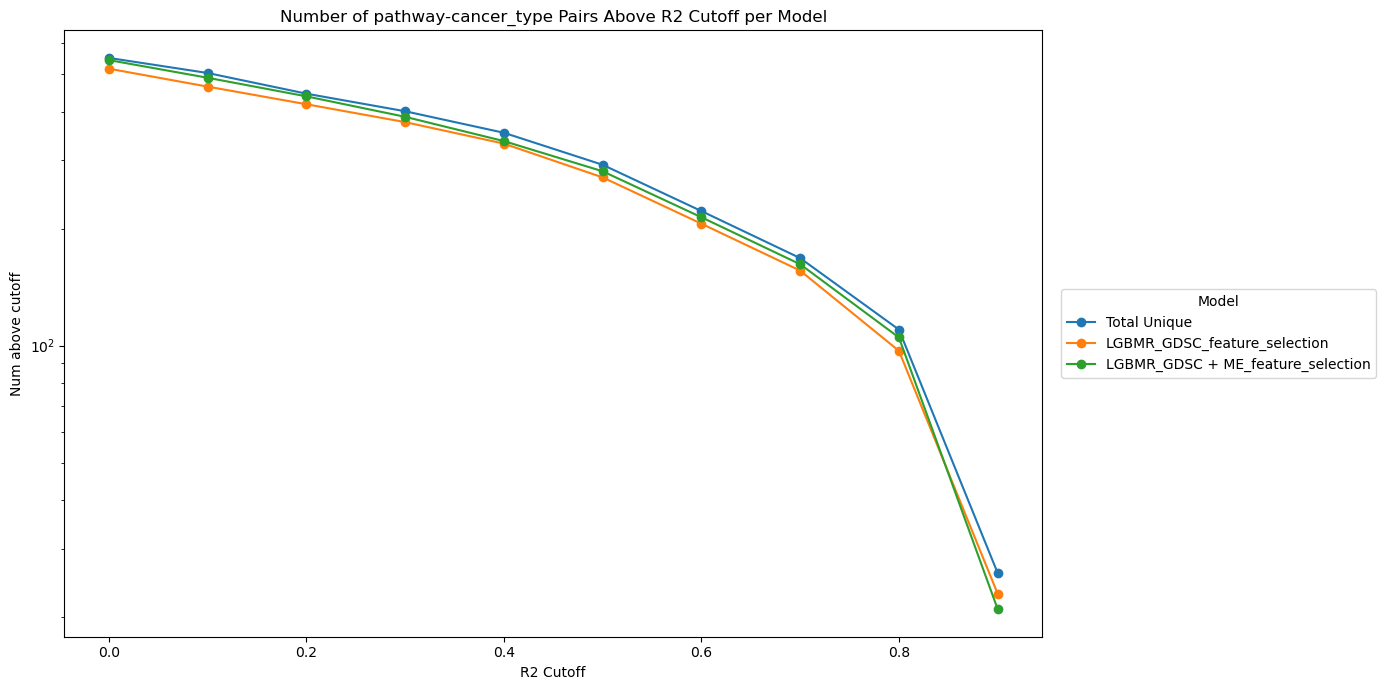

In [82]:
model_list, _ = check_ypredict_exists_in_df(df_val, df_models_fs_eval['Model'].unique().tolist()) 
model_list = [m for m in model_list if m.startswith('LGBMR')]

r2_cuttoff = R2_CUTTOFF

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")

df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, model_list, 
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
fig_1.savefig(RESULTS_DIR / f"Feature_Selection_combo_r2_lineplot.png")
fig_1.show()

#### Get number of features per model

In [83]:

for key in model_list:
    n = models_dict[key].named_steps['model'].n_features_in_
    print(f"The model {key} was trained on {n} features.")

The model LGBMR_GDSC_feature_selection was trained on 309 features.
The model LGBMR_GDSC + ME_feature_selection was trained on 323 features.


In [84]:
df_tmp = pd.concat([df_models_fa_eval, df_models_fs_eval])
print("Table of Model Performance:")
# print_model_metrics(df_tmp, df_model_info, 'Train')
# print("\n")
columns = ['Model','Split','Time','Accuracy','Precision','Recall','FBeta','RMSE','MAE','R2']

print_model_metrics(df_tmp[columns], df_model_info, 'Test')

Table of Model Performance:
| Model Info                                 | Split   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   RMSE |   MAE |    R2 |
|:-------------------------------------------|:--------|-------:|-----------:|------------:|---------:|--------:|-------:|------:|------:|
| LGBMRegressor: GDSC feature addition       | Test    |  0.072 |      0.729 |       0.46  |    0.355 |   0.401 |  1.538 | 1.171 | 0.683 |
| LGBMRegressor: GDSC + M feature addition   | Test    |  0.076 |      0.726 |       0.451 |    0.343 |   0.39  |  1.556 | 1.187 | 0.675 |
| LGBMRegressor: GDSC + ME feature addition  | Test    |  0.152 |      0.731 |       0.464 |    0.36  |   0.406 |  1.524 | 1.159 | 0.689 |
| LGBMRegressor: GDSC + MV feature addition  | Test    |  0.381 |      0.727 |       0.453 |    0.345 |   0.392 |  1.555 | 1.188 | 0.676 |
| LGBMRegressor: GDSC + MVE feature addition | Test    |  0.394 |      0.73  |       0.461 |    0.354 |   0.401 |  1.516 | 1.152 | 0.692 |

Total number of unique drug pathway and cancer_type combinations: 622
Number of pathway-cancer_type combos with R2 above the Cuttoff
| Model                             |   0.0 |   0.1 |   0.2 |   0.3 |   0.4 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|:----------------------------------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Total Unique                      |   551 |   509 |   450 |   409 |   357 |   294 |   227 |   171 |   112 |    26 |
| LGBMR_GDSC_feature_selection      |   516 |   464 |   418 |   376 |   331 |   271 |   206 |   156 |    97 |    23 |
| LGBMR_GDSC + ME_feature_selection |   543 |   489 |   438 |   388 |   336 |   281 |   214 |   162 |   105 |    21 |
| LGBMR_GDSC_feature_addition       |   516 |   464 |   418 |   376 |   331 |   271 |   206 |   156 |    97 |    23 |
| LGBMR_GDSC + ME_feature_addition  |   532 |   479 |   434 |   387 |   331 |   279 |   216 |   158 |   105 |    20 |


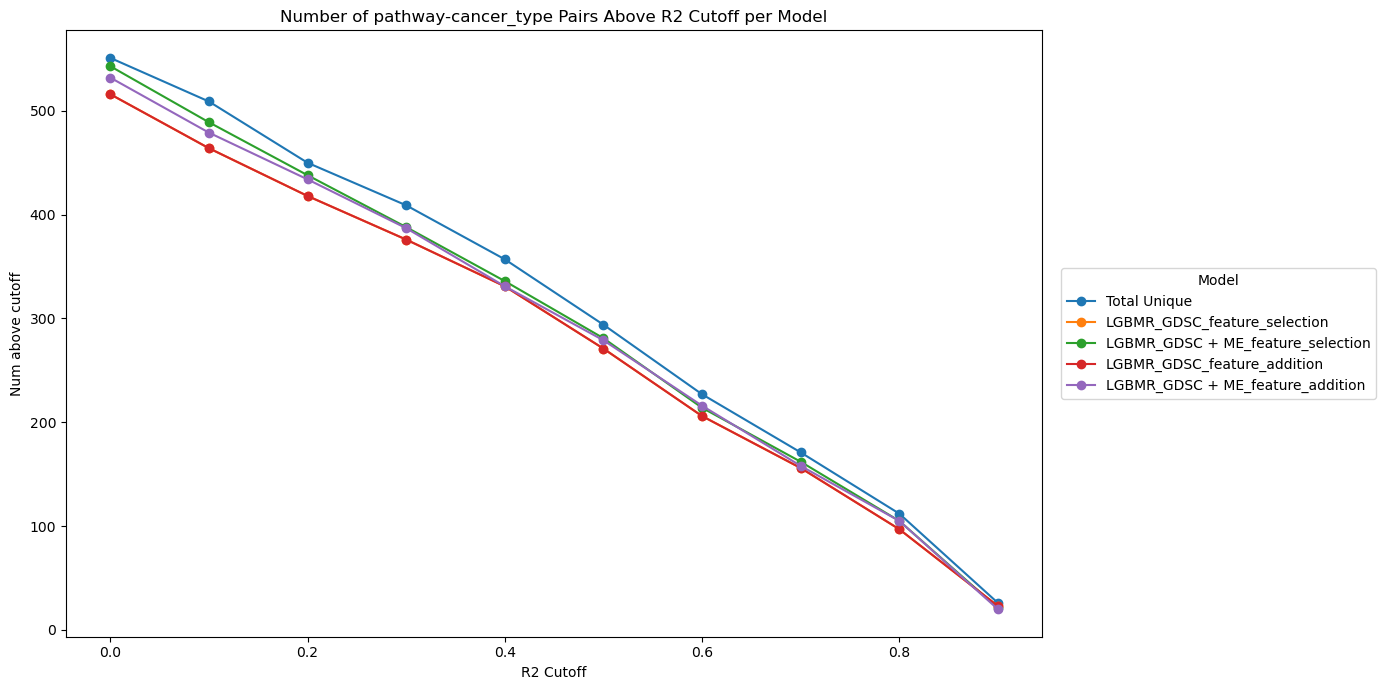

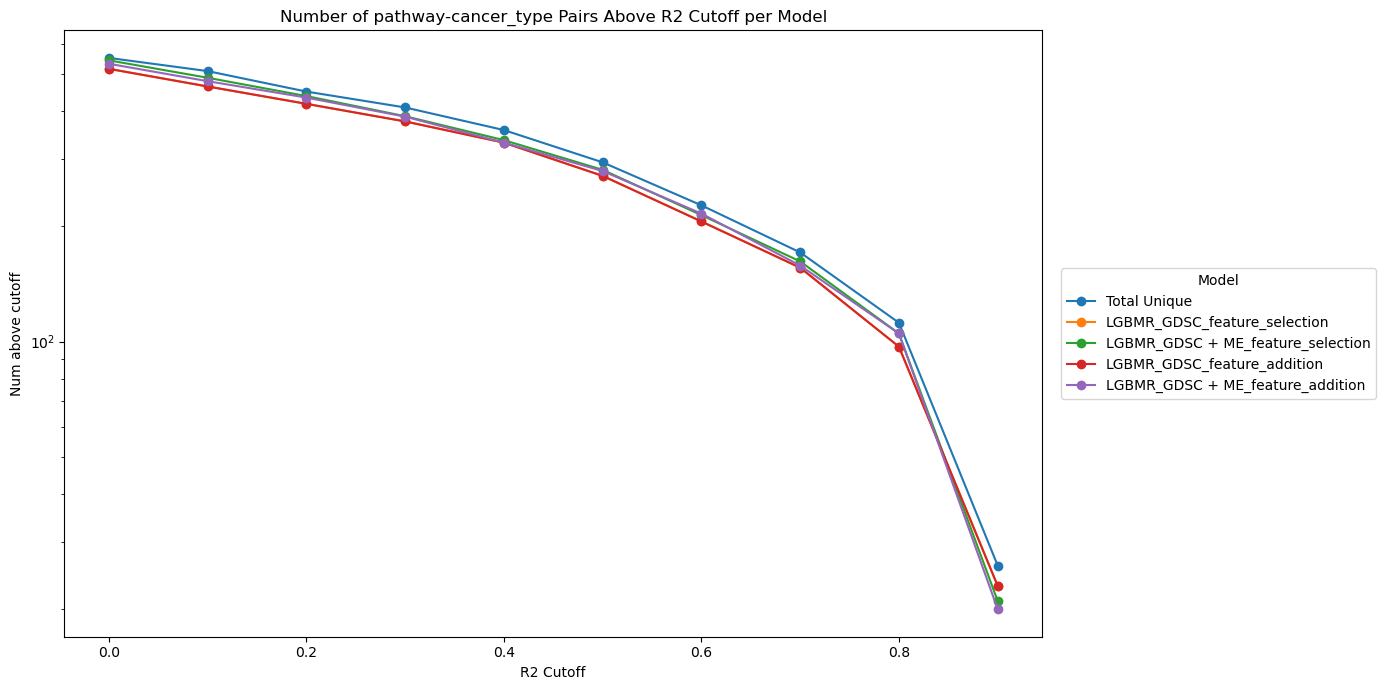

In [85]:
model_list_fa, _ = check_ypredict_exists_in_df(df_val, df_models_fa_eval['Model'].unique().tolist()) 
model_list_fa = [m for m in model_list_fa if m.startswith('LGBMR')]

model_list_fs, _ = check_ypredict_exists_in_df(df_val, df_models_fs_eval['Model'].unique().tolist()) 
model_list_fs = [m for m in model_list_fs if m.startswith('LGBMR')]
r2_cuttoff = R2_CUTTOFF

# Remove duplicate entries from model_list_fa and model_list_fs before combining
# model_list_fa = list(dict.fromkeys(model_list_fa))
# model_list_fs = list(dict.fromkeys(model_list_fs))
model_list = model_list_fs + ['LGBMR_GDSC_feature_addition', 'LGBMR_GDSC + ME_feature_addition'] #[m for m in model_list_fa if m not in model_list_fs]

print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")

df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, model_list, 
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
fig_1.savefig(RESULTS_DIR / f"Feature_Addition_vs_Selection_combo_r2_lineplot.png")
fig_1.show()


**Interpreation** For fature selection and hyper tuning
- select_k resulted in poor performance
- hypertuning found an overlapping but not identical set of drug-cancer combinations.

## 6.4 Evaluate models for feature selection

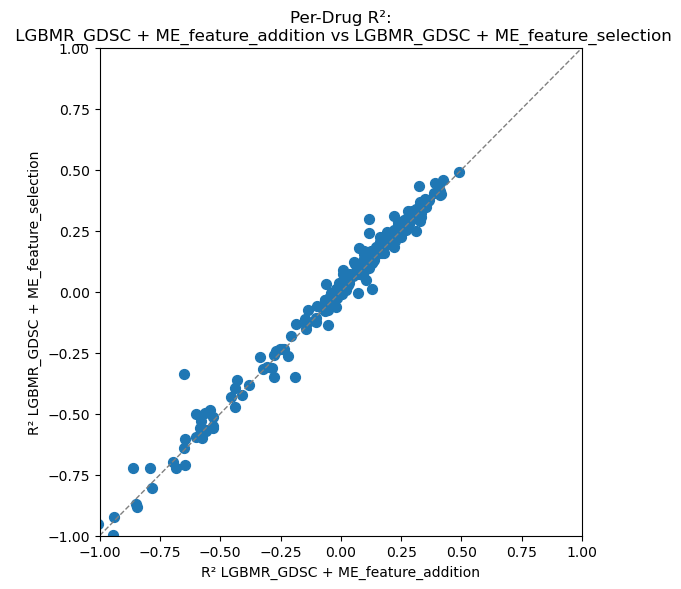

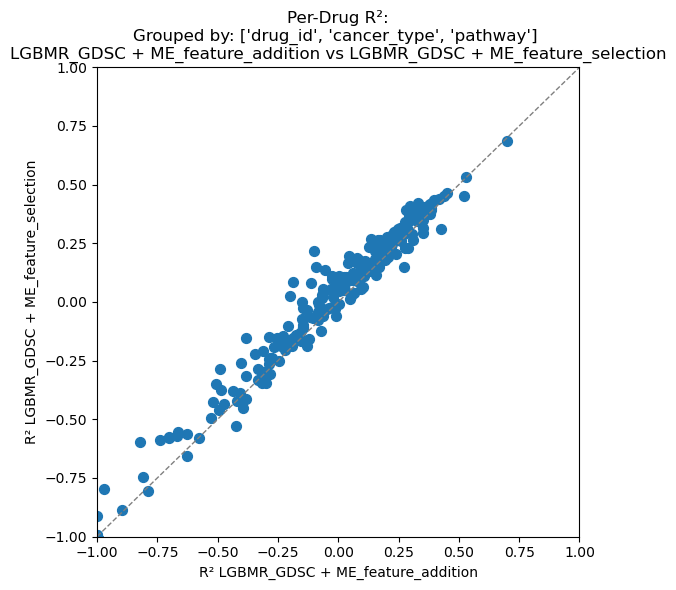

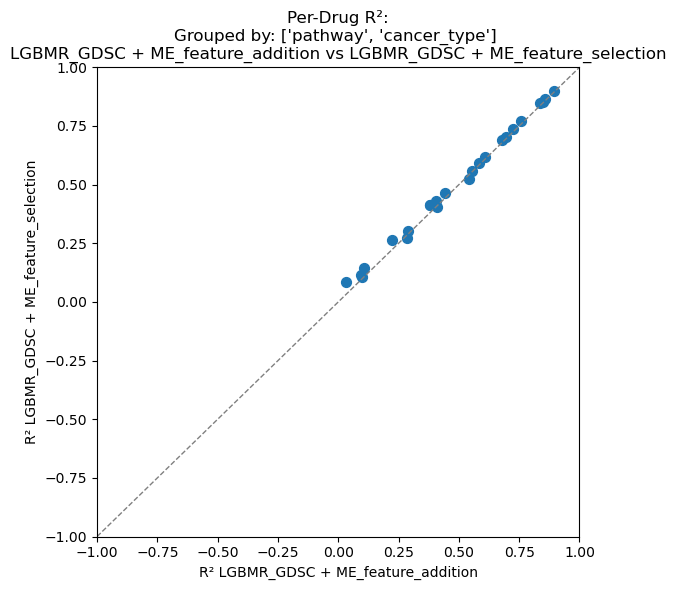

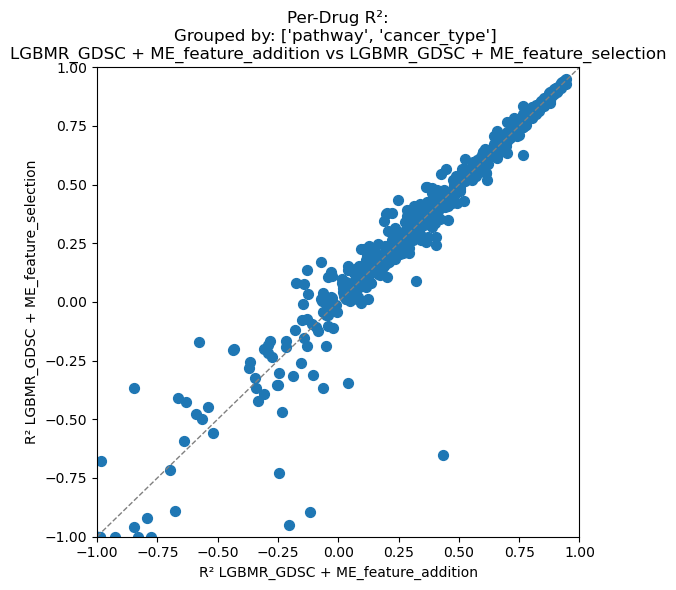

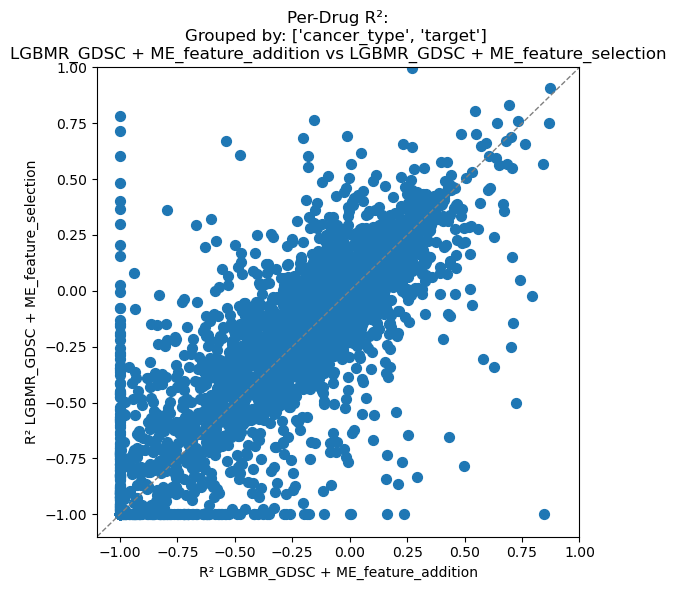

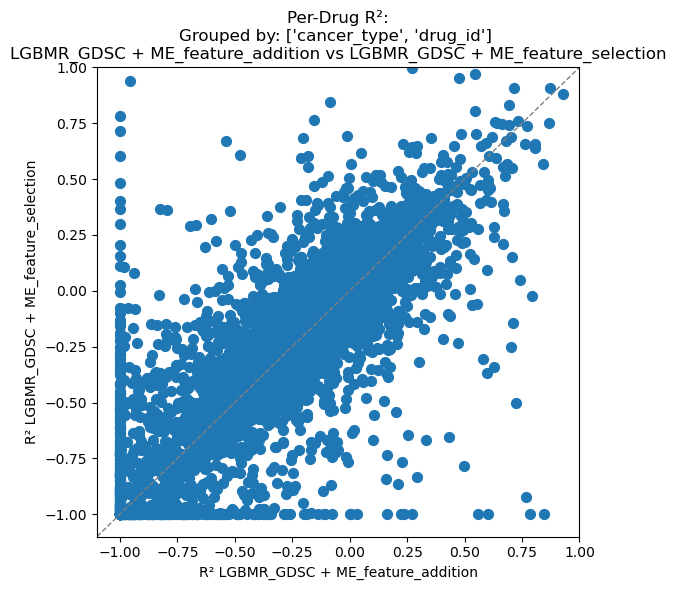

In [86]:

model_name_1  = 'LGBMR_GDSC + ME_feature_addition'
model_name_2 = 'LGBMR_GDSC + ME_feature_selection'

plot_r2_between_models(df_val, model_name_1, model_name_2, floor=-1)

plot_r2_between_models_pick_features(
    df_val[df_val['cancer_type']== 'UNCLASSIFIED'], 
    model_name_1, 
    model_name_2, 
    ['drug_id', 'cancer_type', 'pathway', ],
    floor=-1)

plot_r2_between_models_pick_features(
    df_val[df_val['cancer_type']== 'UNCLASSIFIED'],
    model_name_1, 
    model_name_2, 
    ['pathway', 'cancer_type'],
    floor=-1)

plot_r2_between_models_pick_features(
    df_val, 
    model_name_1, 
    model_name_2, 
    ['pathway', 'cancer_type'],
    floor=-1)

plot_r2_between_models_pick_features(
    df_val, 
    model_name_1, 
    model_name_2, 
    ['cancer_type', 'target'],
    floor=None)

plot_r2_between_models_pick_features(
    df_val, 
    model_name_1, 
    model_name_2, 
    ['cancer_type', 'drug_id'],
    floor=None)

In [87]:

feature_1 = 'cancer_type'
feature_2 = 'tissue_desc_1'
y_pred_1_col =  model_name_2

# Ensure 'ln_ic50' is available in df_val
if 'ln_ic50' not in df_val.columns:
    print('ln_ic50 missing')
    # # Try to get it from y_val_reg if available
    # if isinstance(y_val_reg, pd.DataFrame) and 'ln_ic50' in y_val_reg.columns:
    #     df_val = df_val.copy()
    #     df_val['ln_ic50'] = y_val_reg['ln_ic50']
    # else:
    #     raise KeyError("'ln_ic50' not found in df_val or y_val_reg.")
    # Group by both feature_1 and feature_2
    r2_base = (
        df_val
        .groupby([feature_1, feature_2])
        .apply(lambda g: r2_score(g['ln_ic50'], g[y_pred_1_col]))
        .rename('r2_base')
    )

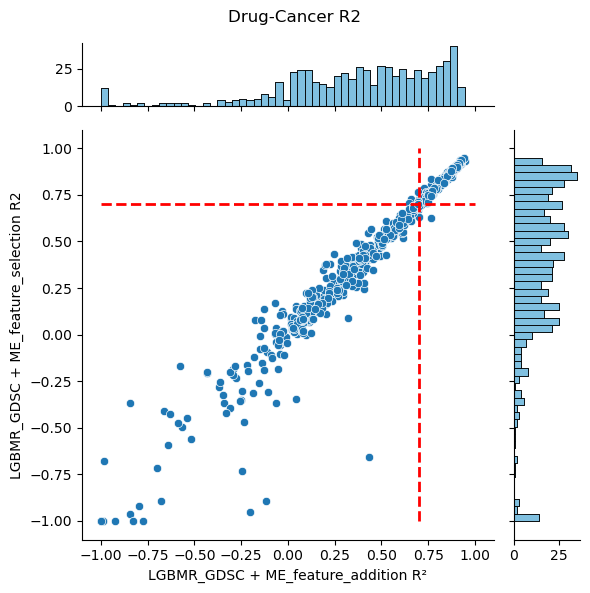

In [88]:
# plot top two models
cuttoff = 0.7
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, model_list, r2_cuttoff, 'ln_ic50', 
                                            feature_1='pathway',
                                            feature_2='cancer_type')
print("\n")

#_ = plot_scatter_drug_cancer_above(df_wide, model_name_1, model_name_2, cuttoff)
_ = plot_scatter_drug_cancer(df_wide, model_name_1, model_name_2, cuttoff)

### Rank all LGBMRegressor models

| Model Info                                 |   avg_rank |   RMSE |    R2 |   MAE |
|:-------------------------------------------|-----------:|-------:|------:|------:|
| LGBMRegressor: GDSC + ME feature selection |       1    |  1.513 | 0.693 | 1.149 |
| LGBMRegressor: GDSC + MVE feature addition |       2    |  1.516 | 0.692 | 1.152 |
| LGBMRegressor: GDSC + ME feature addition  |       3    |  1.524 | 0.689 | 1.159 |
| LGBMRegressor: GDSC feature addition       |       4.5  |  1.538 | 0.683 | 1.171 |
| LGBMRegressor: GDSC feature selection      |       4.5  |  1.538 | 0.683 | 1.171 |
| LGBMRegressor: GDSC + MV feature addition  |       6.33 |  1.555 | 0.676 | 1.188 |
| LGBMRegressor: GDSC + M feature addition   |       6.67 |  1.556 | 0.675 | 1.187 |


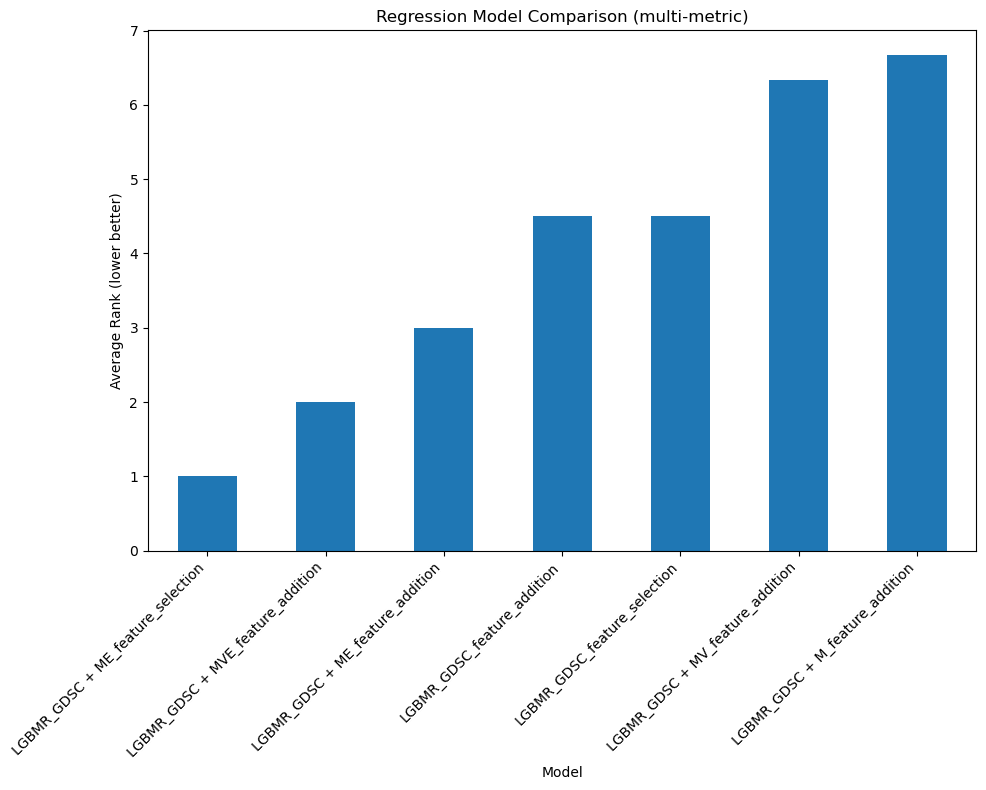

In [89]:
# get model rank
df_models_eval_all = pd.concat([df_models_fa_eval, df_models_fs_eval])
fig = get_regression_model_rank(df_models_eval_all, df_model_info)
fig.savefig(RESULTS_DIR / 'Feature Selection Rank.png', dpi=300, bbox_inches='tight')

**INTERPRETATION**

The feature selection LGBMRegressor model using GDSC + ME outperforms all other models based on average rank score.

Next step:
* Perform hypertuning of the LGBMRegressor model using GDSC + ME selected features (important_features_dict['LGBMRegressor']['GDSC + ME'])

## 6.5 LGBMRegressor Hypertune model with Selected Features


In [90]:
# Setup model results dataframe for feature addition experiment
df_models_ht_eval = evaluate_model()

env: PYTHONWARNINGS=ignore::FutureWarning:sklearn.utils.deprecation

===== Hyper‐tuning on feature set: GDSC + ME =====
Using columns: GDSC + ME
Processing model LGBMR_FS-GDSC + ME_hypertune from the oringal model: LGBMR_GDSC + ME_feature_selection
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Search time took 455.16 sec

Best params: {'model__colsample_bytree': np.float64(0.7927975767245621), 'model__learning_rate': 0.1, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__num_leaves': np.int64(54), 'model__reg_lambda': np.float64(0.837710105907328), 'model__subsample': np.float64(0.8802857225639664)}
CV RMSE: 1.480334635327769
Mean y_pred: 2.87
Mean y_pred: 2.87


Model evaluation for LGBMRegressor: LGBMR_FS-GDSC + ME_hypertune completed.

Predicution column: LGBMR_FS-GDSC + ME_hypertune_y_pred
 Oringal number of features in GDSC + ME 71 was           reduced by 0 to 71


Total number of unique drug pathway and cancer_type combinations: 622


Results 

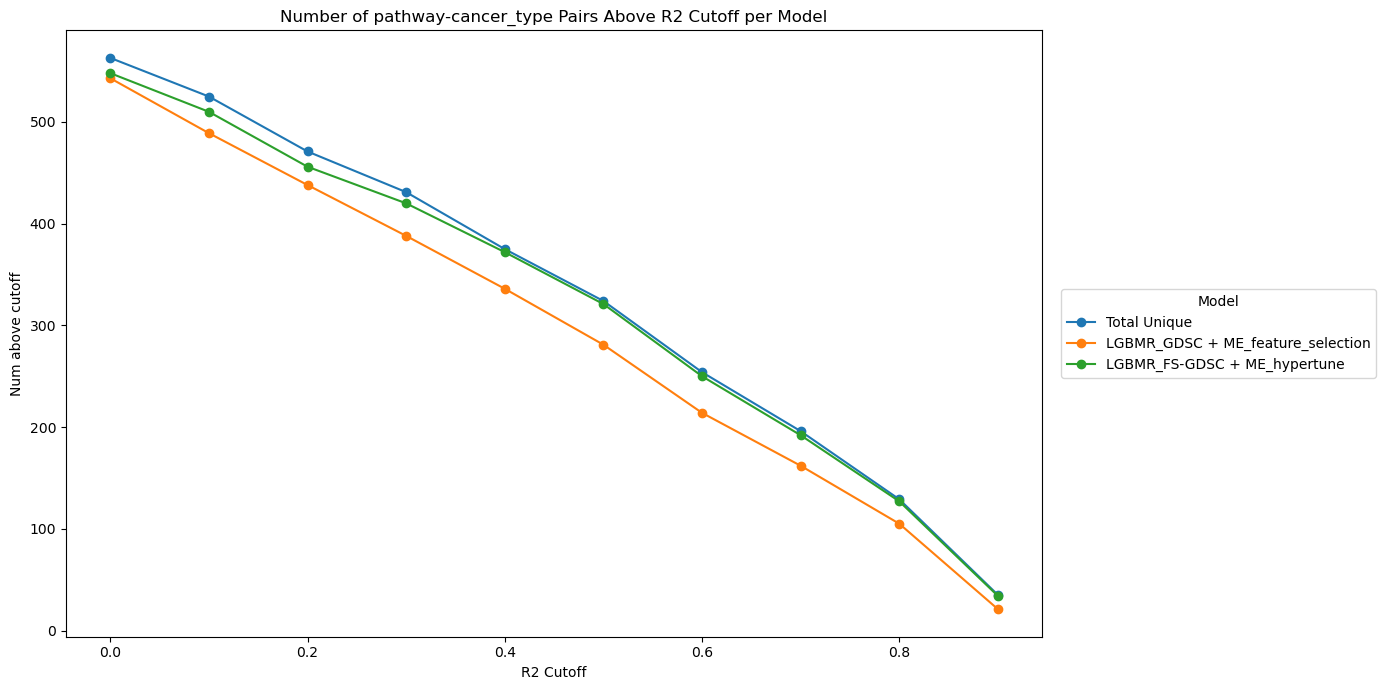

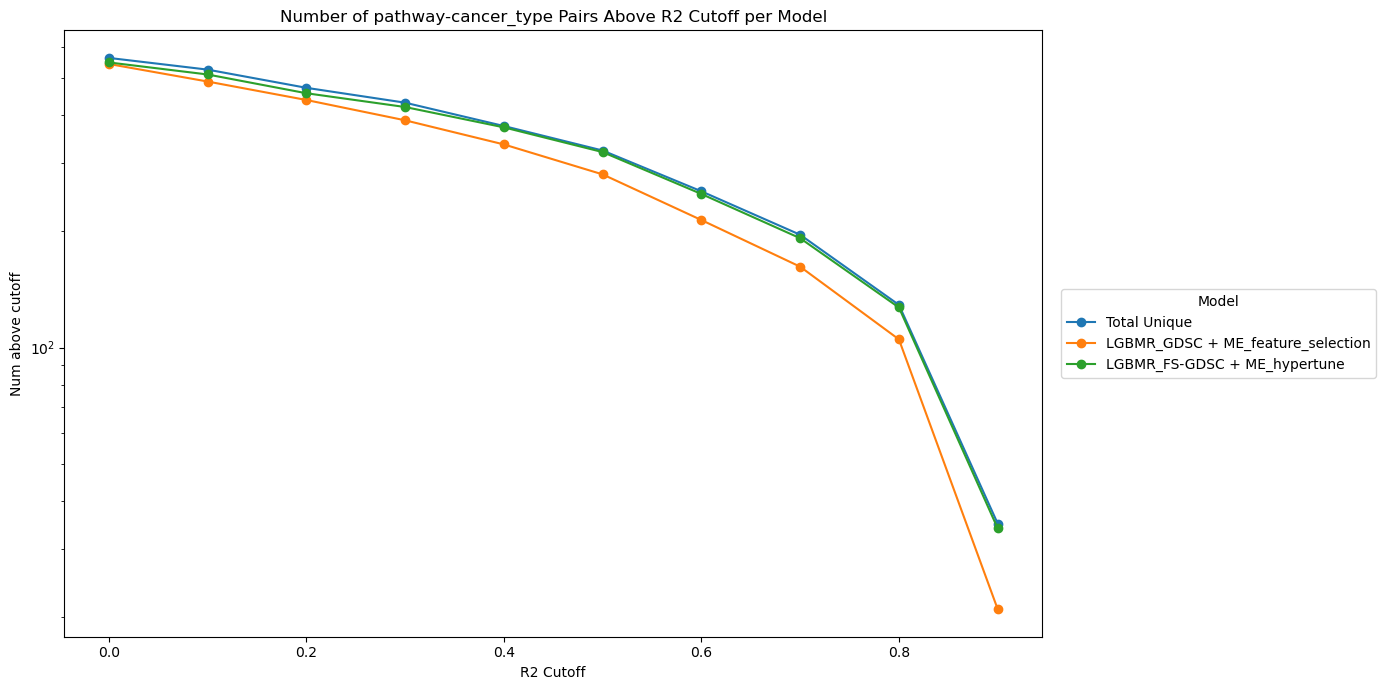

In [91]:
# import time
# import joblib
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from scipy.stats import randint, uniform
# import lightgbm as lgb

# Hide warnings
%env PYTHONWARNINGS=ignore::FutureWarning:sklearn.utils.deprecation

# feature sets
feature_sets = {
    #'GDSC':    cols_C,
    # 'GDSC + M': cols_CM,
    # 'GDSC + MV': cols_CMV,
    'GDSC + ME': cols_CME,
    # 'GDSC + MVE': cols_CMVE,
}

# Get base params for setting hypertuning
# base_params = pipe.named_steps['model'].get_params()
# pprint(base_params)

# Parameters from the LGBMRegressor: GDSC + ME feature selection model
    # {'boosting_type': 'gbdt',
    #  'class_weight': None,
    #  'colsample_bytree': 1.0,
    #  'importance_type': 'split',
    #  'learning_rate': 0.1,
    #  'max_depth': -1,
    #  'metric': 'rmse',
    #  'min_child_samples': 20,
    #  'min_child_weight': 0.001,
    #  'min_split_gain': 0.0,
    #  'n_estimators': 100,
    #  'n_jobs': -1,
    #  'num_leaves': 31,
    #  'objective': 'rmse',
    #  'random_state': 42,
    #  'reg_alpha': 0.0,
    #  'reg_lambda': 0.0,
    #  'subsample': 1.0,
    #  'subsample_for_bin': 200000,
    #  'subsample_freq': 0,
    #  'verbose': -1}

# Hyperparameter distributions for LightGBM
# use ones based on the original model
param_dist = {
    "model__n_estimators":      [100, 400, 1000], # randint(400, 1500),
    "model__learning_rate":     [0.1] + list(uniform(0.01, 0.9).rvs(size=4, random_state=42)),
    "model__num_leaves":        [31] + list(randint(16, 64).rvs(size=4, random_state=42)),
    "model__min_child_samples": [20] + list(randint(5, 50).rvs(size=4, random_state=42)),
    "model__subsample":         [1.0] + list(uniform(0.5, 0.4).rvs(size=4, random_state=42)),
    "model__colsample_bytree":  [1.0] + list(uniform(0.5, 0.4).rvs(size=4, random_state=42)),
    "model__reg_lambda":        uniform(0.0, 1.0),
}

# Use GroupKFold on COSMIC_ID so cell‐lines stay unseen across folds
gkf = GroupKFold(n_splits=3)

for name_cols_used_orig, _ in feature_sets.items():
    print(f"\n===== Hyper‐tuning on feature set: {name_cols_used_orig} =====")
    

    # get feature selection columns
    cols_use = important_features_dict['LGBMRegressor'][name_cols_used_orig]
    name_cols_use = f"FS-{name_cols_used_orig}"

    # Model information
    model_name_original = f"LGBMR_{name_cols_used_orig}_feature_selection"
    model_name = f"LGBMR_{name_cols_use}_hypertune"
    model_type = 'LGBMRegressor'
    task_type  = 'regression'
    model_description = f"LGBMRegressor: {name_cols_use} hypertune"
    # model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT


    # Specify columns to use for preprocessing and modeling
    # Drop columns cols_C not in X_train
    cols_use = [col for col in X_train.columns if col in cols_use]  # ensure core features are included

    # Subset train & val
    X_train_use = X_train[cols_use]
    X_val_use  = X_val[cols_use]
    

    # -- Train and evaluate the model --
    # track model info
    df_model_info = pd.concat([
        df_model_info, 
        pd.DataFrame([{
        'model_name'   : model_name,
        'model_type'   : model_type,
        'task_type'    : task_type,
        'feature_set'  : name_cols_use,
        'target_column': TARGET_COLUMN_REG,
        'train_data_X' : f"X_train[{name_cols_use}]_permute",
        'train_data_y' : train_data_y_name,
        'val_data_X'   : f"X_val[{name_cols_use}]_permute",
        'val_data_y'   : val_data_y_name,
        'train_sample_weights': 'nan', # no sample weights for dummy regressor
        'val_sample_weights'  : 'nan',
        'model_description': model_description
        }])
    ], ignore_index=True)


    print(f"Using columns: {name_cols_used_orig}")
    print(f"Processing model {model_name} from the oringal model: {model_name_original}")
    

    # get the full pipeline used previously
    pipe = clone(models_dict[model_name_original])

    # Build pipeline
    pre = get_preprocessor(X_train, cols_use)
    pipe = Pipeline([
        ('pre',   pre),
        ('model',  pipe.named_steps['model']) 
        # ('model', lgb.LGBMRegressor(objective="rmse",
        #                             n_jobs=-1,
        #                             random_state=RANDOM_SEED)),
    ])

    # Randomized search with sample‐weights
    search = RandomizedSearchCV(
        estimator          = pipe,
        param_distributions= param_dist,
        n_iter             = 40,
        scoring            = "neg_root_mean_squared_error",
        cv                 = gkf.split(X_train_use, y_train_reg[TARGET_COLUMN_REG],
                                      groups=X_train["COSMIC_ID"]),
        refit              = True,
        n_jobs             = -1,
        verbose            = 1,
        random_state       = RANDOM_SEED,
    )
    
    start = time.time()
    search.fit(X_train_use, y_train_reg[TARGET_COLUMN_REG])
    search_time = time.time() - start
    print(f"\nSearch time took {search_time:.2f} sec\n")
    
    # Get best_estimator
    best_pipe = search.best_estimator_
    print("Best params:", search.best_params_)
    print("CV RMSE:", -search.best_score_)

    # store model for later
    models_dict[model_name] = best_pipe

    # Save amd Evalaute the model
    model_to_eval = best_pipe # EDIT FOR EACH PIPELINE
    train_time = search.refit_time_

    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_train_use,)).round(2)}")
    print(f"Mean y_pred: {np.mean(model_to_eval.predict(X_val_use,)).round(2)}")
    ##print("Save model")
    #joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

    # Evaluate on train & val, logging into df_models_eval
    for X_data, y_data, w_data, split in [
        (X_train_use, y_train_reg[TARGET_COLUMN_REG], w_train, "Train"),
        (X_val_use,   y_val_reg[TARGET_COLUMN_REG],   w_val,   "Test"),
        ]:

        # add predictions
        pred_col = f"{model_name}_y_pred"
        if split == "Train":
            df_train[pred_col] = model_to_eval.predict(X_data)
            y_pred = df_train[pred_col]
        else:
            df_val[pred_col]   = model_to_eval.predict(X_data)
            y_pred = df_val[pred_col]

        # regression metrics
        df_models_ht_eval = evaluate_model(
            model_to_eval, model_name, split,
            X_data, y_data,
            df_models_eval = df_models_ht_eval,
            train_time     = train_time,       # or search refit time if tracked
            pos_label      = None,             # regression
            round_to       = ROUND_TO
        )
        
        # binary metrics (if you have y_true_cat & threshold_per_drug)
        df_models_ht_eval, df_tmp = add_binary_metrics(
            df_models_results  = df_models_ht_eval,
            model_name         = model_name,
            split_name         = split,
            df                 = df_val if split == "Test" else df_train,
            y_true             = y_val_cat[TARGET_COLUMN_CAT] if split == "Test" else y_train_cat[TARGET_COLUMN_CAT],
            y_pred             = y_pred,
            threshold_per_drug = threshhold_per_drug,
            pos_label          = 1,
            round_to           = ROUND_TO
        )

    print("\n")
    print(f"Model evaluation for {model_type}: {model_name} completed.")

    # print_df_markdown(df_models_eval)
    print(f"\nPredicution column: {pred_col}")

    print(f" Oringal number of features in {name_cols_used} {len(cols_use)} was \
          reduced by {len(cols_use)- len(important_features)} to {len(important_features)}")

    print("\n")
    # Get top drug-cancer R2 per model
    r2_cuttoff = R2_CUTTOFF
    print(f"Total number of unique drug pathway and cancer_type combinations: {num_pathway_cancer_combos}")
    #print("\n")
    #print(f"Number of drug pathway-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
    #df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, [model_name], r2_cuttoff, 'ln_ic50')
    df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, [model_name_original, model_name], r2_cuttoff, 'ln_ic50', 
                                            feature_1='pathway',
                                            feature_2='cancer_type')
    print("\n")
    print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}:")
    print_df_markdown(df_drugcancer_hits)

    print("\n")
  
    df_dc_scores, fig_1, _ = plot_combos_cuffoff_scores(df_val, [model_name_original, model_name],     
                                          0, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type',
                                          log_plot='both')
    
    fig_1.savefig(RESULTS_DIR / f"{model_type}_Hypertune_{name_cols_used}_combo_r2_lineplot.png")
    fig_1.show()

| Model Info                                 |   avg_rank |   RMSE |    R2 |   MAE |
|:-------------------------------------------|-----------:|-------:|------:|------:|
| LGBMRegressor: FS-GDSC + ME hypertune      |          1 |  1.447 | 0.719 | 1.083 |
| LGBMRegressor: GDSC + ME feature selection |          2 |  1.513 | 0.693 | 1.149 |
| LGBMRegressor: GDSC feature selection      |          3 |  1.538 | 0.683 | 1.171 |


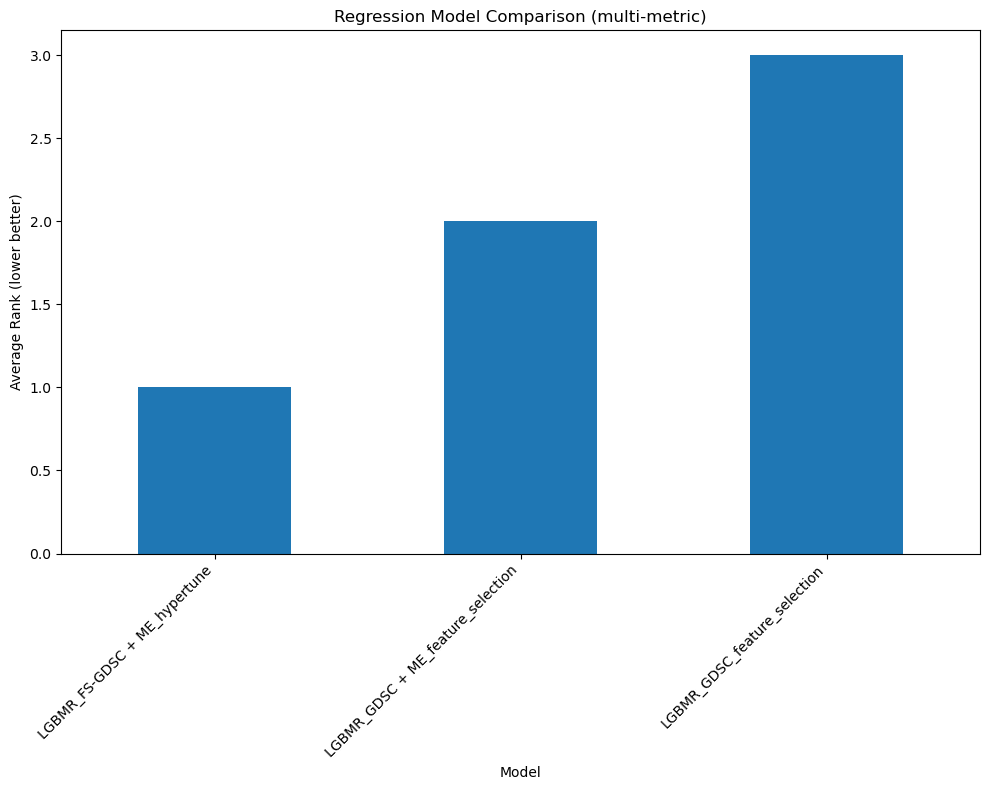

In [92]:

df_models_eval_all = pd.concat([df_models_fs_eval, df_models_ht_eval])
fig = get_regression_model_rank(df_models_eval_all, df_model_info)
fig.savefig(RESULTS_DIR / 'Feature Selection Rank.png', dpi=300, bbox_inches='tight')

**Model Metrics**

In [93]:
print("Table of Model Performance:")
df_tmp = pd.concat([
    df_models_fs_eval[df_models_fs_eval['Model'] == model_name_original],
    df_models_ht_eval[df_models_ht_eval['Model'] == model_name]
])
       
print_model_metrics(df_tmp.drop(columns=['Pearson', 'Spearman']), df_model_info, 'Test')
print("\n")

Table of Model Performance:
| Model Info                                 | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |   RMSE |   MAE |    R2 |
|:-------------------------------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|-------:|------:|------:|
| LGBMRegressor: GDSC + ME feature selection | Test    | regression   |  0.137 |      0.731 |       0.464 |    0.361 |   0.406 |      nan |  1.513 | 1.149 | 0.693 |
| LGBMRegressor: FS-GDSC + ME hypertune      | Test    | regression   |  0.256 |      0.75  |       0.513 |    0.415 |   0.459 |      nan |  1.447 | 1.083 | 0.719 |




# BREAK

new pathway-cancer

## Find the model with the highest R2 for the top drug x cancer combos

- How many drug-cancer combos are with R2 above 0.5?
- How many drug-cancer combos are with R2 above 0.75?
- How many drug-cancer combos are with R2 above 0.9?
- What drug-cancer combos are in common

In [94]:
df_models_eval['Model'][df_models_eval['Split'] == 'Test'].to_list()

['LGBMRegressor: GDSC Baseline',
 'LGBMRegressor: GDSC + Weights',
 'DecisionTreeClassifier GDSC',
 'XGBoostRegresspr GDSC',
 'MLPRegressor GDSC',
 'ElasticNet GDSC']

In [95]:
# Get results by drug-cancer
skip_models = ['dectree_base_pipe', 'xgb_reg_base_pipe', 'en_base_pipe']
model_list = (
    list(df_models_eval['Model'].unique()) + 
    list(df_models_fa_eval['Model'].unique()) +
    list(df_models_ht_eval['Model'].unique())
)

model_list = [m for m in model_list if m not in skip_models]

df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_val, model_list, r2_cuttoff, 'ln_ic50', 
                                          feature_1='pathway',
                                          feature_2='cancer_type')
print("\n")
print(f"Results for pathway-cancer combos above cuttoff of {r2_cuttoff}")
print_df_markdown(df_drugcancer_hits)

# # Get top drug-cancer R2 per model
# #model_list = [m for m in model_list if m not in skip_models]
# print(f"Number of drug-cancer combos with R2 above the Cuttoff of: {r2_cuttoff}")
# df_wide,  df_drugcancer_hits = get_num_drug_caner_above_cuttoff(df_val, model_list, r2_cuttoff, 'ln_ic50')
# print_df_markdown(df_drugcancer_hits)



Results for pathway-cancer combos above cuttoff of 0.5
| Model                             |   Num above cuttoff |    Max |   Mean |
|:----------------------------------|--------------------:|-------:|-------:|
| LGBMR_FS-GDSC + ME_hypertune      |                 321 |   0.96 |   0.74 |
| MLPRegressor GDSC                 |                 289 |   0.96 |   0.73 |
| LGBMR_GDSC + ME_feature_addition  |                 279 |   0.95 |   0.73 |
| LGBMR_GDSC + MVE_feature_addition |                 277 |   0.94 |   0.73 |
| LGBMR_GDSC_feature_addition       |                 271 |   0.95 |   0.73 |
| LGBMRegressor: GDSC Baseline      |                 271 |   0.95 |   0.73 |
| LGBMR_GDSC + MV_feature_addition  |                 263 |   0.95 |   0.72 |
| LGBMR_GDSC + M_feature_addition   |                 260 |   0.94 |   0.73 |
| LGBMRegressor: GDSC + Weights     |                 249 |   0.96 |   0.72 |
| DecisionTreeClassifier GDSC       |                   0 | nan    | nan    |
| Elast

In [96]:
model_list

['LGBMRegressor: GDSC Baseline',
 'LGBMRegressor: GDSC + Weights',
 'DecisionTreeClassifier GDSC',
 'XGBoostRegresspr GDSC',
 'MLPRegressor GDSC',
 'ElasticNet GDSC',
 'LGBMR_GDSC_feature_addition',
 'LGBMR_GDSC + M_feature_addition',
 'LGBMR_GDSC + ME_feature_addition',
 'LGBMR_GDSC + MV_feature_addition',
 'LGBMR_GDSC + MVE_feature_addition',
 'LGBMR_FS-GDSC + ME_hypertune']

In [97]:
df_drugcancer_hits

Model  Num above cuttoff   Max  Mean
2        LGBMR_FS-GDSC + ME_hypertune                321  0.96  0.74
10                  MLPRegressor GDSC                289  0.96  0.73
3    LGBMR_GDSC + ME_feature_addition                279  0.95  0.73
4   LGBMR_GDSC + MVE_feature_addition                277  0.94  0.73
7         LGBMR_GDSC_feature_addition                271  0.95  0.73
9        LGBMRegressor: GDSC Baseline                271  0.95  0.73
5    LGBMR_GDSC + MV_feature_addition                263  0.95  0.72
6     LGBMR_GDSC + M_feature_addition                260  0.94  0.73
8       LGBMRegressor: GDSC + Weights                249  0.96  0.72
0         DecisionTreeClassifier GDSC                  0   NaN   NaN
1                     ElasticNet GDSC                  0   NaN   NaN
11              XGBoostRegresspr GDSC                  0   NaN   NaN

# 6.5 Build Ensembel Model using the best model for each drug pathway-cancer combo 
For each drug combination get the best model from the training set
Using training data to get the best combinations as it would be leakage to use the validataion set.

In [98]:
# make a dataframe with the highest R2 for each drug-cancer combo

cuttoff = 0.5
model_list = (
    list(df_models_eval['Model'].unique()) + 
    list(df_models_fa_eval['Model'].unique())+ 
    list(df_models_ht_eval['Model'].unique())
)

# get best model from 
df_wide,  df_drugcancer_hits = get_num_combos_above_cuttoff(df_train, model_list, cuttoff, TARGET_COLUMN_REG, 'pathway', 'cancer_type', sorted=False)

top_model = []
for idx, row in df_wide.iterrows():
    # Drop columns that are not model R2 columns
    r2_values = row.drop(labels=['pathway', 'cancer_type'])
    # Find the model (column) with the highest R2 for this (drug_id, cancer_type)
    best_model = r2_values.idxmax()
    best_r2 = r2_values.max()
    top_model.append({
        'pathway': row['pathway'],
        'cancer_type': row['cancer_type'],
        'model_name': best_model,
        'R2': round(best_r2,3)
    })
df_top_combo_train = pd.DataFrame(top_model)
#print(df_top_combo_train.head())
cuttoff = 0.5
# Get all occurances in df_top_combo_train above a cutoff
print(f"Drug pathway-cancer above {cuttoff} = {len(df_top_combo_train[df_top_combo_train['R2'] > cuttoff])}")
print_df_markdown(df_top_combo_train[df_top_combo_train['R2'] > cuttoff])

Drug pathway-cancer above 0.5 = 508
| pathway                           | cancer_type   | model_name                   |    R2 |
|:----------------------------------|:--------------|:-----------------------------|------:|
| ABL signaling                     | CESC          | LGBMR_FS-GDSC + ME_hypertune | 0.508 |
| ABL signaling                     | COREAD        | LGBMR_FS-GDSC + ME_hypertune | 0.776 |
| ABL signaling                     | ESCA          | LGBMR_FS-GDSC + ME_hypertune | 0.628 |
| ABL signaling                     | GBM           | LGBMR_FS-GDSC + ME_hypertune | 0.729 |
| ABL signaling                     | HNSC          | LGBMR_FS-GDSC + ME_hypertune | 0.676 |
| ABL signaling                     | KIRC          | LGBMR_FS-GDSC + ME_hypertune | 0.771 |
| ABL signaling                     | LAML          | LGBMR_FS-GDSC + ME_hypertune | 0.551 |
| ABL signaling                     | LGG           | LGBMR_FS-GDSC + ME_hypertune | 0.738 |
| ABL signaling                   

In [99]:
# Get all occurances in df_top_drug_cancer above a cutoff
cuttoff = 0.9
print(f"Drug pathway-cancer above {cuttoff} = {len(df_top_combo_train[df_top_combo_train['R2'] > cuttoff])}")
print("\n")
print_df_markdown(df_top_combo_train[df_top_combo_train['R2'] > cuttoff])

Drug pathway-cancer above 0.9 = 136


| pathway                           | cancer_type   | model_name                   |    R2 |
|:----------------------------------|:--------------|:-----------------------------|------:|
| Apoptosis regulation              | LGG           | LGBMR_FS-GDSC + ME_hypertune | 0.912 |
| Cell cycle                        | ALL           | LGBMR_FS-GDSC + ME_hypertune | 0.901 |
| Cell cycle                        | BLCA          | LGBMR_FS-GDSC + ME_hypertune | 0.91  |
| Cell cycle                        | CESC          | LGBMR_FS-GDSC + ME_hypertune | 0.915 |
| Cell cycle                        | COREAD        | LGBMR_FS-GDSC + ME_hypertune | 0.911 |
| Cell cycle                        | DLBC          | LGBMR_FS-GDSC + ME_hypertune | 0.933 |
| Cell cycle                        | ESCA          | LGBMR_FS-GDSC + ME_hypertune | 0.904 |
| Cell cycle                        | GBM           | LGBMR_FS-GDSC + ME_hypertune | 0.922 |
| Cell cycle                    

**INTERPRETATION**

- The multitask model that utilizes the best model per a drug pathway - cancer groups has 136 groups with R2 > 0.9. 
- This is a 101 more groups than that of the LGBMR_FS-GDSC + ME_hypertune model with 34 groups with R2 > 0.9 
- This multitask model achieves 21.8% of the 622 total groups at R2 > 0.9. 

### Scatter comparison of two models illustrating delta in best performing drug target-pathway × cancer type group

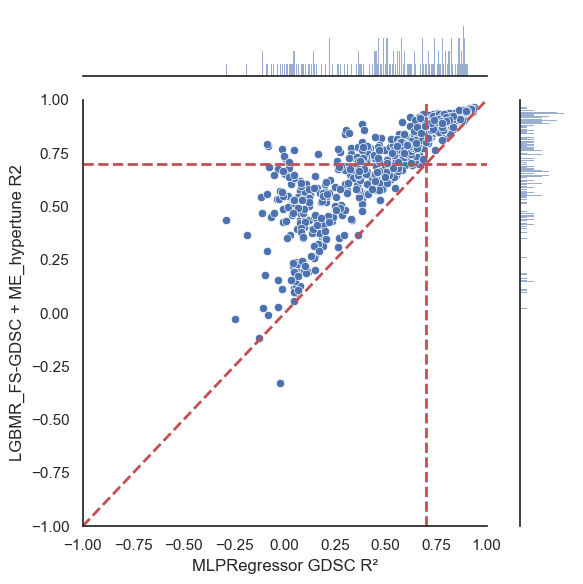

In [100]:
model_name_1 = 'MLPRegressor GDSC'
model_name_2 = 'LGBMR_FS-GDSC + ME_hypertune' #'xgb_reg_base_pipe'
cuttoff = 0.7
sns.set(style="white")  # clean background
df_plot = df_wide #(df_wide[(df_wide[model_name_1] > -10) & (df_wide[model_name_2] > -10)])
fig = g = sns.jointplot(
    data=df_plot,
    x=model_name_1,
    y=model_name_2,
    kind="scatter",       # central scatter
    height=6,             # size of the figure
    marginal_kws=dict(bins=1000, fill=True, alpha=0.6)  
)

g.set_axis_labels(f"{model_name_1} R²", f"{model_name_2} R2")
plt.plot([cuttoff, cuttoff], [-1, 1], 'r--', lw=2) # add cuttoff line
plt.plot([-1, 1], [cuttoff, cuttoff], 'r--', lw=2) # add cuttoff line
plt.plot([-1, 1], [-1, 1], 'r--', lw=2) # add cuttoff line
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
fig.savefig(RESULTS_DIR / f"Model_comparison_R2_{model_name_1} vs {model_name_2}")
plt.show()

# 7.0 Explainability

## Feature importance from LGBMRegressor

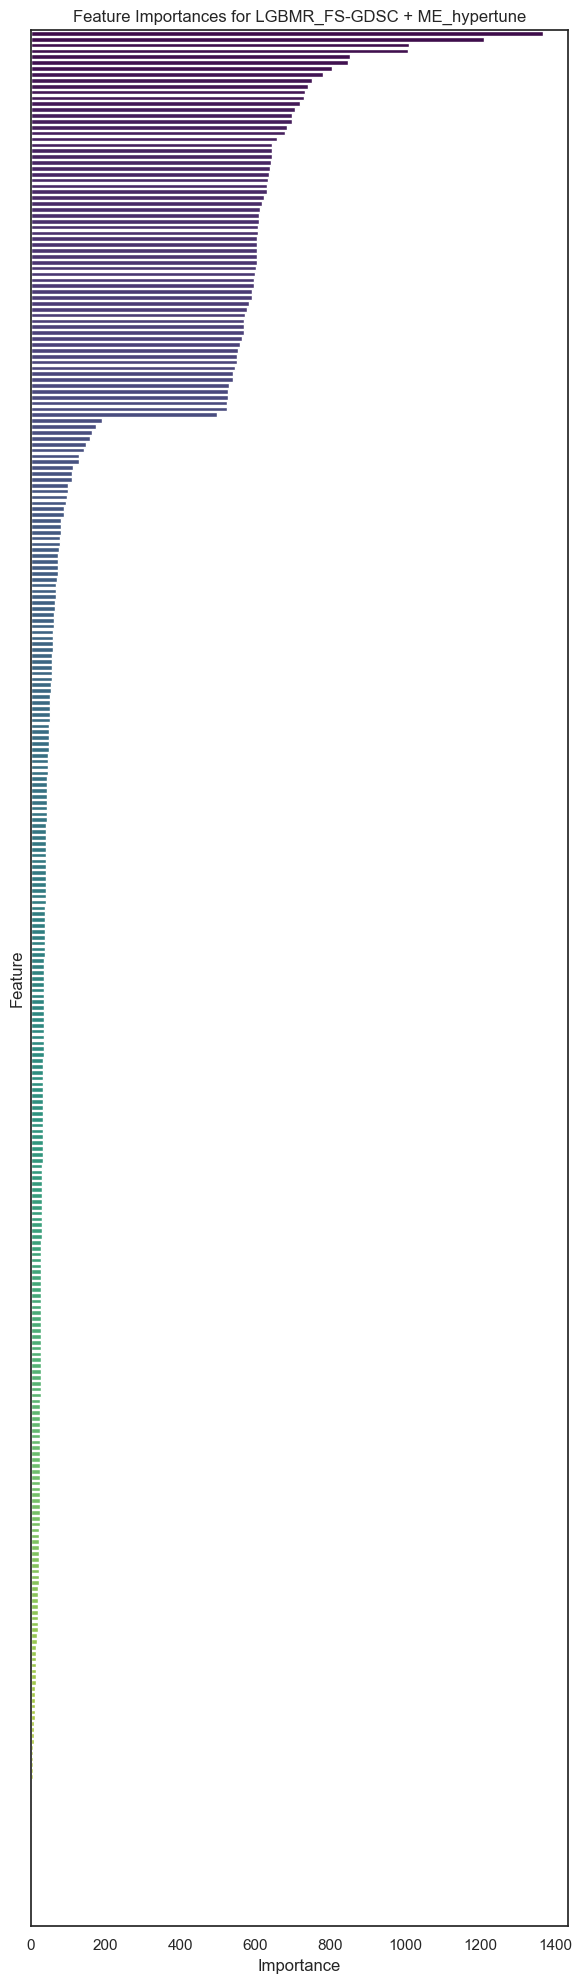

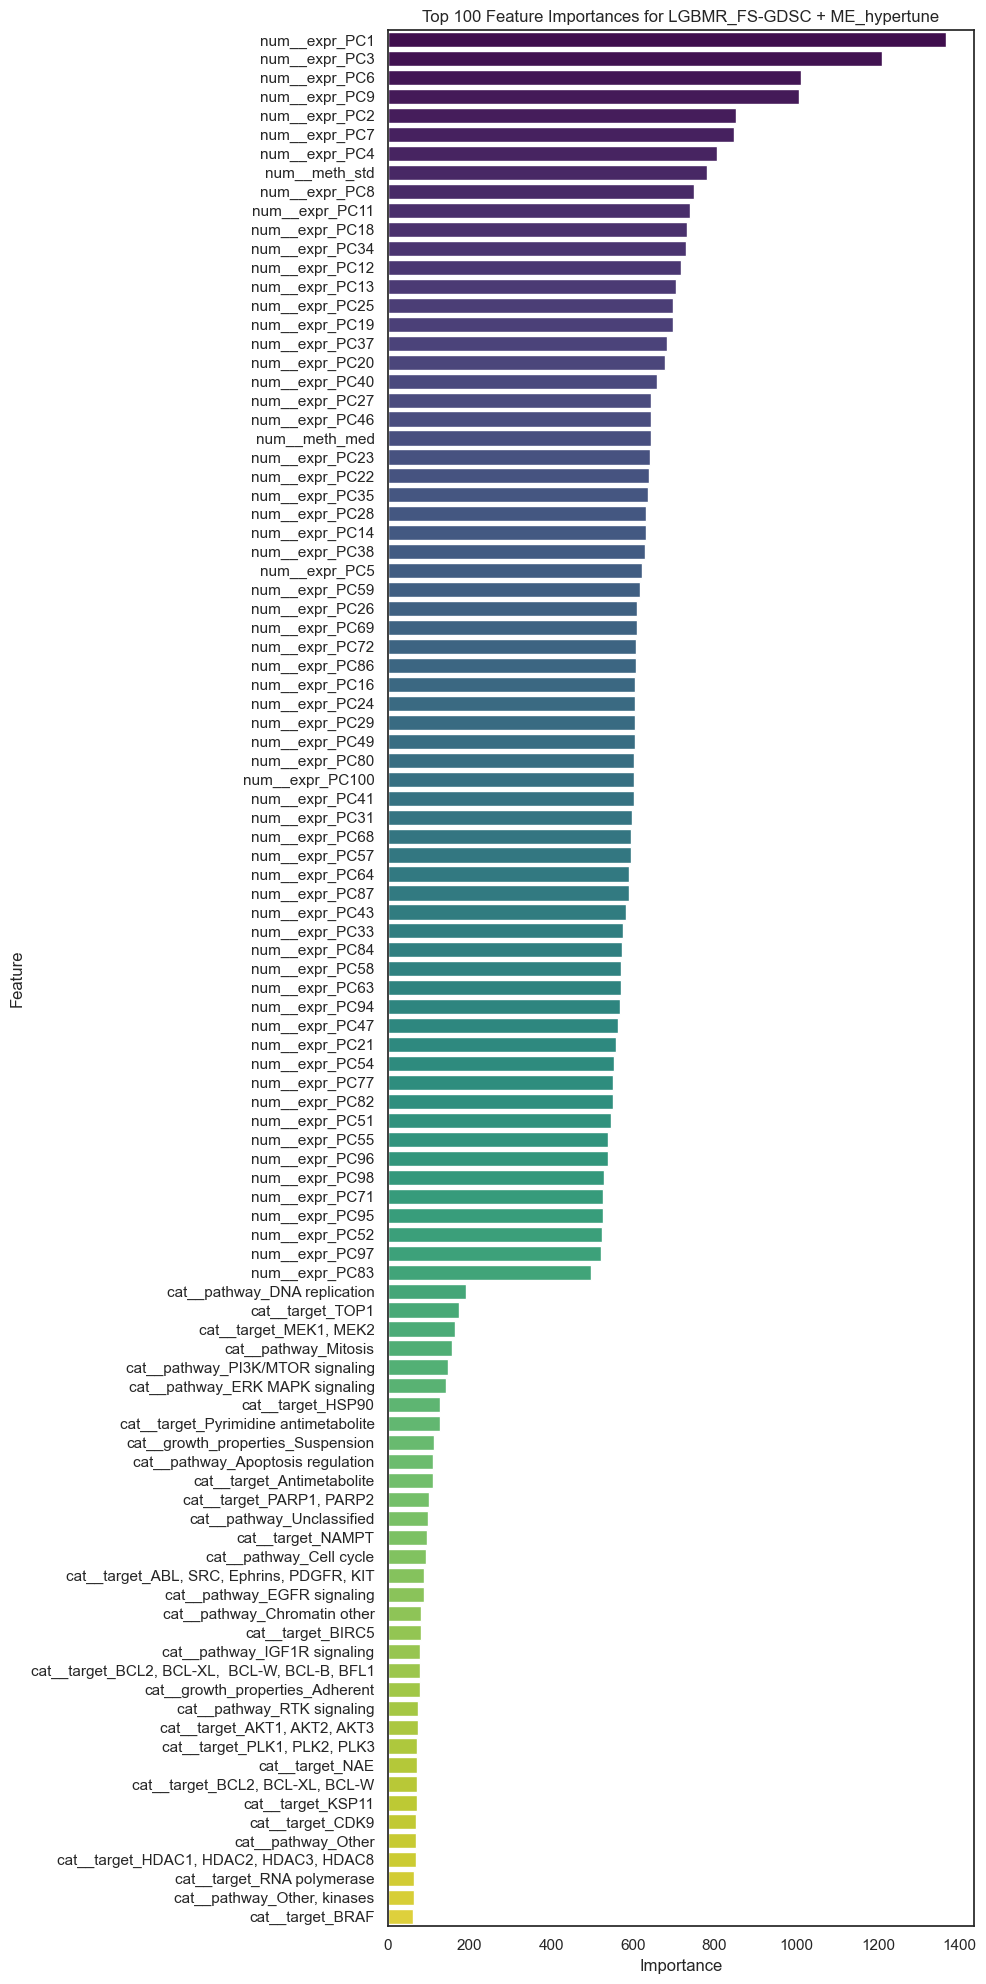

In [101]:
# Plot feature importance for lgb_base_pipe model
model_name = 'LGBMR_FS-GDSC + ME_hypertune'
model_use = models_dict[model_name]
preprocessor = model_use.named_steps['pre']


# get feature names after fitting the preprocessor on X_train_use:
feat_names = model_use.named_steps['pre'].get_feature_names_out()

# Get feature importances from the model
importances = model_use.named_steps['model'].feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
}).sort_values('importance', ascending=False)


# Plot all features importanc  without labels
plt.figure(figsize=(6, 20))
sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
plt.title(f"Feature Importances for {model_name}")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks([])
plt.tight_layout()
plt.show()

# plot top nfeat features with labels
nfeat = 100
plt.figure(figsize=(10, 20))
sns.barplot(data=feat_imp_df.head(nfeat), x='importance', y='feature', palette='viridis')
plt.title(f"Top {nfeat} Feature Importances for {model_name}")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

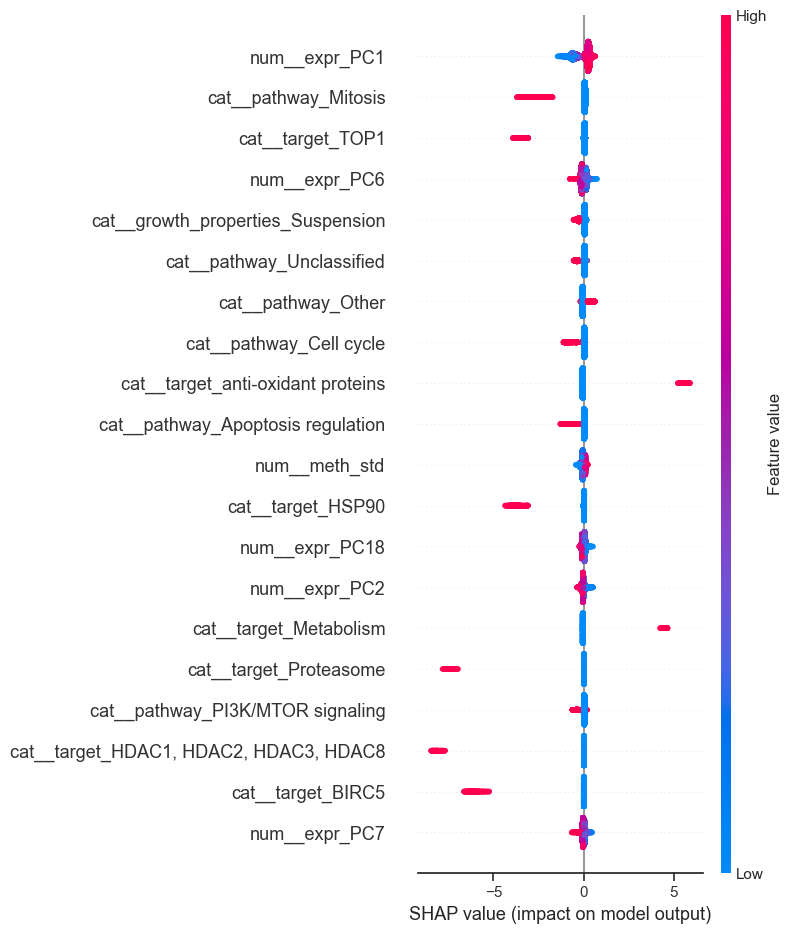

In [102]:
import scipy
feature_sets = {
    #'GDSC':    cols_C,
    # 'GDSC + M': cols_CM,
    # 'GDSC + MV': cols_CMV,
    'GDSC + ME': cols_CME,
    # 'GDSC + MVE': cols_CMVE,
}
## ENTER MODEL NAME
model_name = 'LGBMR_FS-GDSC + ME_hypertune'

# get the pipeline and features from best model
best_pipe = models_dict[model_name]

# get cols_use from feature selection used for hypertuning

cols_use = important_features_dict['LGBMRegressor']['GDSC + ME']

# setup data
X_train_use = X_train[cols_use]
X_val_use  = X_val[cols_use]

# Get transformed feature names from the pipeline
feature_names = best_pipe.named_steps['pre'].get_feature_names_out()

# get the model
best_model = best_pipe.named_steps['model']

# Get the input data after preprocessing
X_val_transformed = best_pipe.named_steps['pre'].transform(X_val[cols_use])

# detect if sparse and convert
if scipy.sparse.issparse(X_val_transformed):
    X_val_transformed = X_val_transformed.toarray()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_transformed)

# generate plots
shap.initjs()

#shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names, plot_type='bar')
fig, ax = plt.subplots(figsize=(10,6))
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names)
ax.set_title(f"SHAP for {model_name}")
fig.tight_layout()
fig.savefig(RESULTS_DIR / "shap.png", dpi=300, bbox_inches="tight")
plt.show()

#### Explore individual instances of SHAP analysis

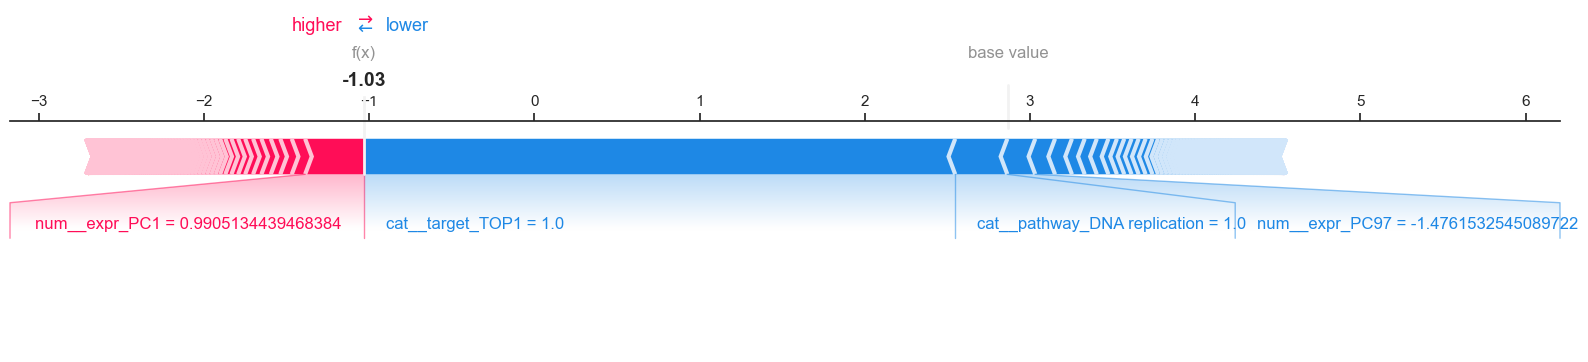

In [103]:
i = 1  # index of the instance to explain
#shap.force_plot(explainer.expected_value, shap_values[i], X_val_transformed[i], feature_names=feature_names)

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_val_transformed[i],
    feature_names=feature_names,
    matplotlib=True  # Force Matplotlib rendering with white background
)

**INTERPRETATION**

SHAP analysis of the hypertuned GDSC + Methylation and Expression (CME) model ranks features for num__expr_PC1, cat__pathway_Mitosis and drug patheways in the top (of 411 features.)

Analysis shows the influence of each feature on the sensitivity and resistance of each drug.  With sensitivity indicated as a marker to the left of the line and resistance to the right.  The color (blue to red) is the low to high value of each data point for that feature.

SHAP analysis (see figure), shows that,
1. Drivers of resistance vs. sensitivity:
    * High values of certain expression PCs (PC1, PC6) and some drug‐target categories (anti-oxidant proteins) push the model toward predicting resistance (to the right on the plot).
    * The presence of Mitosis pathway or TOP1 target strongly pulls predictions toward sensitivity (to the left on the plot).

2. Heterogeneity:
    * The vertical “jitter” shows that even for the same feature value there’s variation in SHAP (due to interactions with other features).

3. Actionable insights:

    Perform follow‐up experiments to look at PC1‐associated genes or Mitosis‐driven vulnerabilities to understand mechanistically why those drugs work best in that subset.

#### Visualize tree for best model

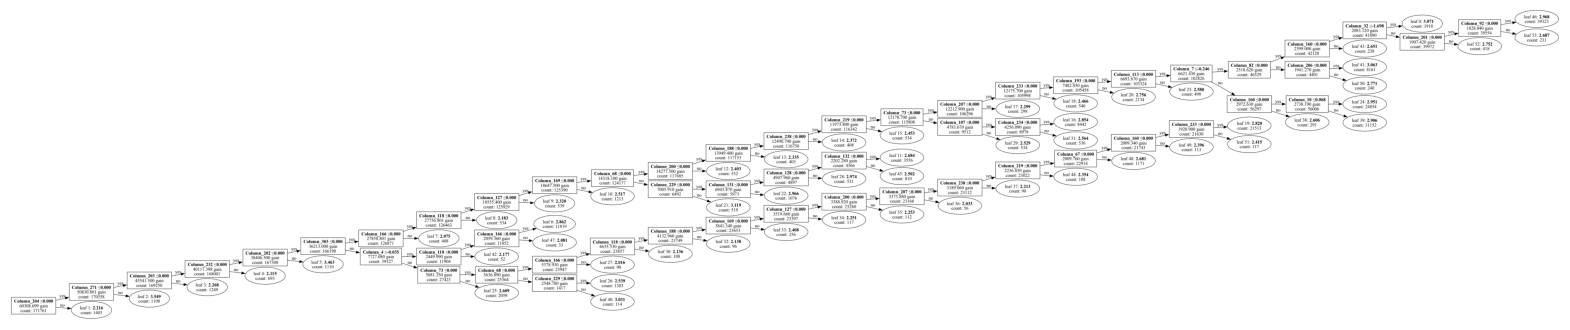

In [104]:
model_name = 'LGBMRegressor: GDSC Baseline'
model_use = models_dict[model_name]
booster = best_pipe.named_steps['model'].booster_
ax = lgb.plot_tree(
    booster,
    tree_index=0,         # which tree in the ensemble if exploring ensemble models
    figsize=(20,10),
    show_info=['split_gain','internal_count', 'leaf_count']
)
plt.show()